# Training Deep Neural Nets

![dnn-config](https://www.dropbox.com/s/77hfezzpek1n00y/default-dnn-config.png?dl=1)

This default configuration may need to be tweaked:
- If you can’t find a good learning rate (convergence was too slow, so you increased the training rate, and now convergence is fast but the network’s accuracy is suboptimal), then you can try adding a learning schedule such as exponential decay.
- If your training set is a bit too small, you can implement data augmentation. If you need a sparse model, you can add some ℓ1 regularization to the mix (and optionally zero out the tiny weights after training).
- If you need an even sparser model, you can try using FTRL instead of Adam optimization, along with ℓ1 regularization.
- If you need a lightning-fast model at runtime, you may want to drop Batch Normalization, and possibly replace the ELU activation function with the leaky ReLU. Having a sparse model will also help.

## Setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Vanishing/Exploding Gradients Problem

Gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution. This is called the **vanishing gradients** problem.

In some cases, the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges. This is the **exploding gradients** problem, which is mostly encountered in recurrent neural networks. More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

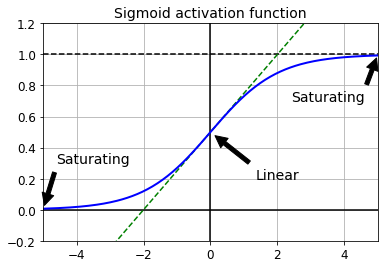

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show();

### Xavier and He Initialization

Note: the book uses `tensorflow.contrib.layers.fully_connected()` rather than `tf.layers.dense()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dense()`, because anything in the contrib module may change or be deleted without notice. The `dense()` function is almost identical to the `fully_connected()` function. The main differences relevant to this chapter are:
* several parameters are renamed: `scope` becomes `name`, `activation_fn` becomes `activation` (and similarly the `_fn` suffix is removed from other parameters such as `normalizer_fn`), `weights_initializer` becomes `kernel_initializer`, etc.
* the default `activation` is now `None` rather than `tf.nn.relu`.
* it does not support `tensorflow.contrib.framework.arg_scope()` (introduced later in chapter 11).
* it does not support regularizer params (introduced later in chapter 11).

In [4]:
import tensorflow as tf

/anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [6]:
he_init = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name="hidden1")

### Nonsaturating Activation Functions

Unfortunately, the *ReLU* activation function is not perfect. It suffers from a problem known as the *dying ReLUs*: during training, some neurons effectively die, meaning they stop outputting anything other than 0. In some cases, you may find that half of your network’s neurons are dead, especially if you used a large learning rate. During training, if a neuron’s weights get updated such that the weighted sum of the neuron’s inputs is negative, it will start outputting 0. When this happens, the neuron is unlikely to come back to life since the gradient of the *ReLU* function is 0 when its input is negative.

**TIP**

So which activation function should you use for the hidden layers of your deep neural networks?

Although your mileage will vary, in general `ELU` > `leaky ReLU` (and its variants) > `ReLU` > `tanh` > `logistic`.

- If you care a lot about runtime performance, then you may prefer `leaky ReLUs` over `ELUs`.
- If you don’t want to tweak yet another hyperparameter, you may just use the default `α` values suggested earlier (0.01 for the `leaky ReLU`, and 1 for `ELU`).
- If you have spare time and computing power, you can use *cross-validation* to evaluate other activation functions, in particular `RReLU` if your network is overfitting, or `PReLU` if you have a huge training set.

#### Leaky ReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha * z, z)

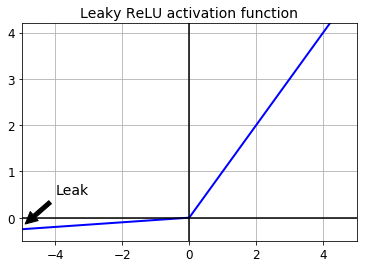

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show();

Implementing Leaky ReLU in TensorFlow:

In [9]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

In [11]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")

Let's train a neural network on MNIST using the Leaky ReLU. First let's create the graph:

In [12]:
reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

In [13]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [14]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [15]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [16]:
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

In [17]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [18]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

In [19]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [20]:
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [21]:
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [22]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [23]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.86 Validation accuracy: 0.9044
5 Batch accuracy: 0.94 Validation accuracy: 0.9496
10 Batch accuracy: 0.92 Validation accuracy: 0.9654
15 Batch accuracy: 0.94 Validation accuracy: 0.971
20 Batch accuracy: 1.0 Validation accuracy: 0.9764
25 Batch accuracy: 1.0 Validation accuracy: 0.9778
30 Batch accuracy: 0.98 Validation accuracy: 0.978
35 Batch accuracy: 1.0 Validation accuracy: 0.9788


#### ELU

In [24]:
def elu(z, alpha=0.01):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

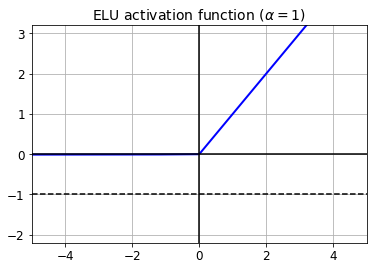

In [25]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show();

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [26]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

In [27]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name="hidden1")

#### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017 (I will definitely add it to the book). It outperforms the other activation functions very significantly for deep neural networks, so you should really try it out.

In [28]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

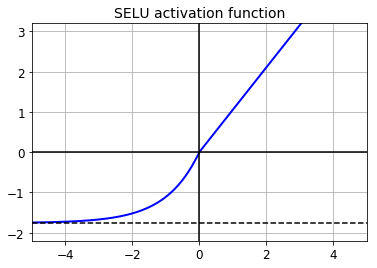

In [29]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show();

With this activation function, even a 100 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [30]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100))

for layer in range(100):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100))
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=1)
    stds = np.std(Z, axis=1)
    
    if layer % 10 == 0:
        print("Layer {}: {:.2f} < mean < {:.2f}, {:.2f} < std deviation < {:.2f}".format(
            layer, means.min(), means.max(), stds.min(), stds.max()))

Layer 0: -0.26 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 10: -0.24 < mean < 0.27, 0.74 < std deviation < 1.27
Layer 20: -0.17 < mean < 0.18, 0.74 < std deviation < 1.24
Layer 30: -0.27 < mean < 0.24, 0.78 < std deviation < 1.20
Layer 40: -0.38 < mean < 0.39, 0.74 < std deviation < 1.25
Layer 50: -0.27 < mean < 0.31, 0.73 < std deviation < 1.27
Layer 60: -0.26 < mean < 0.43, 0.74 < std deviation < 1.35
Layer 70: -0.19 < mean < 0.21, 0.75 < std deviation < 1.21
Layer 80: -0.18 < mean < 0.16, 0.72 < std deviation < 1.19
Layer 90: -0.19 < mean < 0.16, 0.75 < std deviation < 1.20


Here's a TensorFlow implementation (there will almost certainly be a `tf.nn.selu()` function in future TensorFlow versions):

In [31]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

SELUs can also be combined with dropout, check out [this implementation](https://github.com/bioinf-jku/SNNs/blob/master/selu.py) by the Institute of Bioinformatics, Johannes Kepler University Linz.

Let's create a neural net for MNIST using the SELU activation function:

In [32]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [33]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, "Batch accuracy:", acc_batch, "Validation accuracy:", acc_valid)

    save_path = saver.save(sess, "./my_model_final_selu.ckpt")

0 Batch accuracy: 0.88 Validation accuracy: 0.923
5 Batch accuracy: 0.98 Validation accuracy: 0.9578
10 Batch accuracy: 1.0 Validation accuracy: 0.9664
15 Batch accuracy: 0.96 Validation accuracy: 0.9682
20 Batch accuracy: 1.0 Validation accuracy: 0.9694
25 Batch accuracy: 1.0 Validation accuracy: 0.9688
30 Batch accuracy: 1.0 Validation accuracy: 0.9694
35 Batch accuracy: 1.0 Validation accuracy: 0.97


## Batch Normalization

In a [2015 paper](https://arxiv.org/pdf/1502.03167v3.pdf), 7 Sergey Ioffe and Christian Szegedy proposed a technique called *Batch Normalization* (BN) to address the vanishing/exploding gradients problems, and more generally the problem that the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change (which they call the *Internal Covariate Shift* problem).

The technique consists of adding an operation in the model just before the activation function of each layer, simply zero-centering and normalizing the inputs, then scaling and shifting the result using two new parameters per layer (one for scaling, the other for shifting). In other words, this operation lets the model learn the optimal scale and mean of the inputs for each layer.

In order to zero-center and normalize the inputs, the algorithm needs to estimate the inputs’ mean and standard deviation. It does so by evaluating the mean and standard deviation of the inputs over the current mini-batch (hence the name “Batch Normalization”).

![BN](https://www.dropbox.com/s/rmjoencidkkshu3/batch-normalization.png?dl=1)

Note: the book uses `tensorflow.contrib.layers.batch_norm()` rather than `tf.layers.batch_normalization()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.batch_normalization()`, because anything in the contrib module may change or be deleted without notice. Instead of using the `batch_norm()` function as a regularizer parameter to the `fully_connected()` function, we now use `batch_normalization()` and we explicitly create a distinct layer. The parameters are a bit different, in particular:
* `decay` is renamed to `momentum`,
* `is_training` is renamed to `training`,
* `updates_collections` is removed: the update operations needed by batch normalization are added to the `UPDATE_OPS` collection and you need to explicity run these operations during training (see the execution phase below),
* we don't need to specify `scale=True`, as that is the default.

Also note that in order to run batch norm just _before_ each hidden layer's activation function, we apply the ELU activation function manually, right after the batch norm layer.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`). As you can see, the code remains very similar.

In [34]:
reset_graph()

import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")

training = tf.placeholder_with_default(False, shape=(), name='training')

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

In [35]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
training = tf.placeholder_with_default(False, shape=(), name='training')

To avoid repeating the same parameters over and over again, we can use Python's `partial()` function:

In [36]:
from functools import partial

batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = batch_norm_layer(logits_before_bn)

Let's build a neural net for MNIST, using the ELU activation function and Batch Normalization at each layer:

In [37]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(False, shape=(), name="training")

with tf.name_scope("dnn"):
    he_init = tf.variance_scaling_initializer()
    
    batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=batch_norm_momentum)
    dense_layer = partial(tf.layers.dense, kernel_initializer=he_init)
    
    hidden1 = dense_layer(X, n_hidden1, name="hidden1")
    bn1 = tf.nn.elu(batch_norm_layer(hidden1))
    hidden2 = dense_layer(bn1, n_hidden2, name="hidden2")
    bn2 = tf.nn.elu(batch_norm_layer(hidden2))
    logits_before_bn = dense_layer(bn2, n_outputs, name="outputs")
    logits = batch_norm_layer(logits_before_bn)
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Note: since we are using `tf.layers.batch_normalization()` rather than `tf.contrib.layers.batch_norm()` (as in the book), we need to explicitly run the extra update operations needed by batch normalization (`sess.run([training_op, extra_update_ops],...`).

In [38]:
n_epochs = 20
batch_size = 200

In [39]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.9042
1 Validation accuracy: 0.928
2 Validation accuracy: 0.9374
3 Validation accuracy: 0.9474
4 Validation accuracy: 0.9532
5 Validation accuracy: 0.9572
6 Validation accuracy: 0.9626
7 Validation accuracy: 0.9628
8 Validation accuracy: 0.9664
9 Validation accuracy: 0.968
10 Validation accuracy: 0.9694
11 Validation accuracy: 0.9696
12 Validation accuracy: 0.971
13 Validation accuracy: 0.971
14 Validation accuracy: 0.9728
15 Validation accuracy: 0.9734
16 Validation accuracy: 0.9728
17 Validation accuracy: 0.975
18 Validation accuracy: 0.9752
19 Validation accuracy: 0.976


What!? That's not a great accuracy for MNIST. Of course, if you train for longer it will get much better accuracy, but with such a shallow network, Batch Norm and ELU are unlikely to have very positive impact: they shine mostly for much deeper nets.

Note that you could also make the training operation depend on the update operations:

```python
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)
```

This way, you would just have to evaluate the `training_op` during training, TensorFlow would automatically run the update operations as well:

```python
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})
```


One more thing: notice that the list of trainable variables is shorter than the list of all global variables. This is because the moving averages are non-trainable variables. If you want to reuse a pretrained neural network (see below), you must not forget these non-trainable variables.

In [40]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [41]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

### Gradient Clipping

A popular technique to lessen the exploding gradients problem is to simply clip the gradients during backpropagation so that they never exceed some threshold. This is called *Gradient Clipping*. In general people now prefer *Batch Normalization*, but it’s still useful to know about *Gradient Clipping* and how to implement it.

Let's create a simple neural net for MNIST and add gradient clipping. The first part is the same as earlier (except we added a few more layers to demonstrate reusing pretrained models, see below):

In [42]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [43]:
learning_rate = 0.01

Now we apply gradient clipping. For this, we need to get the gradients, use the `clip_by_value()` function to clip them, then apply them:

In [44]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
              for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

In [45]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [46]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [47]:
n_epochs = 20
batch_size = 200

In [48]:
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.288
1 Validation accuracy: 0.7936
2 Validation accuracy: 0.8798
3 Validation accuracy: 0.906
4 Validation accuracy: 0.9164
5 Validation accuracy: 0.9218
6 Validation accuracy: 0.9296
7 Validation accuracy: 0.9358
8 Validation accuracy: 0.9382
9 Validation accuracy: 0.9414
10 Validation accuracy: 0.9456
11 Validation accuracy: 0.9474
12 Validation accuracy: 0.9478
13 Validation accuracy: 0.9534
14 Validation accuracy: 0.9568
15 Validation accuracy: 0.9566
16 Validation accuracy: 0.9574
17 Validation accuracy: 0.959
18 Validation accuracy: 0.9622
19 Validation accuracy: 0.9612


### Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one you are trying to tackle, then just reuse the lower layers of this network: this is called transfer learning. It will not only speed up training considerably, but will also require much less training data.

### Reusing a TensorFlow Model

If the original model was trained using TensorFlow, you can simply restore it and train it on the new task.

First you need to load the graph's structure. The `import_meta_graph()` function does just that, loading the graph's operations into the default graph, and returning a `Saver` that you can then use to restore the model's state. Note that by default, a `Saver` saves the structure of the graph into a `.meta` file, so that's the file you should load:

In [49]:
reset_graph()

In [50]:
saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

Next you need to get a handle on all the operations you will need for training. If you don't know the graph's structure, you can list all the operations:

In [51]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

save/RestoreV2/shape_and_slices
save/RestoreV2/tensor_names
save/SaveV2/shape_and_slices
save/SaveV2/tensor_names
save/Const
save/RestoreV2
eval/Const
eval/in_top_k/InTopKV2/k
GradientDescent/learning_rate
clip_by_value_11/clip_value_max
clip_by_value_11/clip_value_min
clip_by_value_10/clip_value_max
clip_by_value_10/clip_value_min
clip_by_value_9/clip_value_max
clip_by_value_9/clip_value_min
clip_by_value_8/clip_value_max
clip_by_value_8/clip_value_min
clip_by_value_7/clip_value_max
clip_by_value_7/clip_value_min
clip_by_value_6/clip_value_max
clip_by_value_6/clip_value_min
clip_by_value_5/clip_value_max
clip_by_value_5/clip_value_min
clip_by_value_4/clip_value_max
clip_by_value_4/clip_value_min
clip_by_value_3/clip_value_max
clip_by_value_3/clip_value_min
clip_by_value_2/clip_value_max
clip_by_value_2/clip_value_min
clip_by_value_1/clip_value_max
clip_by_value_1/clip_value_min
clip_by_value/clip_value_max
clip_by_value/clip_value_min
gradients/loss/SparseSoftmaxCrossEntropyWithLogits

Oops, that's a lot of operations! It's much easier to use TensorBoard to visualize the graph. The following hack will allow you to visualize the graph within Jupyter (if it does not work with your browser, you will need to use a `FileWriter` to save the graph and then visualize it in TensorBoard):

In [52]:
# Works on Chrome, not guaranteed on other browsers

from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [53]:
show_graph(tf.get_default_graph())

Once you know which operations you need, you can get a handle on them using the graph's `get_operation_by_name()` or `get_tensor_by_name()` methods:

In [54]:
X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_operation_by_name("GradientDescent")

If you are the author of the original model, you could make things easier for people who will reuse your model by giving operations very clear names and documenting them. Another approach is to create a collection containing all the important operations that people will want to get a handle on:

In [55]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("my_important", op)

This way people who reuse your model will be able to simply write:

In [56]:
X, y, accuracy, training_op = tf.get_collection("my_important")

Now you can start a session, restore the model's state and continue training on your data:

In [57]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


Actually, let's test this for real!

In [58]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9636
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9658
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9646
5 Validation accuracy: 0.965
6 Validation accuracy: 0.969
7 Validation accuracy: 0.9682
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9684
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.971
12 Validation accuracy: 0.9668
13 Validation accuracy: 0.97
14 Validation accuracy: 0.9712
15 Validation accuracy: 0.9726
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.971
18 Validation accuracy: 0.9712
19 Validation accuracy: 0.9712


Alternatively, if you have access to the Python code that built the original graph, you can use it instead of `import_meta_graph()`:

In [59]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
learning_rate = 0.01
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

And continue training:

In [60]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")    

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9642
1 Validation accuracy: 0.9632
2 Validation accuracy: 0.9656
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9646
5 Validation accuracy: 0.9652
6 Validation accuracy: 0.9688
7 Validation accuracy: 0.9686
8 Validation accuracy: 0.9682
9 Validation accuracy: 0.9686
10 Validation accuracy: 0.9704
11 Validation accuracy: 0.9712
12 Validation accuracy: 0.967
13 Validation accuracy: 0.9698
14 Validation accuracy: 0.9708
15 Validation accuracy: 0.9724
16 Validation accuracy: 0.9718
17 Validation accuracy: 0.9712
18 Validation accuracy: 0.9708
19 Validation accuracy: 0.9712


In general you will want to reuse only the lower layers. If you are using `import_meta_graph()` it will load the whole graph, but you can simply ignore the parts you do not need. In this example, we add a new 4th hidden layer on top of the pretrained 3rd layer (ignoring the old 4th hidden layer). We also build a new output layer, the loss for this new output, and a new optimizer to minimize it. We also need another saver to save the whole graph (containing both the entire old graph plus the new operations), and an initialization operation to initialize all the new variables:

In [61]:
reset_graph()

n_hidden4 = 20  # new layer
n_outputs = 10  # new layer

saver = tf.train.import_meta_graph("./my_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden3 = tf.get_default_graph().get_tensor_by_name("dnn/hidden4/Relu:0")

new_hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="new_hidden4")
new_logits = tf.layers.dense(new_hidden4, n_outputs, name="new_outputs")

with tf.name_scope("new_loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("new_eval"):
    correct = tf.nn.in_top_k(new_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("new_train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

And we can train this new model:

In [62]:
with tf.Session() as sess:
    init.run()
    saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = new_saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9246
1 Validation accuracy: 0.945
2 Validation accuracy: 0.953
3 Validation accuracy: 0.9582
4 Validation accuracy: 0.9606
5 Validation accuracy: 0.9562
6 Validation accuracy: 0.9622
7 Validation accuracy: 0.9624
8 Validation accuracy: 0.9642
9 Validation accuracy: 0.9644
10 Validation accuracy: 0.9656
11 Validation accuracy: 0.9664
12 Validation accuracy: 0.965
13 Validation accuracy: 0.9676
14 Validation accuracy: 0.9678
15 Validation accuracy: 0.9688
16 Validation accuracy: 0.9692
17 Validation accuracy: 0.97
18 Validation accuracy: 0.9688
19 Validation accuracy: 0.968


If you have access to the Python code that built the original graph, you can just reuse the parts you need and drop the rest:

In [63]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

However, you must create one `Saver` to restore the pretrained model (giving it the list of variables to restore, or else it will complain that the graphs don't match), and another `Saver` to save the new model, once it is trained:

In [64]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]") # regex
restore_path = tf.train.Saver(reuse_vars) # restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_path.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):                                            
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size): 
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})        
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})     
        print(epoch, "Validation accuracy:", accuracy_val)                   

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.9024
1 Validation accuracy: 0.9332
2 Validation accuracy: 0.943
3 Validation accuracy: 0.947
4 Validation accuracy: 0.9516
5 Validation accuracy: 0.9532
6 Validation accuracy: 0.9558
7 Validation accuracy: 0.9592
8 Validation accuracy: 0.9586
9 Validation accuracy: 0.9608
10 Validation accuracy: 0.9626
11 Validation accuracy: 0.962
12 Validation accuracy: 0.964
13 Validation accuracy: 0.9662
14 Validation accuracy: 0.966
15 Validation accuracy: 0.9662
16 Validation accuracy: 0.9672
17 Validation accuracy: 0.9674
18 Validation accuracy: 0.9682
19 Validation accuracy: 0.9678


### Reusing Models from Other Frameworks

If the model was trained using another framework, you will need to load the model parameters manually (e.g., using Theano code if it was trained with Theano), then assign them to the appropriate variables. This can be quite tedious. For example, the following code shows how you would copy the weight and biases from the first hidden layer of a model trained using another framework.

In this example, for each variable we want to reuse, we find its initializer's assignment operation, and we get its second input, which corresponds to the initialization value. When we run the initializer, we replace the initialization values with the ones we want, using a `feed_dict`:

In [65]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

In [66]:
original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name("hidden1/kernel/Assign")
assign_bias = graph.get_operation_by_name("hidden1/bias/Assign")
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict={init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note: the weights variable created by the `tf.layers.dense()` function is called `"kernel"` (instead of `"weights"` when using the `tf.contrib.layers.fully_connected()`, as in the book), and the biases variable is called `bias` instead of `biases`.

Another approach (initially used in the book) would be to create dedicated assignment nodes and dedicated placeholders. This is more verbose and less efficient, but you may find this more explicit:

In [67]:
reset_graph()

n_inputs = 2
n_hidden1 = 3

original_w = [[1., 2., 3.], [4., 5., 6.]] # Load the weights from the other framework
original_b = [7., 8., 9.]                 # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
# [...] Build the rest of the model

# Get a handle on the variables of layer hidden1
with tf.variable_scope("", default_name="", reuse=True):  # root scope
    hidden1_weights = tf.get_variable("hidden1/kernel")
    hidden1_biases = tf.get_variable("hidden1/bias")

# Create dedicated placeholders and assignment nodes
original_weights = tf.placeholder(tf.float32, shape=(n_inputs, n_hidden1))
original_biases = tf.placeholder(tf.float32, shape=n_hidden1)
assign_hidden1_weights = tf.assign(hidden1_weights, original_weights)
assign_hidden1_biases = tf.assign(hidden1_biases, original_biases)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    sess.run(assign_hidden1_weights, feed_dict={original_weights: original_w})
    sess.run(assign_hidden1_biases, feed_dict={original_biases: original_b})
    # [...] Train the model on your new task
    print(hidden1.eval(feed_dict={X: [[10.0, 11.0]]}))

[[ 61.  83. 105.]]


Note that we could also get a handle on the variables using `get_collection()` and specifying the `scope`:

In [68]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden1")

[<tf.Variable 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(3,) dtype=float32_ref>]

Or we could use the graph's `get_tensor_by_name()` method:

In [69]:
tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")

<tf.Tensor 'hidden1/kernel:0' shape=(2, 3) dtype=float32_ref>

In [70]:
tf.get_default_graph().get_tensor_by_name("hidden1/bias:0")

<tf.Tensor 'hidden1/bias:0' shape=(3,) dtype=float32_ref>

#### Freezing the Lower Layers

It is likely that the lower layers of the first DNN have learned to detect low-level features in pictures that will be useful across both image classification tasks, so you can just reuse these layers as they are. It is generally a good idea to “freeze” their weights when training the new DNN: if the lower-layer weights are fixed, then the higher-layer weights will be easier to train (because they won’t have to learn a moving target). To freeze the lower layers during training, one solution is to give the optimizer the list of variables to train, excluding the variables from the lower layers.

In [71]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")       # reused
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")                         # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [72]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|outputs")
    training_op = optimizer.minimize(loss, var_list=train_vars)

In [73]:
init = tf.global_variables_initializer()
new_saver = tf.train.Saver()

In [74]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]") # regular expression
restore_saver = tf.train.Saver(reuse_vars) # to restore layers 1-3

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")

    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.8964
1 Validation accuracy: 0.9298
2 Validation accuracy: 0.94
3 Validation accuracy: 0.9442
4 Validation accuracy: 0.948
5 Validation accuracy: 0.951
6 Validation accuracy: 0.9508
7 Validation accuracy: 0.9538
8 Validation accuracy: 0.9554
9 Validation accuracy: 0.957
10 Validation accuracy: 0.9562
11 Validation accuracy: 0.9566
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9578
14 Validation accuracy: 0.959
15 Validation accuracy: 0.9576
16 Validation accuracy: 0.9574
17 Validation accuracy: 0.9602
18 Validation accuracy: 0.9592
19 Validation accuracy: 0.9602


Another option is to add a stop_gradient() layer in the graph. Any layer below it will be frozen:

In [75]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [76]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2") # reused frozen
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu, name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

In [77]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

The training code is exactly the same as earlier:

In [78]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.902
1 Validation accuracy: 0.9302
2 Validation accuracy: 0.9438
3 Validation accuracy: 0.9478
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9556
9 Validation accuracy: 0.9558
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9582
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9578
18 Validation accuracy: 0.9594
19 Validation accuracy: 0.958


#### Caching the Frozen Layers

Since the frozen layers won’t change, it is possible to cache the output of the topmost frozen layer for each training instance. Since training goes through the whole dataset many times, this will give you a huge speed boost as you will only need to go through the frozen layers once per training instance (instead of once per epoch). For example, you could first run the whole training set through the lower layers (assuming you have enough RAM), then during training, instead of building batches of training instances, you would build batches of outputs from hidden layer   2 and feed them to the training operation.

In [79]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300 # reused
n_hidden2 = 50  # reused
n_hidden3 = 50  # reused
n_hidden4 = 20  # new!
n_outputs = 10  # new!

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,
                              name="hidden1") # reused frozen
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu,
                              name="hidden2") # reused frozen & cached
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation=tf.nn.relu,
                              name="hidden3") # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu,
                              name="hidden4") # new!
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs") # new!

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [80]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")
restore_saver = tf.train.Saver(reuse_vars)

In [81]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [82]:
import numpy as np

n_batches = len(X_train) // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_model_final.ckpt")
    
    h2_cache = sess.run(hidden2, feed_dict={X: X_train})
    h2_cache_valid = sess.run(hidden2, feed_dict={X: X_valid}) 

    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(len(X_train))
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2: hidden2_batch, y: y_batch})
            
        accuracy_val = accuracy.eval(feed_dict={hidden2: h2_cache_valid, y: y_valid})             
        print(epoch, "Validation accuracy:", accuracy_val)               

    save_path = saver.save(sess, "./my_new_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt
0 Validation accuracy: 0.902
1 Validation accuracy: 0.9302
2 Validation accuracy: 0.9438
3 Validation accuracy: 0.9478
4 Validation accuracy: 0.9514
5 Validation accuracy: 0.9522
6 Validation accuracy: 0.9524
7 Validation accuracy: 0.9556
8 Validation accuracy: 0.9556
9 Validation accuracy: 0.9558
10 Validation accuracy: 0.957
11 Validation accuracy: 0.9552
12 Validation accuracy: 0.9572
13 Validation accuracy: 0.9582
14 Validation accuracy: 0.9582
15 Validation accuracy: 0.957
16 Validation accuracy: 0.9566
17 Validation accuracy: 0.9578
18 Validation accuracy: 0.9594
19 Validation accuracy: 0.958


### Tweaking, Dropping, or Replacing the Upper Layers

The output layer of the original model should usually be replaced since it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers, since the high-level features that are most useful for the new task may differ significantly from the ones that were most useful for the original task. You want to find the right number of layers to reuse.

Try freezing all the copied layers first, then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. The more training data you have, the more layers you can unfreeze.

If you still cannot get good performance, and you have little training data, try dropping the top hidden layer( s) and freeze all remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even add more hidden layers.

## Faster Optimizers

### Momentum optimization

Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the very simple idea behind *Momentum optimization*, proposed by Boris Polyak in 1964.10 In contrast, regular Gradient Descent will simply take small regular steps down the slope, so it will take much more time to reach the bottom.

In [83]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)

The one drawback of Momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of 0.9 usually works well in practice and almost always goes faster than Gradient Descent.

### Nesterov Accelerated Gradient

One small variant to Momentum optimization, proposed by Yurii Nesterov in 1983, is almost always faster than vanilla Momentum optimization. The idea of *Nesterov Momentum optimization*, or *Nesterov Accelerated Gradient* (NAG), is to measure the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum. The only difference from vanilla Momentum optimization is that the gradient is measured at θ + βm rather than at θ.

In [84]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)

### AdaGrad

Consider the elongated bowl problem again: Gradient Descent starts by quickly going down the steepest slope, then slowly goes down the bottom of the valley. It would be nice if the algorithm could detect this early on and correct its direction to point a bit more toward the global optimum.

The *AdaGrad* algorithm achieves this by scaling down the gradient vector along the steepest dimensions.

In [85]:
optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)

### RMSProp

Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum, the RMSProp algorithm fixes this by accumulating only the gradients from the most recent iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay in the first step.

In [86]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9, decay=0.9, epsilon=1e-10)

### Adam Optimization

Adam, which stands for *adaptive moment estimation*, combines the ideas of Momentum optimization and RMSProp: just like Momentum optimization it keeps track of an exponentially decaying average of past gradients, and just like RMSProp it keeps track of an exponentially decaying average of past squared gradients.

In [87]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

All the optimization techniques discussed so far only rely on the *first-order partial derivatives* (*Jacobians*). The optimization literature contains amazing algorithms based on the *second-order partial derivatives* (*the Hessians*). Unfortunately, these algorithms are very hard to apply to deep neural networks because there are n2 Hessians per output (where n is the number of parameters), as opposed to just n Jacobians per output. Since DNNs typically have tens of thousands of parameters, the second-order optimization algorithms often don’t even fit in memory, and even when they do, computing the Hessians is just too slow.

### Learning Rate Scheduling

Finding a good learning rate can be tricky. If you set it way too high, training may actually diverge. If you set it too low, training will eventually converge to the optimum, but it will take a very long time. If you set it slightly too high, it will make progress very quickly at first, but it will end up dancing around the optimum, never settling down. If you have a limited computing budget, you may have to interrupt training before it has converged properly, yielding a suboptimal solution.

You may be able to find a fairly good learning rate by training your network several times during just a few epochs using various learning rates and comparing the learning curves. The ideal learning rate will learn quickly and 
converge to good solution.

However, you can do better than a constant learning rate: if you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. These strategies are called *learning schedules*, the most common of which are:
- *Predetermined piecewise constant learning rate*. For example, set the learning rate to η0 = 0.1 at first, then to η1 = 0.001 after 50 epochs. Although this solution can work very well, it often requires fiddling around to figure out the right learning rates and when to use them.
- *Performance scheduling*. Measure the validation error every N steps (just likefor early stopping) and reduce the learning rate by a factor of λ when the error stops dropping.
- *Exponential scheduling*. Set the learning rate to a function of the iteration number t: η( t) = η0 10– t/ r. This works great, but it requires tuning η0 and r. The learning rate will drop by a factor of   10 every r steps.
- *Power scheduling*. Set the learning rate to η( t) = η0 (1 + t/ r)– c. The hyperparameter c is typically set to   1. This is similar to exponential scheduling, but the learning rate drops much more slowly.

In [88]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [89]:
with tf.name_scope("train"):
    initial_learning_rate = 0.1
    decay_steps = 10000
    decay_rate = 1/10
    global_step = tf.Variable(0, trainable=False, name="global_step")
    learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss, global_step=global_step)

In [90]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [91]:
n_epochs = 5
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "validation accuracy", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 validation accuracy 0.959
1 validation accuracy 0.9688
2 validation accuracy 0.9726
3 validation accuracy 0.9804
4 validation accuracy 0.982


## Avoiding Overfitting Through Regularization

### $\ell_1$ and $\ell_2$ regularization

Let's implement $\ell_1$ regularization manually. First, we create the model, as usual (with just one hidden layer this time, for simplicity):

In [92]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    logits = tf.layers.dense(hidden1, n_outputs, name="outputs")

Next, we get a handle on the layer weights, and we compute the total loss, which is equal to the sum of the usual cross entropy loss and the $\ell_1$ loss (i.e., the absolute values of the weights):

In [93]:
W1 = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
W2 = tf.get_default_graph().get_tensor_by_name("outputs/kernel:0")

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name="loss")

The rest is just as usual:

In [94]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")
    
learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [95]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.831
1 Validation accuracy: 0.871
2 Validation accuracy: 0.8838
3 Validation accuracy: 0.8934
4 Validation accuracy: 0.8966
5 Validation accuracy: 0.8988
6 Validation accuracy: 0.9016
7 Validation accuracy: 0.9044
8 Validation accuracy: 0.9058
9 Validation accuracy: 0.906
10 Validation accuracy: 0.9068
11 Validation accuracy: 0.9054
12 Validation accuracy: 0.907
13 Validation accuracy: 0.9084
14 Validation accuracy: 0.9088
15 Validation accuracy: 0.9064
16 Validation accuracy: 0.9066
17 Validation accuracy: 0.9066
18 Validation accuracy: 0.9066
19 Validation accuracy: 0.9052


Alternatively, we can pass a regularization function to the `tf.layers.dense()` function, which will use it to create operations that will compute the regularization loss, and it adds these operations to the collection of regularization losses. The beginning is the same as above:

In [96]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

Next, we will use Python's `partial()` function to avoid repeating the same arguments over and over again. Note that we set the `kernel_regularizer` argument:

In [97]:
scale = 0.001

In [98]:
dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.relu,
    kernel_regularizer=tf.contrib.layers.l1_regularizer(scale)
)

with tf.name_scope("dnn"):
    hidden1 = dense_layer(X, n_hidden1, name="hidden1")
    hidden2 = dense_layer(hidden1, n_hidden2, name="hidden2")
    logits = dense_layer(hidden2, n_outputs, activation=None, name="outputs")

Next we must add the regularization losses to the base loss:

In [99]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    
    base_loss = tf.reduce_mean(xentropy, name="avg_xentropy")
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    loss = tf.add_n([base_loss] + reg_losses, name="loss")

In [100]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [101]:
n_epochs = 20
batch_size = 200

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy: 0.8274
1 Validation accuracy: 0.8766
2 Validation accuracy: 0.8952
3 Validation accuracy: 0.9016
4 Validation accuracy: 0.908
5 Validation accuracy: 0.9096
6 Validation accuracy: 0.9126
7 Validation accuracy: 0.9154
8 Validation accuracy: 0.9178
9 Validation accuracy: 0.919
10 Validation accuracy: 0.92
11 Validation accuracy: 0.9224
12 Validation accuracy: 0.9212
13 Validation accuracy: 0.9228
14 Validation accuracy: 0.9224
15 Validation accuracy: 0.9216
16 Validation accuracy: 0.9218
17 Validation accuracy: 0.9228
18 Validation accuracy: 0.9216
19 Validation accuracy: 0.9214


### Dropout

The most popular regularization technique for deep neural networks is *arguably dropout*. It was proposed by G. E. Hinton in 2012 and further detailed in a paper by Nitish Srivastava et al., and it has proven to be highly successful: even the state-of-the-art neural networks got a 1– 2% accuracy boost simply by adding dropout. This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%).

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons but excluding the output neurons) has a probability p of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step. The hyperparameter *p* is called the dropout rate, and it is typically set to 50%. After training, neurons don’t get dropped anymore.

Note: the book uses `tf.contrib.layers.dropout()` rather than `tf.layers.dropout()` (which did not exist when this chapter was written). It is now preferable to use `tf.layers.dropout()`, because anything in the contrib module may change or be deleted without notice. The `tf.layers.dropout()` function is almost identical to the `tf.contrib.layers.dropout()` function, except for a few minor differences. Most importantly:
* you must specify the dropout rate (`rate`) rather than the keep probability (`keep_prob`), where `rate` is simply equal to `1 - keep_prob`,
* the `is_training` parameter is renamed to `training`.

In [102]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [103]:
training = tf.placeholder_with_default(False, shape=(), name="training")

dropout_rate = 0.5 # 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training=training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training=training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name="outputs")

In [104]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [105]:
n_epochs = 20
batch_size = 50

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy 0.9584
1 Validation accuracy 0.9722
2 Validation accuracy 0.968
3 Validation accuracy 0.9772
4 Validation accuracy 0.9782
5 Validation accuracy 0.9772
6 Validation accuracy 0.9822
7 Validation accuracy 0.9824
8 Validation accuracy 0.9798
9 Validation accuracy 0.982
10 Validation accuracy 0.9834
11 Validation accuracy 0.9834
12 Validation accuracy 0.9846
13 Validation accuracy 0.9838
14 Validation accuracy 0.9844
15 Validation accuracy 0.9846
16 Validation accuracy 0.9842
17 Validation accuracy 0.9846
18 Validation accuracy 0.9848
19 Validation accuracy 0.984


### Max norm

*Max-norm regularization*: for each neuron, it constrains the weights **w** of the incoming connections such that **∥ w ∥** *2 ≤ r*, where **r** is the max-norm hyperparameter and **∥ · ∥ 2** is the **ℓ2** norm. We typically implement this constraint by computing **∥ w ∥ 2** after each training step and clipping **w** if needed. Reducing *r* increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the vanishing/ exploding gradients problems (if you are not using Batch Normalization).

Let's go back to a plain and simple neural net for MNIST with just 2 hidden layers:

In [106]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

Next, let's get a handle on the first hidden layer's weight and create an operation that will compute the clipped weights using the `clip_by_norm()` function. Then we create an assignment operation to assign the clipped weights to the weights variable:

In [107]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name("hidden1/kernel:0")
clipped_weights = tf.clip_by_norm(weights, clip_norm=threshold, axes=1)
clip_weights = tf.assign(weights, clipped_weights)

We can do this as well for the second hidden layer:

In [108]:
weights2 = tf.get_default_graph().get_tensor_by_name("hidden2/kernel:0")
clipped_weights2 = tf.clip_by_norm(weights2, clip_norm=threshold, axes=1)
clip_weights2 = tf.assign(weights2, clipped_weights2)

Let's add an initializer and a saver:

In [109]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

And now we can train the model. It's pretty much as usual, except that right after running the `training_op`, we run the `clip_weights` and `clip_weights2` operations:

In [110]:
n_epochs = 20
batch_size = 50

In [111]:
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            clip_weights.eval()
            clip_weights2.eval()
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy", accuracy_val)
        
    save_path = saver.save(sess, "./my_model_final.ckpt")

0 Validation accuracy 0.9568
1 Validation accuracy 0.9696
2 Validation accuracy 0.972
3 Validation accuracy 0.9768
4 Validation accuracy 0.9784
5 Validation accuracy 0.9786
6 Validation accuracy 0.9816
7 Validation accuracy 0.9808
8 Validation accuracy 0.981
9 Validation accuracy 0.983
10 Validation accuracy 0.9822
11 Validation accuracy 0.9854
12 Validation accuracy 0.9822
13 Validation accuracy 0.9842
14 Validation accuracy 0.984
15 Validation accuracy 0.9852
16 Validation accuracy 0.984
17 Validation accuracy 0.9844
18 Validation accuracy 0.9844
19 Validation accuracy 0.9844


The implementation above is straightforward and it works fine, but it is a bit messy. A better approach is to define a `max_norm_regularizer()` function:

In [112]:
def max_norm_regularizer(threshold, axes=1, name="max_norm", collection="max_norm"):
    def max_norm(weights):
        clipped = tf.clip_by_norm(weights, clip_norm=threshold, axes=axes)
        clip_weights = tf.assign(weights, clipped, name=name)
        tf.add_to_collection(collection, clip_weights)
        
        # There is no regularization loss term.
        return None
    
    return max_norm

Then you can call this function to get a max norm regularizer (with the threshold you want). When you create a hidden layer, you can pass this regularizer to the `kernel_regularizer` argument:

In [113]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 50
n_outputs = 10

learning_rate = 0.01
momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

In [114]:
max_norm_reg = max_norm_regularizer(threshold=1.0)

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_regularizer=max_norm_reg, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, kernel_regularizer=max_norm_reg,
                              name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

In [115]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
    training_op = optimizer.minimize(loss)    

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Training is as usual, except you must run the weights clipping operations after each training operation:

In [116]:
n_epochs = 20
batch_size = 50

In [117]:
clip_all_weights = tf.get_collection("max_norm")

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            sess.run(clip_all_weights)
        acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid}) 
        print(epoch, "Validation accuracy:", acc_valid)               

    save_path = saver.save(sess, "./my_model_final.ckpt")             

0 Validation accuracy: 0.9556
1 Validation accuracy: 0.9706
2 Validation accuracy: 0.9686
3 Validation accuracy: 0.9738
4 Validation accuracy: 0.9764
5 Validation accuracy: 0.976
6 Validation accuracy: 0.9806
7 Validation accuracy: 0.9796
8 Validation accuracy: 0.9832
9 Validation accuracy: 0.981
10 Validation accuracy: 0.9818
11 Validation accuracy: 0.983
12 Validation accuracy: 0.9826
13 Validation accuracy: 0.9826
14 Validation accuracy: 0.983
15 Validation accuracy: 0.984
16 Validation accuracy: 0.9832
17 Validation accuracy: 0.983
18 Validation accuracy: 0.9834
19 Validation accuracy: 0.9838


## Exercise solutions

### 8. Deep Learning

#### 8.1.

_Exercise: Build a DNN with five hidden layers of 100 neurons each, He initialization, and the ELU activation function._

We will need similar DNNs in the next exercises, so let's create a function to build this DNN:

In [118]:
he_init = tf.variance_scaling_initializer()

In [119]:
def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None, activation=tf.nn.elu, initializer=he_init):
    with tf.name_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation, kernel_initializer=initializer,
                                    name="hidden%d" % (layer + 1))
        return inputs

In [120]:
n_inputs = 28 * 28
n_outputs = 10

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X)
logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

#### 8.2.

_Exercise: Using Adam optimization and early stopping, try training it on MNIST but only on digits 0 to 4, as we will use transfer learning for digits 5 to 9 in the next exercise. You will need a softmax output layer with five neurons, and as always make sure to save checkpoints at regular intervals and save the final model so you can reuse it later._

Let's complete the graph with the cost function, the training op, and all the other usual components:

In [121]:
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Now let's create the training set, validation and test set (we need the validation set to implement early stopping):

In [122]:
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [123]:
n_epochs = 100
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

In [124]:
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        
        for rnd_indicies in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indicies], y_train1[rnd_indicies]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, "./my_mnist_model_0_to_4.ckpt")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100)
        )

0	Validation loss: 0.092821	Best loss: 0.092821	Accuracy: 97.46%
1	Validation loss: 0.233841	Best loss: 0.092821	Accuracy: 94.68%
2	Validation loss: 0.962701	Best loss: 0.092821	Accuracy: 55.94%
3	Validation loss: 0.238051	Best loss: 0.092821	Accuracy: 96.09%
4	Validation loss: 1.667996	Best loss: 0.092821	Accuracy: 39.21%
5	Validation loss: 1.332677	Best loss: 0.092821	Accuracy: 38.86%
6	Validation loss: 1.279799	Best loss: 0.092821	Accuracy: 38.66%
7	Validation loss: 1.536807	Best loss: 0.092821	Accuracy: 40.46%
8	Validation loss: 1.301057	Best loss: 0.092821	Accuracy: 36.55%
9	Validation loss: 1.787939	Best loss: 0.092821	Accuracy: 20.91%
10	Validation loss: 1.621812	Best loss: 0.092821	Accuracy: 22.01%
11	Validation loss: 1.785381	Best loss: 0.092821	Accuracy: 22.01%
12	Validation loss: 1.629946	Best loss: 0.092821	Accuracy: 19.08%
13	Validation loss: 1.621241	Best loss: 0.092821	Accuracy: 20.91%
14	Validation loss: 1.649095	Best loss: 0.092821	Accuracy: 20.91%
15	Validation loss: 

In [125]:
with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_0_to_4.ckpt
Final test accuracy: 97.90%


Let's see if we can do better by tuning the hyperparameters.

#### 8.3

_Exercise: Tune the hyperparameters using cross-validation and see what precision you can achieve._

Let's create a `DNNClassifier` class, compatible with Scikit-Learn's `RandomizedSearchCV` class, to perform hyperparameter tuning. Here are the key points of this implementation:
* the `__init__()` method (constructor) does nothing more than create instance variables for each of the hyperparameters.
* the `fit()` method creates the graph, starts a session and trains the model:
  * it calls the `_build_graph()` method to build the graph (much lile the graph we defined earlier). Once this method is done creating the graph, it saves all the important operations as instance variables for easy access by other methods.
  * the `_dnn()` method builds the hidden layers, just like the `dnn()` function above, but also with support for batch normalization and dropout (for the next exercises).
  * if the `fit()` method is given a validation set (`X_valid` and `y_valid`), then it implements early stopping. This implementation does not save the best model to disk, but rather to memory: it uses the `_get_model_params()` method to get all the graph's variables and their values, and the `_restore_model_params()` method to restore the variable values (of the best model found). This trick helps speed up training.
  * After the `fit()` method has finished training the model, it keeps the session open so that predictions can be made quickly, without having to save a model to disk and restore it for every prediction. You can close the session by calling the `close_session()` method.
* the `predict_proba()` method uses the trained model to predict the class probabilities.
* the `predict()` method calls `predict_proba()` and returns the class with the highest probability, for each instance.

In [126]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None

    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs

    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver

    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}

    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)

    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

Let's see if we get the exact same accuracy as earlier using this class (without dropout or batch norm):

In [127]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=100, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.126721	Best loss: 0.126721	Accuracy: 96.99%
1	Validation loss: 0.152275	Best loss: 0.126721	Accuracy: 97.42%
2	Validation loss: 0.233682	Best loss: 0.126721	Accuracy: 96.13%
3	Validation loss: 0.438649	Best loss: 0.126721	Accuracy: 88.74%
4	Validation loss: 0.258861	Best loss: 0.126721	Accuracy: 97.07%
5	Validation loss: 0.120900	Best loss: 0.120900	Accuracy: 97.97%
6	Validation loss: 1.633393	Best loss: 0.120900	Accuracy: 18.73%
7	Validation loss: 1.631511	Best loss: 0.120900	Accuracy: 18.73%
8	Validation loss: 1.703525	Best loss: 0.120900	Accuracy: 19.27%
9	Validation loss: 1.663757	Best loss: 0.120900	Accuracy: 19.08%
10	Validation loss: 1.638141	Best loss: 0.120900	Accuracy: 22.01%
11	Validation loss: 1.691426	Best loss: 0.120900	Accuracy: 19.27%
12	Validation loss: 1.671014	Best loss: 0.120900	Accuracy: 18.73%
13	Validation loss: 1.621311	Best loss: 0.120900	Accuracy: 20.91%
14	Validation loss: 1.638140	Best loss: 0.120900	Accuracy: 20.91%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x11bab7e18>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0xb20b760f0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [128]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9780112862424596

Yep! Working fine. Now we can use Scikit-Learn's `RandomizedSearchCV` class to search for better hyperparameters (this may take over an hour, depending on your system):

In [129]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000}
rnd_search = RandomizedSearchCV(
    DNNClassifier(random_state=42),
    param_distribs,
    n_iter=50,
    fit_params=fit_params,
    random_state=42,
    verbose=2
)
rnd_search.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] batch_size=100, n_neurons=10, activation=<function elu at 0x11bab7e18>, learning_rate=0.05 


/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


0	Validation loss: 0.163489	Best loss: 0.163489	Accuracy: 95.04%
1	Validation loss: 0.133876	Best loss: 0.133876	Accuracy: 96.40%
2	Validation loss: 0.119736	Best loss: 0.119736	Accuracy: 97.22%
3	Validation loss: 0.769582	Best loss: 0.119736	Accuracy: 70.33%
4	Validation loss: 0.505063	Best loss: 0.119736	Accuracy: 75.80%
5	Validation loss: 0.393608	Best loss: 0.119736	Accuracy: 79.12%
6	Validation loss: 0.367128	Best loss: 0.119736	Accuracy: 79.36%
7	Validation loss: 0.387097	Best loss: 0.119736	Accuracy: 79.98%
8	Validation loss: 0.385775	Best loss: 0.119736	Accuracy: 80.02%
9	Validation loss: 0.418006	Best loss: 0.119736	Accuracy: 77.60%
10	Validation loss: 0.374809	Best loss: 0.119736	Accuracy: 80.22%
11	Validation loss: 0.482855	Best loss: 0.119736	Accuracy: 77.05%
12	Validation loss: 0.391005	Best loss: 0.119736	Accuracy: 78.50%
13	Validation loss: 0.359630	Best loss: 0.119736	Accuracy: 78.85%
14	Validation loss: 0.421922	Best loss: 0.119736	Accuracy: 77.60%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s


0	Validation loss: 0.135237	Best loss: 0.135237	Accuracy: 96.60%
1	Validation loss: 0.145759	Best loss: 0.135237	Accuracy: 95.54%
2	Validation loss: 0.164811	Best loss: 0.135237	Accuracy: 96.05%
3	Validation loss: 0.185358	Best loss: 0.135237	Accuracy: 96.33%
4	Validation loss: 0.139947	Best loss: 0.135237	Accuracy: 96.95%
5	Validation loss: 0.298661	Best loss: 0.135237	Accuracy: 93.00%
6	Validation loss: 1.642965	Best loss: 0.135237	Accuracy: 19.08%
7	Validation loss: 1.627335	Best loss: 0.135237	Accuracy: 18.73%
8	Validation loss: 1.614714	Best loss: 0.135237	Accuracy: 19.27%
9	Validation loss: 1.618463	Best loss: 0.135237	Accuracy: 22.01%
10	Validation loss: 1.609363	Best loss: 0.135237	Accuracy: 22.01%
11	Validation loss: 1.649849	Best loss: 0.135237	Accuracy: 19.08%
12	Validation loss: 1.641160	Best loss: 0.135237	Accuracy: 19.08%
13	Validation loss: 1.630665	Best loss: 0.135237	Accuracy: 19.27%
14	Validation loss: 1.618600	Best loss: 0.135237	Accuracy: 22.01%
15	Validation loss: 

27	Validation loss: 0.137866	Best loss: 0.054440	Accuracy: 97.77%
28	Validation loss: 0.102089	Best loss: 0.054440	Accuracy: 97.97%
29	Validation loss: 0.079758	Best loss: 0.054440	Accuracy: 98.44%
30	Validation loss: 0.096021	Best loss: 0.054440	Accuracy: 98.59%
31	Validation loss: 0.074475	Best loss: 0.054440	Accuracy: 98.79%
32	Validation loss: 0.119091	Best loss: 0.054440	Accuracy: 98.71%
33	Validation loss: 0.106834	Best loss: 0.054440	Accuracy: 98.55%
34	Validation loss: 0.093877	Best loss: 0.054440	Accuracy: 98.59%
35	Validation loss: 0.080391	Best loss: 0.054440	Accuracy: 98.51%
36	Validation loss: 0.108990	Best loss: 0.054440	Accuracy: 98.71%
37	Validation loss: 0.090491	Best loss: 0.054440	Accuracy: 98.59%
Early stopping!
[CV]  batch_size=500, n_neurons=30, activation=<function relu at 0x11ba601e0>, learning_rate=0.02, total=   8.1s
[CV] batch_size=500, n_neurons=30, activation=<function relu at 0x11ba601e0>, learning_rate=0.02 
0	Validation loss: 0.115925	Best loss: 0.115925

8	Validation loss: 20.542816	Best loss: 0.314935	Accuracy: 67.36%
9	Validation loss: 8.394818	Best loss: 0.314935	Accuracy: 74.78%
10	Validation loss: 7.288506	Best loss: 0.314935	Accuracy: 79.16%
11	Validation loss: 410.676849	Best loss: 0.314935	Accuracy: 37.57%
12	Validation loss: 267.917236	Best loss: 0.314935	Accuracy: 48.75%
13	Validation loss: 73.418243	Best loss: 0.314935	Accuracy: 64.07%
14	Validation loss: 44.319416	Best loss: 0.314935	Accuracy: 78.54%
15	Validation loss: 19.304142	Best loss: 0.314935	Accuracy: 86.00%
16	Validation loss: 36.966705	Best loss: 0.314935	Accuracy: 79.91%
17	Validation loss: 311.287140	Best loss: 0.314935	Accuracy: 71.34%
18	Validation loss: 72.757744	Best loss: 0.314935	Accuracy: 84.60%
19	Validation loss: 50.592232	Best loss: 0.314935	Accuracy: 83.89%
20	Validation loss: 46.770527	Best loss: 0.314935	Accuracy: 85.61%
21	Validation loss: 131.143295	Best loss: 0.314935	Accuracy: 73.06%
22	Validation loss: 26.369406	Best loss: 0.314935	Accuracy: 86

1	Validation loss: 0.062282	Best loss: 0.062282	Accuracy: 98.08%
2	Validation loss: 0.067534	Best loss: 0.062282	Accuracy: 98.16%
3	Validation loss: 0.057334	Best loss: 0.057334	Accuracy: 98.40%
4	Validation loss: 0.051163	Best loss: 0.051163	Accuracy: 98.59%
5	Validation loss: 0.056141	Best loss: 0.051163	Accuracy: 98.67%
6	Validation loss: 0.059677	Best loss: 0.051163	Accuracy: 98.32%
7	Validation loss: 0.056883	Best loss: 0.051163	Accuracy: 98.40%
8	Validation loss: 0.065996	Best loss: 0.051163	Accuracy: 98.51%
9	Validation loss: 0.063311	Best loss: 0.051163	Accuracy: 98.44%
10	Validation loss: 0.063939	Best loss: 0.051163	Accuracy: 98.71%
11	Validation loss: 0.071703	Best loss: 0.051163	Accuracy: 98.51%
12	Validation loss: 0.066804	Best loss: 0.051163	Accuracy: 98.55%
13	Validation loss: 0.085716	Best loss: 0.051163	Accuracy: 98.44%
14	Validation loss: 0.079161	Best loss: 0.051163	Accuracy: 98.32%
15	Validation loss: 0.098848	Best loss: 0.051163	Accuracy: 98.40%
16	Validation loss:

25	Validation loss: 0.065086	Best loss: 0.047094	Accuracy: 98.75%
26	Validation loss: 0.080702	Best loss: 0.047094	Accuracy: 98.83%
27	Validation loss: 0.068190	Best loss: 0.047094	Accuracy: 98.91%
28	Validation loss: 0.093204	Best loss: 0.047094	Accuracy: 98.75%
Early stopping!
[CV]  batch_size=500, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb20312488>, learning_rate=0.01, total=  13.2s
[CV] batch_size=500, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb20312488>, learning_rate=0.01 
0	Validation loss: 0.096790	Best loss: 0.096790	Accuracy: 97.19%
1	Validation loss: 0.063598	Best loss: 0.063598	Accuracy: 98.20%
2	Validation loss: 0.054796	Best loss: 0.054796	Accuracy: 98.08%
3	Validation loss: 0.046267	Best loss: 0.046267	Accuracy: 98.36%
4	Validation loss: 0.061056	Best loss: 0.046267	Accuracy: 98.32%
5	Validation loss: 0.049244	Best loss: 0.046267	Accuracy: 98.55%
6	Validation loss: 0.043670	Best loss: 0.

35	Validation loss: 0.079409	Best loss: 0.041618	Accuracy: 98.75%
36	Validation loss: 0.165110	Best loss: 0.041618	Accuracy: 96.87%
Early stopping!
[CV]  batch_size=500, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.01, total=  23.7s
[CV] batch_size=500, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.01 
0	Validation loss: 0.133312	Best loss: 0.133312	Accuracy: 95.70%
1	Validation loss: 0.081172	Best loss: 0.081172	Accuracy: 97.46%
2	Validation loss: 0.067674	Best loss: 0.067674	Accuracy: 97.89%
3	Validation loss: 0.058299	Best loss: 0.058299	Accuracy: 98.28%
4	Validation loss: 0.065549	Best loss: 0.058299	Accuracy: 98.08%
5	Validation loss: 0.056146	Best loss: 0.056146	Accuracy: 98.51%
6	Validation loss: 0.057568	Best loss: 0.056146	Accuracy: 98.48%
7	Validation loss: 0.051621	Best loss: 0.051621	Accuracy: 98.71%
8	Validation loss: 0.043155	Best loss: 0.043155	Accuracy: 98.67%
9	Validation loss: 0.062305	Best loss: 0.043155	Accuracy

9	Validation loss: 1.611894	Best loss: 1.611657	Accuracy: 20.91%
10	Validation loss: 1.613292	Best loss: 1.611657	Accuracy: 22.01%
11	Validation loss: 1.614465	Best loss: 1.611657	Accuracy: 22.01%
12	Validation loss: 1.615519	Best loss: 1.611657	Accuracy: 20.91%
13	Validation loss: 1.609593	Best loss: 1.609593	Accuracy: 22.01%
14	Validation loss: 1.628134	Best loss: 1.609593	Accuracy: 22.01%
15	Validation loss: 1.613723	Best loss: 1.609593	Accuracy: 19.08%
16	Validation loss: 1.621646	Best loss: 1.609593	Accuracy: 22.01%
17	Validation loss: 1.612428	Best loss: 1.609593	Accuracy: 19.08%
18	Validation loss: 1.622170	Best loss: 1.609593	Accuracy: 22.01%
19	Validation loss: 1.611825	Best loss: 1.609593	Accuracy: 22.01%
20	Validation loss: 1.612158	Best loss: 1.609593	Accuracy: 20.91%
21	Validation loss: 1.657981	Best loss: 1.609593	Accuracy: 22.01%
22	Validation loss: 1.643383	Best loss: 1.609593	Accuracy: 19.27%
23	Validation loss: 1.647554	Best loss: 1.609593	Accuracy: 22.01%
24	Validati

11	Validation loss: 0.127638	Best loss: 0.074603	Accuracy: 97.65%
12	Validation loss: 0.251176	Best loss: 0.074603	Accuracy: 95.74%
13	Validation loss: 0.099040	Best loss: 0.074603	Accuracy: 96.99%
14	Validation loss: 0.098636	Best loss: 0.074603	Accuracy: 97.89%
15	Validation loss: 0.093644	Best loss: 0.074603	Accuracy: 97.81%
16	Validation loss: 0.071533	Best loss: 0.071533	Accuracy: 98.12%
17	Validation loss: 0.064240	Best loss: 0.064240	Accuracy: 98.24%
18	Validation loss: 0.085714	Best loss: 0.064240	Accuracy: 98.48%
19	Validation loss: 0.087115	Best loss: 0.064240	Accuracy: 98.01%
20	Validation loss: 0.072025	Best loss: 0.064240	Accuracy: 98.12%
21	Validation loss: 0.092169	Best loss: 0.064240	Accuracy: 98.16%
22	Validation loss: 0.108946	Best loss: 0.064240	Accuracy: 97.58%
23	Validation loss: 0.079442	Best loss: 0.064240	Accuracy: 97.93%
24	Validation loss: 0.066063	Best loss: 0.064240	Accuracy: 98.32%
25	Validation loss: 0.092293	Best loss: 0.064240	Accuracy: 98.12%
26	Validat

0	Validation loss: 0.144153	Best loss: 0.144153	Accuracy: 96.36%
1	Validation loss: 0.169146	Best loss: 0.144153	Accuracy: 95.97%
2	Validation loss: 18.746487	Best loss: 0.144153	Accuracy: 38.39%
3	Validation loss: 1.160032	Best loss: 0.144153	Accuracy: 69.90%
4	Validation loss: 5.571653	Best loss: 0.144153	Accuracy: 57.94%
5	Validation loss: 1.778084	Best loss: 0.144153	Accuracy: 66.46%
6	Validation loss: 0.667185	Best loss: 0.144153	Accuracy: 79.75%
7	Validation loss: 0.715547	Best loss: 0.144153	Accuracy: 75.92%
8	Validation loss: 0.682914	Best loss: 0.144153	Accuracy: 81.67%
9	Validation loss: 0.519801	Best loss: 0.144153	Accuracy: 81.55%
10	Validation loss: 0.973413	Best loss: 0.144153	Accuracy: 67.59%
11	Validation loss: 0.323697	Best loss: 0.144153	Accuracy: 90.19%
12	Validation loss: 0.311125	Best loss: 0.144153	Accuracy: 91.83%
13	Validation loss: 2.221849	Best loss: 0.144153	Accuracy: 66.07%
14	Validation loss: 432.431671	Best loss: 0.144153	Accuracy: 30.77%
15	Validation los

0	Validation loss: 0.102335	Best loss: 0.102335	Accuracy: 97.46%
1	Validation loss: 0.081099	Best loss: 0.081099	Accuracy: 97.97%
2	Validation loss: 0.106662	Best loss: 0.081099	Accuracy: 96.72%
3	Validation loss: 0.077179	Best loss: 0.077179	Accuracy: 98.05%
4	Validation loss: 0.099821	Best loss: 0.077179	Accuracy: 98.05%
5	Validation loss: 0.065434	Best loss: 0.065434	Accuracy: 98.44%
6	Validation loss: 0.272343	Best loss: 0.065434	Accuracy: 94.72%
7	Validation loss: 0.094835	Best loss: 0.065434	Accuracy: 97.97%
8	Validation loss: 0.139412	Best loss: 0.065434	Accuracy: 98.05%
9	Validation loss: 0.105553	Best loss: 0.065434	Accuracy: 97.58%
10	Validation loss: 0.117918	Best loss: 0.065434	Accuracy: 98.12%
11	Validation loss: 0.111141	Best loss: 0.065434	Accuracy: 98.16%
12	Validation loss: 0.106369	Best loss: 0.065434	Accuracy: 97.97%
13	Validation loss: 0.124023	Best loss: 0.065434	Accuracy: 97.81%
14	Validation loss: 0.115319	Best loss: 0.065434	Accuracy: 97.69%
15	Validation loss: 

9	Validation loss: 0.168159	Best loss: 0.168159	Accuracy: 96.48%
10	Validation loss: 0.171228	Best loss: 0.168159	Accuracy: 95.86%
11	Validation loss: 0.161242	Best loss: 0.161242	Accuracy: 96.21%
12	Validation loss: 0.160804	Best loss: 0.160804	Accuracy: 95.70%
13	Validation loss: 0.128371	Best loss: 0.128371	Accuracy: 96.68%
14	Validation loss: 0.117058	Best loss: 0.117058	Accuracy: 96.79%
15	Validation loss: 0.111798	Best loss: 0.111798	Accuracy: 97.15%
16	Validation loss: 0.112581	Best loss: 0.111798	Accuracy: 97.19%
17	Validation loss: 0.126270	Best loss: 0.111798	Accuracy: 96.99%
18	Validation loss: 0.114703	Best loss: 0.111798	Accuracy: 97.15%
19	Validation loss: 0.117952	Best loss: 0.111798	Accuracy: 97.19%
20	Validation loss: 0.113590	Best loss: 0.111798	Accuracy: 97.19%
21	Validation loss: 0.120767	Best loss: 0.111798	Accuracy: 96.95%
22	Validation loss: 0.117355	Best loss: 0.111798	Accuracy: 97.11%
23	Validation loss: 0.132827	Best loss: 0.111798	Accuracy: 96.99%
24	Validati

18	Validation loss: 0.151446	Best loss: 0.096754	Accuracy: 95.82%
19	Validation loss: 0.131202	Best loss: 0.096754	Accuracy: 96.99%
20	Validation loss: 0.138195	Best loss: 0.096754	Accuracy: 97.22%
21	Validation loss: 0.107345	Best loss: 0.096754	Accuracy: 97.58%
22	Validation loss: 0.105348	Best loss: 0.096754	Accuracy: 97.58%
23	Validation loss: 0.119292	Best loss: 0.096754	Accuracy: 97.69%
24	Validation loss: 0.132247	Best loss: 0.096754	Accuracy: 96.87%
25	Validation loss: 0.136653	Best loss: 0.096754	Accuracy: 97.26%
26	Validation loss: 0.128638	Best loss: 0.096754	Accuracy: 97.54%
27	Validation loss: 0.125228	Best loss: 0.096754	Accuracy: 97.62%
28	Validation loss: 0.162411	Best loss: 0.096754	Accuracy: 97.03%
29	Validation loss: 0.130869	Best loss: 0.096754	Accuracy: 97.62%
30	Validation loss: 0.115613	Best loss: 0.096754	Accuracy: 97.58%
31	Validation loss: 0.114957	Best loss: 0.096754	Accuracy: 97.65%
Early stopping!
[CV]  batch_size=500, n_neurons=50, activation=<function elu

4	Validation loss: 0.186691	Best loss: 0.186691	Accuracy: 95.93%
5	Validation loss: 0.178332	Best loss: 0.178332	Accuracy: 96.72%
6	Validation loss: 0.193579	Best loss: 0.178332	Accuracy: 95.27%
7	Validation loss: 0.204459	Best loss: 0.178332	Accuracy: 94.68%
8	Validation loss: 0.156563	Best loss: 0.156563	Accuracy: 95.07%
9	Validation loss: 191305.468750	Best loss: 0.156563	Accuracy: 66.42%
10	Validation loss: 46120.761719	Best loss: 0.156563	Accuracy: 78.73%
11	Validation loss: 57695.832031	Best loss: 0.156563	Accuracy: 72.99%
12	Validation loss: 8230.427734	Best loss: 0.156563	Accuracy: 90.27%
13	Validation loss: 8071.119629	Best loss: 0.156563	Accuracy: 88.74%
14	Validation loss: 5395.086914	Best loss: 0.156563	Accuracy: 91.36%
15	Validation loss: 11441.649414	Best loss: 0.156563	Accuracy: 87.69%
16	Validation loss: 6911.943848	Best loss: 0.156563	Accuracy: 88.39%
17	Validation loss: 8542.449219	Best loss: 0.156563	Accuracy: 82.56%
18	Validation loss: 13908.499023	Best loss: 0.1565

22	Validation loss: 1.983339	Best loss: 1.677544	Accuracy: 18.73%
23	Validation loss: 2.143950	Best loss: 1.677544	Accuracy: 19.27%
24	Validation loss: 2.032364	Best loss: 1.677544	Accuracy: 20.91%
25	Validation loss: 1.827993	Best loss: 1.677544	Accuracy: 20.91%
26	Validation loss: 1.893211	Best loss: 1.677544	Accuracy: 19.08%
27	Validation loss: 2.163734	Best loss: 1.677544	Accuracy: 22.01%
28	Validation loss: 2.621584	Best loss: 1.677544	Accuracy: 19.08%
29	Validation loss: 2.281024	Best loss: 1.677544	Accuracy: 20.91%
30	Validation loss: 1.913920	Best loss: 1.677544	Accuracy: 19.27%
31	Validation loss: 2.141618	Best loss: 1.677544	Accuracy: 19.27%
32	Validation loss: 2.017617	Best loss: 1.677544	Accuracy: 19.27%
Early stopping!
[CV]  batch_size=10, n_neurons=100, activation=<function elu at 0x11bab7e18>, learning_rate=0.05, total= 1.8min
[CV] batch_size=10, n_neurons=100, activation=<function elu at 0x11bab7e18>, learning_rate=0.05 
0	Validation loss: 1.781603	Best loss: 1.781603	A

36	Validation loss: 0.073319	Best loss: 0.052212	Accuracy: 98.91%
37	Validation loss: 0.092187	Best loss: 0.052212	Accuracy: 98.91%
Early stopping!
[CV]  batch_size=500, n_neurons=90, activation=<function elu at 0x11bab7e18>, learning_rate=0.02, total=  14.4s
[CV] batch_size=500, n_neurons=90, activation=<function elu at 0x11bab7e18>, learning_rate=0.02 
0	Validation loss: 0.132233	Best loss: 0.132233	Accuracy: 95.93%
1	Validation loss: 0.079555	Best loss: 0.079555	Accuracy: 97.54%
2	Validation loss: 0.062306	Best loss: 0.062306	Accuracy: 98.05%
3	Validation loss: 0.055891	Best loss: 0.055891	Accuracy: 98.40%
4	Validation loss: 0.061155	Best loss: 0.055891	Accuracy: 98.16%
5	Validation loss: 0.066334	Best loss: 0.055891	Accuracy: 98.20%
6	Validation loss: 0.047386	Best loss: 0.047386	Accuracy: 98.48%
7	Validation loss: 0.057744	Best loss: 0.047386	Accuracy: 98.40%
8	Validation loss: 0.105360	Best loss: 0.047386	Accuracy: 97.62%
9	Validation loss: 0.111910	Best loss: 0.047386	Accuracy: 

24	Validation loss: 1.380863	Best loss: 0.400804	Accuracy: 30.61%
Early stopping!
[CV]  batch_size=50, n_neurons=30, activation=<function relu at 0x11ba601e0>, learning_rate=0.05, total=  13.9s
[CV] batch_size=50, n_neurons=30, activation=<function relu at 0x11ba601e0>, learning_rate=0.05 
0	Validation loss: 0.387017	Best loss: 0.387017	Accuracy: 89.76%
1	Validation loss: 0.332749	Best loss: 0.332749	Accuracy: 89.48%
2	Validation loss: 0.519921	Best loss: 0.332749	Accuracy: 77.48%
3	Validation loss: 0.504836	Best loss: 0.332749	Accuracy: 81.82%
4	Validation loss: 0.854051	Best loss: 0.332749	Accuracy: 63.14%
5	Validation loss: 0.406450	Best loss: 0.332749	Accuracy: 88.08%
6	Validation loss: 0.296162	Best loss: 0.296162	Accuracy: 90.58%
7	Validation loss: 0.415578	Best loss: 0.296162	Accuracy: 88.39%
8	Validation loss: 1.804525	Best loss: 0.296162	Accuracy: 46.21%
9	Validation loss: 0.748363	Best loss: 0.296162	Accuracy: 60.99%
10	Validation loss: 0.720963	Best loss: 0.296162	Accuracy: 

10	Validation loss: 0.184670	Best loss: 0.135602	Accuracy: 96.44%
11	Validation loss: 0.186415	Best loss: 0.135602	Accuracy: 96.36%
12	Validation loss: 0.147214	Best loss: 0.135602	Accuracy: 97.03%
13	Validation loss: 0.166089	Best loss: 0.135602	Accuracy: 96.91%
14	Validation loss: 0.141213	Best loss: 0.135602	Accuracy: 97.19%
15	Validation loss: 0.143318	Best loss: 0.135602	Accuracy: 96.87%
16	Validation loss: 0.158612	Best loss: 0.135602	Accuracy: 95.66%
17	Validation loss: 0.207214	Best loss: 0.135602	Accuracy: 93.82%
18	Validation loss: 0.267587	Best loss: 0.135602	Accuracy: 95.39%
19	Validation loss: 0.607179	Best loss: 0.135602	Accuracy: 74.24%
20	Validation loss: 0.473426	Best loss: 0.135602	Accuracy: 91.44%
21	Validation loss: 0.565725	Best loss: 0.135602	Accuracy: 76.23%
22	Validation loss: 0.455157	Best loss: 0.135602	Accuracy: 77.95%
23	Validation loss: 0.521530	Best loss: 0.135602	Accuracy: 76.47%
24	Validation loss: 0.479075	Best loss: 0.135602	Accuracy: 77.52%
25	Validat

17	Validation loss: 0.101806	Best loss: 0.095065	Accuracy: 97.15%
18	Validation loss: 0.101810	Best loss: 0.095065	Accuracy: 97.07%
19	Validation loss: 0.102722	Best loss: 0.095065	Accuracy: 97.46%
20	Validation loss: 0.105840	Best loss: 0.095065	Accuracy: 97.38%
21	Validation loss: 0.101154	Best loss: 0.095065	Accuracy: 97.62%
22	Validation loss: 0.097319	Best loss: 0.095065	Accuracy: 97.58%
23	Validation loss: 0.094460	Best loss: 0.094460	Accuracy: 97.81%
24	Validation loss: 0.101346	Best loss: 0.094460	Accuracy: 97.58%
25	Validation loss: 0.094823	Best loss: 0.094460	Accuracy: 97.89%
26	Validation loss: 0.128013	Best loss: 0.094460	Accuracy: 97.22%
27	Validation loss: 0.100731	Best loss: 0.094460	Accuracy: 97.89%
28	Validation loss: 0.114242	Best loss: 0.094460	Accuracy: 97.73%
29	Validation loss: 0.112431	Best loss: 0.094460	Accuracy: 97.69%
30	Validation loss: 0.109311	Best loss: 0.094460	Accuracy: 97.54%
31	Validation loss: 0.098718	Best loss: 0.094460	Accuracy: 97.62%
32	Validat

0	Validation loss: 0.410133	Best loss: 0.410133	Accuracy: 85.46%
1	Validation loss: 0.215146	Best loss: 0.215146	Accuracy: 94.68%
2	Validation loss: 0.246986	Best loss: 0.215146	Accuracy: 93.63%
3	Validation loss: 0.227794	Best loss: 0.215146	Accuracy: 93.94%
4	Validation loss: 0.289844	Best loss: 0.215146	Accuracy: 93.20%
5	Validation loss: 0.773486	Best loss: 0.215146	Accuracy: 67.16%
6	Validation loss: 0.354727	Best loss: 0.215146	Accuracy: 89.87%
7	Validation loss: 1.346975	Best loss: 0.215146	Accuracy: 33.46%
8	Validation loss: 1.231827	Best loss: 0.215146	Accuracy: 40.89%
9	Validation loss: 1.161948	Best loss: 0.215146	Accuracy: 42.06%
10	Validation loss: 0.917740	Best loss: 0.215146	Accuracy: 59.97%
11	Validation loss: 0.778034	Best loss: 0.215146	Accuracy: 62.16%
12	Validation loss: 0.784704	Best loss: 0.215146	Accuracy: 67.63%
13	Validation loss: 0.650846	Best loss: 0.215146	Accuracy: 68.76%
14	Validation loss: 0.631351	Best loss: 0.215146	Accuracy: 73.34%
15	Validation loss: 

28	Validation loss: 0.085149	Best loss: 0.085149	Accuracy: 97.89%
29	Validation loss: 0.116906	Best loss: 0.085149	Accuracy: 97.58%
30	Validation loss: 0.107007	Best loss: 0.085149	Accuracy: 97.62%
31	Validation loss: 0.105915	Best loss: 0.085149	Accuracy: 97.69%
32	Validation loss: 0.125787	Best loss: 0.085149	Accuracy: 97.42%
33	Validation loss: 0.114372	Best loss: 0.085149	Accuracy: 97.50%
34	Validation loss: 0.117343	Best loss: 0.085149	Accuracy: 97.46%
35	Validation loss: 0.121278	Best loss: 0.085149	Accuracy: 97.46%
36	Validation loss: 0.144920	Best loss: 0.085149	Accuracy: 97.38%
37	Validation loss: 0.119404	Best loss: 0.085149	Accuracy: 97.65%
38	Validation loss: 0.149747	Best loss: 0.085149	Accuracy: 97.34%
39	Validation loss: 0.132176	Best loss: 0.085149	Accuracy: 97.38%
40	Validation loss: 0.133597	Best loss: 0.085149	Accuracy: 97.65%
41	Validation loss: 0.137165	Best loss: 0.085149	Accuracy: 97.73%
42	Validation loss: 0.147121	Best loss: 0.085149	Accuracy: 97.30%
43	Validat

23	Validation loss: 0.216542	Best loss: 0.069332	Accuracy: 95.66%
Early stopping!
[CV]  batch_size=100, n_neurons=70, activation=<function elu at 0x11bab7e18>, learning_rate=0.02, total=  13.6s
[CV] batch_size=100, n_neurons=70, activation=<function elu at 0x11bab7e18>, learning_rate=0.02 
0	Validation loss: 0.106247	Best loss: 0.106247	Accuracy: 97.77%
1	Validation loss: 0.509307	Best loss: 0.106247	Accuracy: 90.93%
2	Validation loss: 0.145244	Best loss: 0.106247	Accuracy: 96.44%
3	Validation loss: 0.099488	Best loss: 0.099488	Accuracy: 97.69%
4	Validation loss: 0.084423	Best loss: 0.084423	Accuracy: 98.12%
5	Validation loss: 0.078380	Best loss: 0.078380	Accuracy: 97.85%
6	Validation loss: 0.110236	Best loss: 0.078380	Accuracy: 97.30%
7	Validation loss: 0.722481	Best loss: 0.078380	Accuracy: 88.35%
8	Validation loss: 0.416845	Best loss: 0.078380	Accuracy: 93.04%
9	Validation loss: 0.126778	Best loss: 0.078380	Accuracy: 96.68%
10	Validation loss: 0.316521	Best loss: 0.078380	Accuracy: 

20	Validation loss: 0.087046	Best loss: 0.079342	Accuracy: 97.46%
21	Validation loss: 0.097009	Best loss: 0.079342	Accuracy: 97.42%
22	Validation loss: 0.115666	Best loss: 0.079342	Accuracy: 97.85%
23	Validation loss: 0.082419	Best loss: 0.079342	Accuracy: 97.85%
24	Validation loss: 0.089500	Best loss: 0.079342	Accuracy: 98.12%
25	Validation loss: 0.100755	Best loss: 0.079342	Accuracy: 98.01%
26	Validation loss: 0.163877	Best loss: 0.079342	Accuracy: 97.54%
Early stopping!
[CV]  batch_size=100, n_neurons=30, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb278210d0>, learning_rate=0.02, total=  12.5s
[CV] batch_size=10, n_neurons=100, activation=<function elu at 0x11bab7e18>, learning_rate=0.1 
0	Validation loss: 2.038803	Best loss: 2.038803	Accuracy: 18.73%
1	Validation loss: 1.898146	Best loss: 1.898146	Accuracy: 22.01%
2	Validation loss: 2.382635	Best loss: 1.898146	Accuracy: 19.27%
3	Validation loss: 3.211160	Best loss: 1.898146	Accuracy: 22.01%
4	Validation l

[CV]  batch_size=10, n_neurons=100, activation=<function elu at 0x11bab7e18>, learning_rate=0.1, total= 1.2min
[CV] batch_size=100, n_neurons=90, activation=<function elu at 0x11bab7e18>, learning_rate=0.1 
0	Validation loss: 1.614759	Best loss: 1.614759	Accuracy: 22.01%
1	Validation loss: 1.649359	Best loss: 1.614759	Accuracy: 22.01%
2	Validation loss: 1.614618	Best loss: 1.614618	Accuracy: 22.01%
3	Validation loss: 1.634528	Best loss: 1.614618	Accuracy: 19.27%
4	Validation loss: 1.663127	Best loss: 1.614618	Accuracy: 19.27%
5	Validation loss: 1.631378	Best loss: 1.614618	Accuracy: 18.73%
6	Validation loss: 1.667106	Best loss: 1.614618	Accuracy: 22.01%
7	Validation loss: 1.666733	Best loss: 1.614618	Accuracy: 22.01%
8	Validation loss: 1.725017	Best loss: 1.614618	Accuracy: 19.27%
9	Validation loss: 1.732434	Best loss: 1.614618	Accuracy: 18.73%
10	Validation loss: 1.644785	Best loss: 1.614618	Accuracy: 20.91%
11	Validation loss: 1.646870	Best loss: 1.614618	Accuracy: 19.08%
12	Validati

21	Validation loss: 2864.047852	Best loss: 0.104898	Accuracy: 46.13%
22	Validation loss: 2384.849365	Best loss: 0.104898	Accuracy: 33.50%
23	Validation loss: 182.075378	Best loss: 0.104898	Accuracy: 64.11%
24	Validation loss: 45.695915	Best loss: 0.104898	Accuracy: 65.48%
25	Validation loss: 67.804276	Best loss: 0.104898	Accuracy: 57.31%
26	Validation loss: 27.191133	Best loss: 0.104898	Accuracy: 72.05%
27	Validation loss: 26.319735	Best loss: 0.104898	Accuracy: 70.48%
28	Validation loss: 22.433605	Best loss: 0.104898	Accuracy: 72.20%
29	Validation loss: 27.783577	Best loss: 0.104898	Accuracy: 71.74%
Early stopping!
[CV]  batch_size=500, n_neurons=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb20312488>, learning_rate=0.1, total=   9.0s
[CV] batch_size=500, n_neurons=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb20312488>, learning_rate=0.1 
0	Validation loss: 1.118139	Best loss: 1.118139	Accuracy: 60.40%
1	Validation loss: 0.273

6	Validation loss: 0.060452	Best loss: 0.060452	Accuracy: 98.36%
7	Validation loss: 0.057375	Best loss: 0.057375	Accuracy: 98.08%
8	Validation loss: 0.056545	Best loss: 0.056545	Accuracy: 98.44%
9	Validation loss: 0.061050	Best loss: 0.056545	Accuracy: 98.40%
10	Validation loss: 0.061406	Best loss: 0.056545	Accuracy: 98.24%
11	Validation loss: 0.061773	Best loss: 0.056545	Accuracy: 98.36%
12	Validation loss: 0.050654	Best loss: 0.050654	Accuracy: 98.51%
13	Validation loss: 0.057605	Best loss: 0.050654	Accuracy: 98.71%
14	Validation loss: 0.059392	Best loss: 0.050654	Accuracy: 98.36%
15	Validation loss: 0.066509	Best loss: 0.050654	Accuracy: 98.63%
16	Validation loss: 0.060173	Best loss: 0.050654	Accuracy: 98.71%
17	Validation loss: 0.065221	Best loss: 0.050654	Accuracy: 98.71%
18	Validation loss: 0.065252	Best loss: 0.050654	Accuracy: 98.91%
19	Validation loss: 0.065057	Best loss: 0.050654	Accuracy: 98.67%
20	Validation loss: 0.064939	Best loss: 0.050654	Accuracy: 98.75%
21	Validation 

26	Validation loss: 0.088532	Best loss: 0.050114	Accuracy: 98.28%
27	Validation loss: 0.084784	Best loss: 0.050114	Accuracy: 98.59%
28	Validation loss: 0.066877	Best loss: 0.050114	Accuracy: 98.48%
29	Validation loss: 0.067189	Best loss: 0.050114	Accuracy: 98.59%
30	Validation loss: 0.099222	Best loss: 0.050114	Accuracy: 98.59%
Early stopping!
[CV]  batch_size=100, n_neurons=30, activation=<function relu at 0x11ba601e0>, learning_rate=0.01, total=  11.4s
[CV] batch_size=100, n_neurons=30, activation=<function relu at 0x11ba601e0>, learning_rate=0.01 
0	Validation loss: 0.084926	Best loss: 0.084926	Accuracy: 97.50%
1	Validation loss: 0.113465	Best loss: 0.084926	Accuracy: 96.48%
2	Validation loss: 0.097943	Best loss: 0.084926	Accuracy: 97.19%
3	Validation loss: 0.074713	Best loss: 0.074713	Accuracy: 98.01%
4	Validation loss: 0.046418	Best loss: 0.046418	Accuracy: 98.75%
5	Validation loss: 0.057819	Best loss: 0.046418	Accuracy: 98.40%
6	Validation loss: 0.057628	Best loss: 0.046418	Accur

6	Validation loss: 0.070215	Best loss: 0.070215	Accuracy: 98.32%
7	Validation loss: 0.076075	Best loss: 0.070215	Accuracy: 98.05%
8	Validation loss: 0.087816	Best loss: 0.070215	Accuracy: 97.42%
9	Validation loss: 0.085410	Best loss: 0.070215	Accuracy: 98.28%
10	Validation loss: 0.063217	Best loss: 0.063217	Accuracy: 98.28%
11	Validation loss: 0.066396	Best loss: 0.063217	Accuracy: 98.01%
12	Validation loss: 0.068892	Best loss: 0.063217	Accuracy: 98.44%
13	Validation loss: 0.085622	Best loss: 0.063217	Accuracy: 98.05%
14	Validation loss: 0.079401	Best loss: 0.063217	Accuracy: 97.97%
15	Validation loss: 0.085444	Best loss: 0.063217	Accuracy: 98.01%
16	Validation loss: 0.143564	Best loss: 0.063217	Accuracy: 97.15%
17	Validation loss: 7732.626953	Best loss: 0.063217	Accuracy: 20.91%
18	Validation loss: 96909.968750	Best loss: 0.063217	Accuracy: 22.01%
19	Validation loss: 24023.984375	Best loss: 0.063217	Accuracy: 19.08%
20	Validation loss: 1569.786621	Best loss: 0.063217	Accuracy: 21.85%


37	Validation loss: 1.429301	Best loss: 0.054454	Accuracy: 96.48%
38	Validation loss: 1.217017	Best loss: 0.054454	Accuracy: 95.74%
Early stopping!
[CV]  batch_size=100, n_neurons=70, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb278210d0>, learning_rate=0.02, total=  24.2s
[CV] batch_size=10, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb278210d0>, learning_rate=0.01 
0	Validation loss: 0.149831	Best loss: 0.149831	Accuracy: 95.39%
1	Validation loss: 0.576798	Best loss: 0.149831	Accuracy: 95.47%
2	Validation loss: 0.488597	Best loss: 0.149831	Accuracy: 95.31%
3	Validation loss: 0.307612	Best loss: 0.149831	Accuracy: 93.94%
4	Validation loss: 1.061469	Best loss: 0.149831	Accuracy: 94.96%
5	Validation loss: 1.266753	Best loss: 0.149831	Accuracy: 96.25%
6	Validation loss: 0.525217	Best loss: 0.149831	Accuracy: 96.64%
7	Validation loss: 25.863083	Best loss: 0.149831	Accuracy: 92.85%
8	Validation loss: 35.799747	Best loss: 0.1

0	Validation loss: 72309.781250	Best loss: 72309.781250	Accuracy: 72.48%
1	Validation loss: 10647.926758	Best loss: 10647.926758	Accuracy: 79.95%
2	Validation loss: 1712.485962	Best loss: 1712.485962	Accuracy: 93.39%
3	Validation loss: 2255.035645	Best loss: 1712.485962	Accuracy: 92.53%
4	Validation loss: 1210.248169	Best loss: 1210.248169	Accuracy: 94.10%
5	Validation loss: 1496.828003	Best loss: 1210.248169	Accuracy: 95.43%
6	Validation loss: 797.456421	Best loss: 797.456421	Accuracy: 96.09%
7	Validation loss: 668.597412	Best loss: 668.597412	Accuracy: 95.82%
8	Validation loss: 634.190002	Best loss: 634.190002	Accuracy: 95.39%
9	Validation loss: 2965.083740	Best loss: 634.190002	Accuracy: 91.48%
10	Validation loss: 497.053162	Best loss: 497.053162	Accuracy: 96.52%
11	Validation loss: 311.947510	Best loss: 311.947510	Accuracy: 97.26%
12	Validation loss: 375.266998	Best loss: 311.947510	Accuracy: 96.44%
13	Validation loss: 318.097046	Best loss: 311.947510	Accuracy: 96.83%
14	Validation

17	Validation loss: 0.094408	Best loss: 0.071335	Accuracy: 98.08%
18	Validation loss: 0.127913	Best loss: 0.071335	Accuracy: 97.77%
19	Validation loss: 0.110837	Best loss: 0.071335	Accuracy: 97.85%
20	Validation loss: 0.091231	Best loss: 0.071335	Accuracy: 98.16%
21	Validation loss: 0.099830	Best loss: 0.071335	Accuracy: 97.89%
22	Validation loss: 0.080190	Best loss: 0.071335	Accuracy: 98.08%
23	Validation loss: 0.160241	Best loss: 0.071335	Accuracy: 96.87%
24	Validation loss: 0.098032	Best loss: 0.071335	Accuracy: 98.32%
25	Validation loss: 0.097033	Best loss: 0.071335	Accuracy: 98.20%
26	Validation loss: 0.106116	Best loss: 0.071335	Accuracy: 97.97%
27	Validation loss: 2.950830	Best loss: 0.071335	Accuracy: 41.75%
28	Validation loss: 1.214453	Best loss: 0.071335	Accuracy: 39.33%
29	Validation loss: 1.192664	Best loss: 0.071335	Accuracy: 40.11%
30	Validation loss: 1.297718	Best loss: 0.071335	Accuracy: 40.62%
Early stopping!
[CV]  batch_size=100, n_neurons=50, activation=<function elu

24	Validation loss: 0.126369	Best loss: 0.104254	Accuracy: 97.19%
25	Validation loss: 0.177046	Best loss: 0.104254	Accuracy: 95.39%
26	Validation loss: 0.126810	Best loss: 0.104254	Accuracy: 97.11%
27	Validation loss: 0.119383	Best loss: 0.104254	Accuracy: 96.91%
28	Validation loss: 0.141916	Best loss: 0.104254	Accuracy: 96.72%
29	Validation loss: 0.131152	Best loss: 0.104254	Accuracy: 97.42%
30	Validation loss: 0.121224	Best loss: 0.104254	Accuracy: 97.26%
31	Validation loss: 0.165777	Best loss: 0.104254	Accuracy: 95.93%
32	Validation loss: 0.148551	Best loss: 0.104254	Accuracy: 97.22%
33	Validation loss: 0.116903	Best loss: 0.104254	Accuracy: 97.15%
34	Validation loss: 0.126500	Best loss: 0.104254	Accuracy: 96.99%
35	Validation loss: 0.117270	Best loss: 0.104254	Accuracy: 97.03%
36	Validation loss: 0.161639	Best loss: 0.104254	Accuracy: 96.44%
37	Validation loss: 0.131482	Best loss: 0.104254	Accuracy: 96.79%
38	Validation loss: 0.156653	Best loss: 0.104254	Accuracy: 96.17%
Early stop

14	Validation loss: 0.930363	Best loss: 0.196561	Accuracy: 59.58%
15	Validation loss: 0.958406	Best loss: 0.196561	Accuracy: 53.79%
16	Validation loss: 0.891393	Best loss: 0.196561	Accuracy: 56.29%
17	Validation loss: 0.832603	Best loss: 0.196561	Accuracy: 57.86%
18	Validation loss: 0.896978	Best loss: 0.196561	Accuracy: 59.73%
19	Validation loss: 0.934817	Best loss: 0.196561	Accuracy: 58.84%
20	Validation loss: 0.898022	Best loss: 0.196561	Accuracy: 59.81%
21	Validation loss: 0.931422	Best loss: 0.196561	Accuracy: 54.10%
22	Validation loss: 1.015496	Best loss: 0.196561	Accuracy: 55.04%
Early stopping!
[CV]  batch_size=10, n_neurons=30, activation=<function relu at 0x11ba601e0>, learning_rate=0.02, total=  45.4s
[CV] batch_size=100, n_neurons=120, activation=<function relu at 0x11ba601e0>, learning_rate=0.01 
0	Validation loss: 0.080951	Best loss: 0.080951	Accuracy: 97.77%
1	Validation loss: 0.067257	Best loss: 0.067257	Accuracy: 98.16%
2	Validation loss: 0.105438	Best loss: 0.067257	A

10	Validation loss: 0.436096	Best loss: 0.114622	Accuracy: 84.52%
11	Validation loss: 0.401167	Best loss: 0.114622	Accuracy: 95.04%
12	Validation loss: 0.758495	Best loss: 0.114622	Accuracy: 64.07%
13	Validation loss: 2.115704	Best loss: 0.114622	Accuracy: 76.54%
14	Validation loss: 0.256486	Best loss: 0.114622	Accuracy: 93.32%
15	Validation loss: 0.857112	Best loss: 0.114622	Accuracy: 68.10%
16	Validation loss: 1.279903	Best loss: 0.114622	Accuracy: 72.32%
17	Validation loss: 1.233598	Best loss: 0.114622	Accuracy: 72.28%
18	Validation loss: 0.511401	Best loss: 0.114622	Accuracy: 76.58%
19	Validation loss: 0.782079	Best loss: 0.114622	Accuracy: 63.72%
20	Validation loss: 0.849348	Best loss: 0.114622	Accuracy: 56.84%
21	Validation loss: 1.129271	Best loss: 0.114622	Accuracy: 50.74%
22	Validation loss: 0.979070	Best loss: 0.114622	Accuracy: 51.84%
23	Validation loss: 0.711925	Best loss: 0.114622	Accuracy: 69.62%
Early stopping!
[CV]  batch_size=10, n_neurons=120, activation=<function rel

0	Validation loss: 227.413040	Best loss: 227.413040	Accuracy: 34.95%
1	Validation loss: 8.349994	Best loss: 8.349994	Accuracy: 89.56%
2	Validation loss: 3.320757	Best loss: 3.320757	Accuracy: 90.23%
3	Validation loss: 1.767601	Best loss: 1.767601	Accuracy: 92.18%
4	Validation loss: 1.728253	Best loss: 1.728253	Accuracy: 94.84%
5	Validation loss: 0.729952	Best loss: 0.729952	Accuracy: 95.70%
6	Validation loss: 0.477109	Best loss: 0.477109	Accuracy: 96.33%
7	Validation loss: 0.442489	Best loss: 0.442489	Accuracy: 96.68%
8	Validation loss: 0.439728	Best loss: 0.439728	Accuracy: 96.48%
9	Validation loss: 0.537367	Best loss: 0.439728	Accuracy: 96.87%
10	Validation loss: 0.458263	Best loss: 0.439728	Accuracy: 96.76%
11	Validation loss: 0.384500	Best loss: 0.384500	Accuracy: 96.56%
12	Validation loss: 0.349799	Best loss: 0.349799	Accuracy: 97.46%
13	Validation loss: 0.333495	Best loss: 0.333495	Accuracy: 97.46%
14	Validation loss: 0.386052	Best loss: 0.333495	Accuracy: 96.68%
15	Validation lo

59	Validation loss: 0.127801	Best loss: 0.117404	Accuracy: 97.46%
60	Validation loss: 0.125744	Best loss: 0.117404	Accuracy: 97.65%
61	Validation loss: 0.126742	Best loss: 0.117404	Accuracy: 97.54%
62	Validation loss: 0.117199	Best loss: 0.117199	Accuracy: 97.69%
63	Validation loss: 0.128854	Best loss: 0.117199	Accuracy: 97.62%
64	Validation loss: 0.147653	Best loss: 0.117199	Accuracy: 96.83%
65	Validation loss: 0.130546	Best loss: 0.117199	Accuracy: 97.30%
66	Validation loss: 0.122200	Best loss: 0.117199	Accuracy: 97.42%
67	Validation loss: 0.113736	Best loss: 0.113736	Accuracy: 97.65%
68	Validation loss: 0.141790	Best loss: 0.113736	Accuracy: 97.38%
69	Validation loss: 0.111087	Best loss: 0.111087	Accuracy: 97.50%
70	Validation loss: 0.131060	Best loss: 0.111087	Accuracy: 97.26%
71	Validation loss: 0.169743	Best loss: 0.111087	Accuracy: 96.40%
72	Validation loss: 0.111040	Best loss: 0.111040	Accuracy: 97.50%
73	Validation loss: 0.115122	Best loss: 0.111040	Accuracy: 97.85%
74	Validat

7	Validation loss: 0.071040	Best loss: 0.043233	Accuracy: 97.93%
8	Validation loss: 0.049022	Best loss: 0.043233	Accuracy: 98.67%
9	Validation loss: 0.060464	Best loss: 0.043233	Accuracy: 98.67%
10	Validation loss: 0.044295	Best loss: 0.043233	Accuracy: 98.98%
11	Validation loss: 0.052576	Best loss: 0.043233	Accuracy: 98.94%
12	Validation loss: 0.081737	Best loss: 0.043233	Accuracy: 97.93%
13	Validation loss: 0.062251	Best loss: 0.043233	Accuracy: 98.79%
14	Validation loss: 0.065105	Best loss: 0.043233	Accuracy: 98.40%
15	Validation loss: 0.077286	Best loss: 0.043233	Accuracy: 98.71%
16	Validation loss: 0.063343	Best loss: 0.043233	Accuracy: 98.87%
17	Validation loss: 0.109208	Best loss: 0.043233	Accuracy: 98.67%
18	Validation loss: 0.058864	Best loss: 0.043233	Accuracy: 98.91%
19	Validation loss: 0.062687	Best loss: 0.043233	Accuracy: 98.91%
20	Validation loss: 0.065402	Best loss: 0.043233	Accuracy: 98.79%
21	Validation loss: 0.078923	Best loss: 0.043233	Accuracy: 98.63%
22	Validation

38	Validation loss: 1.989987	Best loss: 1.628994	Accuracy: 18.73%
39	Validation loss: 1.904658	Best loss: 1.628994	Accuracy: 19.08%
40	Validation loss: 1.730789	Best loss: 1.628994	Accuracy: 19.08%
Early stopping!
[CV]  batch_size=10, n_neurons=30, activation=<function elu at 0x11bab7e18>, learning_rate=0.05, total= 1.3min
[CV] batch_size=100, n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb20312488>, learning_rate=0.05 
0	Validation loss: 0.175663	Best loss: 0.175663	Accuracy: 94.96%
1	Validation loss: 7.561984	Best loss: 0.175663	Accuracy: 54.73%
2	Validation loss: 41.232716	Best loss: 0.175663	Accuracy: 89.68%
3	Validation loss: 60.956135	Best loss: 0.175663	Accuracy: 81.12%
4	Validation loss: 38.809414	Best loss: 0.175663	Accuracy: 79.95%
5	Validation loss: 11.303656	Best loss: 0.175663	Accuracy: 91.13%
6	Validation loss: 5.815073	Best loss: 0.175663	Accuracy: 92.18%
7	Validation loss: 5.212277	Best loss: 0.175663	Accuracy: 94.06%
8	Validation 

0	Validation loss: 0.254781	Best loss: 0.254781	Accuracy: 93.51%
1	Validation loss: 0.627579	Best loss: 0.254781	Accuracy: 79.71%
2	Validation loss: 1.503546	Best loss: 0.254781	Accuracy: 95.82%
3	Validation loss: 0.211735	Best loss: 0.211735	Accuracy: 95.70%
4	Validation loss: 0.146439	Best loss: 0.146439	Accuracy: 96.17%
5	Validation loss: 0.279840	Best loss: 0.146439	Accuracy: 95.58%
6	Validation loss: 1.488551	Best loss: 0.146439	Accuracy: 91.40%
7	Validation loss: 0.370348	Best loss: 0.146439	Accuracy: 95.19%
8	Validation loss: 0.326251	Best loss: 0.146439	Accuracy: 93.43%
9	Validation loss: 0.367254	Best loss: 0.146439	Accuracy: 92.81%
10	Validation loss: 0.201229	Best loss: 0.146439	Accuracy: 96.05%
11	Validation loss: 0.155469	Best loss: 0.146439	Accuracy: 96.48%
12	Validation loss: 0.191817	Best loss: 0.146439	Accuracy: 96.21%
13	Validation loss: 0.163316	Best loss: 0.146439	Accuracy: 96.72%
14	Validation loss: 0.166156	Best loss: 0.146439	Accuracy: 96.52%
15	Validation loss: 

21	Validation loss: 1.879302	Best loss: 1.647392	Accuracy: 22.01%
22	Validation loss: 2.148499	Best loss: 1.647392	Accuracy: 19.08%
23	Validation loss: 2.088909	Best loss: 1.647392	Accuracy: 22.01%
24	Validation loss: 1.838558	Best loss: 1.647392	Accuracy: 20.91%
25	Validation loss: 1.905607	Best loss: 1.647392	Accuracy: 19.08%
26	Validation loss: 2.406298	Best loss: 1.647392	Accuracy: 19.08%
Early stopping!
[CV]  batch_size=10, n_neurons=70, activation=<function elu at 0x11bab7e18>, learning_rate=0.05, total= 1.2min
[CV] batch_size=10, n_neurons=70, activation=<function elu at 0x11bab7e18>, learning_rate=0.05 
0	Validation loss: 1.785531	Best loss: 1.785531	Accuracy: 22.01%
1	Validation loss: 1.980915	Best loss: 1.785531	Accuracy: 19.27%
2	Validation loss: 1.934538	Best loss: 1.785531	Accuracy: 19.08%
3	Validation loss: 1.853674	Best loss: 1.785531	Accuracy: 19.27%
4	Validation loss: 2.686826	Best loss: 1.785531	Accuracy: 19.08%
5	Validation loss: 1.852304	Best loss: 1.785531	Accuracy

17	Validation loss: 0.054983	Best loss: 0.038616	Accuracy: 98.75%
18	Validation loss: 0.062459	Best loss: 0.038616	Accuracy: 98.83%
19	Validation loss: 0.057742	Best loss: 0.038616	Accuracy: 99.06%
20	Validation loss: 0.054970	Best loss: 0.038616	Accuracy: 98.83%
21	Validation loss: 0.052311	Best loss: 0.038616	Accuracy: 98.94%
22	Validation loss: 0.049117	Best loss: 0.038616	Accuracy: 98.79%
23	Validation loss: 0.051726	Best loss: 0.038616	Accuracy: 99.14%
24	Validation loss: 0.057900	Best loss: 0.038616	Accuracy: 99.18%
25	Validation loss: 0.057623	Best loss: 0.038616	Accuracy: 99.06%
26	Validation loss: 0.061593	Best loss: 0.038616	Accuracy: 99.06%
27	Validation loss: 0.055622	Best loss: 0.038616	Accuracy: 99.18%
28	Validation loss: 0.066557	Best loss: 0.038616	Accuracy: 98.98%
29	Validation loss: 0.066005	Best loss: 0.038616	Accuracy: 98.94%
30	Validation loss: 0.048534	Best loss: 0.038616	Accuracy: 98.79%
31	Validation loss: 0.060499	Best loss: 0.038616	Accuracy: 99.10%
32	Validat

21	Validation loss: 1.900435	Best loss: 1.680417	Accuracy: 22.01%
22	Validation loss: 1.851284	Best loss: 1.680417	Accuracy: 19.27%
23	Validation loss: 2.270545	Best loss: 1.680417	Accuracy: 22.01%
24	Validation loss: 1.705515	Best loss: 1.680417	Accuracy: 22.01%
25	Validation loss: 2.032658	Best loss: 1.680417	Accuracy: 19.27%
Early stopping!
[CV]  batch_size=50, n_neurons=70, activation=<function elu at 0x11bab7e18>, learning_rate=0.1, total=  20.9s
[CV] batch_size=50, n_neurons=120, activation=<function elu at 0x11bab7e18>, learning_rate=0.02 
0	Validation loss: 0.138801	Best loss: 0.138801	Accuracy: 96.25%
1	Validation loss: 0.104116	Best loss: 0.104116	Accuracy: 97.46%
2	Validation loss: 1.944916	Best loss: 0.104116	Accuracy: 19.27%
3	Validation loss: 1.792496	Best loss: 0.104116	Accuracy: 19.27%
4	Validation loss: 1.826086	Best loss: 0.104116	Accuracy: 18.73%
5	Validation loss: 1.682454	Best loss: 0.104116	Accuracy: 22.01%
6	Validation loss: 1.650726	Best loss: 0.104116	Accuracy:

0	Validation loss: 1.611908	Best loss: 1.611908	Accuracy: 22.01%
1	Validation loss: 1.619276	Best loss: 1.611908	Accuracy: 19.27%
2	Validation loss: 1.609324	Best loss: 1.609324	Accuracy: 22.01%
3	Validation loss: 1.619910	Best loss: 1.609324	Accuracy: 18.73%
4	Validation loss: 1.611193	Best loss: 1.609324	Accuracy: 22.01%
5	Validation loss: 1.612368	Best loss: 1.609324	Accuracy: 22.01%
6	Validation loss: 1.632227	Best loss: 1.609324	Accuracy: 19.08%
7	Validation loss: 1.622909	Best loss: 1.609324	Accuracy: 18.73%
8	Validation loss: 1.613103	Best loss: 1.609324	Accuracy: 22.01%
9	Validation loss: 1.611246	Best loss: 1.609324	Accuracy: 22.01%
10	Validation loss: 1.610255	Best loss: 1.609324	Accuracy: 22.01%
11	Validation loss: 1.611967	Best loss: 1.609324	Accuracy: 22.01%
12	Validation loss: 1.615681	Best loss: 1.609324	Accuracy: 19.27%
13	Validation loss: 1.617305	Best loss: 1.609324	Accuracy: 19.08%
14	Validation loss: 1.610562	Best loss: 1.609324	Accuracy: 22.01%
15	Validation loss: 

49	Validation loss: 0.948060	Best loss: 0.574620	Accuracy: 96.17%
50	Validation loss: 0.968592	Best loss: 0.574620	Accuracy: 96.79%
51	Validation loss: 0.685608	Best loss: 0.574620	Accuracy: 96.99%
52	Validation loss: 0.568596	Best loss: 0.568596	Accuracy: 96.68%
53	Validation loss: 0.886131	Best loss: 0.568596	Accuracy: 96.72%
54	Validation loss: 0.726180	Best loss: 0.568596	Accuracy: 97.07%
55	Validation loss: 0.704998	Best loss: 0.568596	Accuracy: 96.83%
56	Validation loss: 0.648404	Best loss: 0.568596	Accuracy: 97.50%
57	Validation loss: 0.689617	Best loss: 0.568596	Accuracy: 96.99%
58	Validation loss: 0.892529	Best loss: 0.568596	Accuracy: 97.50%
59	Validation loss: 0.661231	Best loss: 0.568596	Accuracy: 96.99%
60	Validation loss: 0.796326	Best loss: 0.568596	Accuracy: 97.03%
61	Validation loss: 0.681662	Best loss: 0.568596	Accuracy: 97.46%
62	Validation loss: 0.920372	Best loss: 0.568596	Accuracy: 96.83%
63	Validation loss: 2.135405	Best loss: 0.568596	Accuracy: 96.17%
64	Validat

9	Validation loss: 0.417019	Best loss: 0.417019	Accuracy: 94.53%
10	Validation loss: 0.321703	Best loss: 0.321703	Accuracy: 95.66%
11	Validation loss: 0.287892	Best loss: 0.287892	Accuracy: 95.74%
12	Validation loss: 0.284669	Best loss: 0.284669	Accuracy: 95.97%
13	Validation loss: 12.197555	Best loss: 0.284669	Accuracy: 85.38%
14	Validation loss: 2.501092	Best loss: 0.284669	Accuracy: 95.50%
15	Validation loss: 1.049030	Best loss: 0.284669	Accuracy: 92.10%
16	Validation loss: 0.540988	Best loss: 0.284669	Accuracy: 95.74%
17	Validation loss: 0.359503	Best loss: 0.284669	Accuracy: 95.97%
18	Validation loss: 0.341274	Best loss: 0.284669	Accuracy: 95.74%
19	Validation loss: 0.426673	Best loss: 0.284669	Accuracy: 94.53%
20	Validation loss: 0.290994	Best loss: 0.284669	Accuracy: 95.66%
21	Validation loss: 0.319498	Best loss: 0.284669	Accuracy: 95.62%
22	Validation loss: 0.223472	Best loss: 0.223472	Accuracy: 96.36%
23	Validation loss: 0.180127	Best loss: 0.180127	Accuracy: 96.72%
24	Validat

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 81.6min finished


0	Validation loss: 0.074558	Best loss: 0.074558	Accuracy: 97.77%
1	Validation loss: 0.070076	Best loss: 0.070076	Accuracy: 98.28%
2	Validation loss: 0.048998	Best loss: 0.048998	Accuracy: 98.55%
3	Validation loss: 0.038025	Best loss: 0.038025	Accuracy: 98.75%
4	Validation loss: 0.040646	Best loss: 0.038025	Accuracy: 98.59%
5	Validation loss: 0.056973	Best loss: 0.038025	Accuracy: 98.28%
6	Validation loss: 0.036444	Best loss: 0.036444	Accuracy: 98.94%
7	Validation loss: 0.041345	Best loss: 0.036444	Accuracy: 98.87%
8	Validation loss: 0.049733	Best loss: 0.036444	Accuracy: 98.63%
9	Validation loss: 0.038931	Best loss: 0.036444	Accuracy: 98.83%
10	Validation loss: 0.032101	Best loss: 0.032101	Accuracy: 99.10%
11	Validation loss: 0.037817	Best loss: 0.032101	Accuracy: 98.87%
12	Validation loss: 0.034677	Best loss: 0.032101	Accuracy: 99.02%
13	Validation loss: 0.042033	Best loss: 0.032101	Accuracy: 98.79%
14	Validation loss: 0.045902	Best loss: 0.032101	Accuracy: 99.06%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x11bab7e18>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0xb20b760f0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_size': [10, 50, 100, 500], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'activation': [<function relu at 0x11ba601e0>, <function elu at 0x11bab7e18>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2

In [130]:
rnd_search.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 90}

In [131]:
y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9914380229616657

Wonderful! Tuning the hyperparameters got us up to 99.32% accuracy! It may not sound like a great improvement to go from 98.05% to 99.32% accuracy, but consider the error rate: it went from roughly 2% to 0.7%. That's a 65% reduction of the number of errors this model will produce!

In [132]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

#### 8.4

_Exercise: Now try adding Batch Normalization and compare the learning curves: is it converging faster than before? Does it produce a better model?_

Let's train the best model found, once again, to see how fast it converges (alternatively, you could tweak the code above to make it write summaries for TensorBoard, so you can visualize the learning curve):

In [133]:
dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.081523	Best loss: 0.081523	Accuracy: 97.46%
1	Validation loss: 0.045172	Best loss: 0.045172	Accuracy: 98.48%
2	Validation loss: 0.045979	Best loss: 0.045172	Accuracy: 98.51%
3	Validation loss: 0.047093	Best loss: 0.045172	Accuracy: 98.59%
4	Validation loss: 0.045271	Best loss: 0.045172	Accuracy: 98.55%
5	Validation loss: 0.043936	Best loss: 0.043936	Accuracy: 98.83%
6	Validation loss: 0.037371	Best loss: 0.037371	Accuracy: 99.02%
7	Validation loss: 0.038493	Best loss: 0.037371	Accuracy: 98.83%
8	Validation loss: 0.038872	Best loss: 0.037371	Accuracy: 99.02%
9	Validation loss: 0.044446	Best loss: 0.037371	Accuracy: 98.75%
10	Validation loss: 0.046082	Best loss: 0.037371	Accuracy: 98.79%
11	Validation loss: 0.050327	Best loss: 0.037371	Accuracy: 98.87%
12	Validation loss: 0.041881	Best loss: 0.037371	Accuracy: 98.71%
13	Validation loss: 0.047293	Best loss: 0.037371	Accuracy: 98.94%
14	Validation loss: 0.062539	Best loss: 0.037371	Accuracy: 98.94%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb23525840>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0xb20b760f0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

Let's check that we do indeed get 99.32% accuracy on the test set:

In [134]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9918272037361354

Good, now let's use the exact same model, but this time with batch normalization:

In [135]:
dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42, batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.045478	Best loss: 0.045478	Accuracy: 98.79%
1	Validation loss: 0.047143	Best loss: 0.045478	Accuracy: 98.51%
2	Validation loss: 0.041576	Best loss: 0.041576	Accuracy: 98.71%
3	Validation loss: 0.041440	Best loss: 0.041440	Accuracy: 98.75%
4	Validation loss: 0.037374	Best loss: 0.037374	Accuracy: 99.02%
5	Validation loss: 0.040458	Best loss: 0.037374	Accuracy: 98.83%
6	Validation loss: 0.058979	Best loss: 0.037374	Accuracy: 98.55%
7	Validation loss: 0.041270	Best loss: 0.037374	Accuracy: 98.94%
8	Validation loss: 0.032081	Best loss: 0.032081	Accuracy: 99.22%
9	Validation loss: 0.036187	Best loss: 0.032081	Accuracy: 99.18%
10	Validation loss: 0.051697	Best loss: 0.032081	Accuracy: 98.79%
11	Validation loss: 0.033759	Best loss: 0.032081	Accuracy: 99.02%
12	Validation loss: 0.029094	Best loss: 0.029094	Accuracy: 99.14%
13	Validation loss: 0.044756	Best loss: 0.029094	Accuracy: 98.94%
14	Validation loss: 0.038637	Best loss: 0.029094	Accuracy: 99.14%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb20812158>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0xb20b760f0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [136]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9935785172212492

Well, batch normalization did not improve accuracy. Let's see if we can find a good set of hyperparameters that will work well with batch normalization:

In [137]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


[CV] batch_size=50, batch_norm_momentum=0.99, n_neurons=70, activation=<function relu at 0x11ba601e0>, learning_rate=0.01 
0	Validation loss: 0.084027	Best loss: 0.084027	Accuracy: 97.73%
1	Validation loss: 0.067823	Best loss: 0.067823	Accuracy: 98.24%
2	Validation loss: 0.074082	Best loss: 0.067823	Accuracy: 98.28%
3	Validation loss: 0.047119	Best loss: 0.047119	Accuracy: 98.87%
4	Validation loss: 0.082793	Best loss: 0.047119	Accuracy: 97.62%
5	Validation loss: 0.041817	Best loss: 0.041817	Accuracy: 98.98%
6	Validation loss: 0.037914	Best loss: 0.037914	Accuracy: 98.83%
7	Validation loss: 0.042560	Best loss: 0.037914	Accuracy: 98.75%
8	Validation loss: 0.050881	Best loss: 0.037914	Accuracy: 98.63%
9	Validation loss: 0.047161	Best loss: 0.037914	Accuracy: 98.98%
10	Validation loss: 0.043919	Best loss: 0.037914	Accuracy: 98.79%
11	Validation loss: 0.042497	Best loss: 0.037914	Accuracy: 98.91%
12	Validation loss: 0.031039	Best loss: 0.031039	Accuracy: 99.26%
13	Validation loss: 0.067986	

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


0	Validation loss: 0.145564	Best loss: 0.145564	Accuracy: 96.21%
1	Validation loss: 0.058631	Best loss: 0.058631	Accuracy: 98.48%
2	Validation loss: 0.051641	Best loss: 0.051641	Accuracy: 98.55%
3	Validation loss: 0.058469	Best loss: 0.051641	Accuracy: 98.20%
4	Validation loss: 0.067750	Best loss: 0.051641	Accuracy: 98.12%
5	Validation loss: 0.041876	Best loss: 0.041876	Accuracy: 98.83%
6	Validation loss: 0.064088	Best loss: 0.041876	Accuracy: 98.63%
7	Validation loss: 0.041385	Best loss: 0.041385	Accuracy: 98.67%
8	Validation loss: 0.040691	Best loss: 0.040691	Accuracy: 98.91%
9	Validation loss: 0.043717	Best loss: 0.040691	Accuracy: 99.02%
10	Validation loss: 0.080346	Best loss: 0.040691	Accuracy: 98.28%
11	Validation loss: 0.054633	Best loss: 0.040691	Accuracy: 98.71%
12	Validation loss: 0.042109	Best loss: 0.040691	Accuracy: 98.79%
13	Validation loss: 0.039405	Best loss: 0.039405	Accuracy: 98.71%
14	Validation loss: 0.054004	Best loss: 0.039405	Accuracy: 98.67%
15	Validation loss: 

15	Validation loss: 0.040551	Best loss: 0.034667	Accuracy: 98.75%
16	Validation loss: 0.055417	Best loss: 0.034667	Accuracy: 98.55%
17	Validation loss: 0.046577	Best loss: 0.034667	Accuracy: 98.55%
18	Validation loss: 0.060187	Best loss: 0.034667	Accuracy: 98.59%
19	Validation loss: 0.044885	Best loss: 0.034667	Accuracy: 98.55%
20	Validation loss: 0.040979	Best loss: 0.034667	Accuracy: 98.79%
21	Validation loss: 0.034106	Best loss: 0.034106	Accuracy: 98.94%
22	Validation loss: 0.047926	Best loss: 0.034106	Accuracy: 98.87%
23	Validation loss: 0.036044	Best loss: 0.034106	Accuracy: 99.02%
24	Validation loss: 0.049702	Best loss: 0.034106	Accuracy: 98.63%
25	Validation loss: 0.046221	Best loss: 0.034106	Accuracy: 98.94%
26	Validation loss: 0.037694	Best loss: 0.034106	Accuracy: 98.79%
27	Validation loss: 0.078330	Best loss: 0.034106	Accuracy: 98.20%
28	Validation loss: 0.056288	Best loss: 0.034106	Accuracy: 98.63%
29	Validation loss: 0.038202	Best loss: 0.034106	Accuracy: 98.79%
30	Validat

39	Validation loss: 0.048275	Best loss: 0.026984	Accuracy: 98.71%
40	Validation loss: 0.035440	Best loss: 0.026984	Accuracy: 99.10%
41	Validation loss: 0.030508	Best loss: 0.026984	Accuracy: 99.10%
42	Validation loss: 0.035657	Best loss: 0.026984	Accuracy: 99.06%
43	Validation loss: 0.040128	Best loss: 0.026984	Accuracy: 99.06%
44	Validation loss: 0.037360	Best loss: 0.026984	Accuracy: 98.94%
45	Validation loss: 0.026757	Best loss: 0.026757	Accuracy: 99.14%
46	Validation loss: 0.037723	Best loss: 0.026757	Accuracy: 99.06%
47	Validation loss: 0.032667	Best loss: 0.026757	Accuracy: 99.22%
48	Validation loss: 0.047698	Best loss: 0.026757	Accuracy: 98.87%
49	Validation loss: 0.044983	Best loss: 0.026757	Accuracy: 99.10%
50	Validation loss: 0.028293	Best loss: 0.026757	Accuracy: 99.18%
51	Validation loss: 0.045057	Best loss: 0.026757	Accuracy: 99.10%
52	Validation loss: 0.046478	Best loss: 0.026757	Accuracy: 98.91%
53	Validation loss: 0.040358	Best loss: 0.026757	Accuracy: 98.59%
54	Validat

39	Validation loss: 0.050030	Best loss: 0.036884	Accuracy: 98.94%
40	Validation loss: 0.046460	Best loss: 0.036884	Accuracy: 99.06%
41	Validation loss: 0.054556	Best loss: 0.036884	Accuracy: 98.83%
Early stopping!
[CV]  batch_size=100, batch_norm_momentum=0.95, n_neurons=30, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.01, total=  59.1s
[CV] batch_size=100, batch_norm_momentum=0.95, n_neurons=30, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.01 
0	Validation loss: 0.072081	Best loss: 0.072081	Accuracy: 98.05%
1	Validation loss: 0.065127	Best loss: 0.065127	Accuracy: 97.97%
2	Validation loss: 0.059893	Best loss: 0.059893	Accuracy: 98.24%
3	Validation loss: 0.057496	Best loss: 0.057496	Accuracy: 98.28%
4	Validation loss: 0.051332	Best loss: 0.051332	Accuracy: 98.51%
5	Validation loss: 0.053269	Best loss: 0.051332	Accuracy: 98.28%
6	Validation loss: 0.048568	Best loss: 0.048568	Accurac

29	Validation loss: 0.059757	Best loss: 0.031503	Accuracy: 98.67%
30	Validation loss: 0.040001	Best loss: 0.031503	Accuracy: 98.75%
31	Validation loss: 0.035961	Best loss: 0.031503	Accuracy: 98.91%
32	Validation loss: 0.049904	Best loss: 0.031503	Accuracy: 98.55%
33	Validation loss: 0.031523	Best loss: 0.031503	Accuracy: 98.94%
34	Validation loss: 0.062100	Best loss: 0.031503	Accuracy: 98.67%
35	Validation loss: 0.074664	Best loss: 0.031503	Accuracy: 98.24%
36	Validation loss: 0.038760	Best loss: 0.031503	Accuracy: 99.06%
37	Validation loss: 0.045890	Best loss: 0.031503	Accuracy: 98.91%
38	Validation loss: 0.037981	Best loss: 0.031503	Accuracy: 98.98%
39	Validation loss: 0.035331	Best loss: 0.031503	Accuracy: 98.98%
40	Validation loss: 0.042267	Best loss: 0.031503	Accuracy: 98.83%
41	Validation loss: 0.041422	Best loss: 0.031503	Accuracy: 98.94%
Early stopping!
[CV]  batch_size=10, batch_norm_momentum=0.95, n_neurons=160, activation=<function leaky_relu.<locals>.parametrized_leaky_relu

62	Validation loss: 0.055891	Best loss: 0.034561	Accuracy: 98.98%
63	Validation loss: 0.052651	Best loss: 0.034561	Accuracy: 99.14%
64	Validation loss: 0.051163	Best loss: 0.034561	Accuracy: 99.30%
65	Validation loss: 0.104669	Best loss: 0.034561	Accuracy: 98.20%
66	Validation loss: 0.075918	Best loss: 0.034561	Accuracy: 98.63%
67	Validation loss: 0.067866	Best loss: 0.034561	Accuracy: 99.10%
68	Validation loss: 0.059638	Best loss: 0.034561	Accuracy: 98.94%
69	Validation loss: 0.070742	Best loss: 0.034561	Accuracy: 98.75%
70	Validation loss: 0.053245	Best loss: 0.034561	Accuracy: 99.02%
71	Validation loss: 0.063711	Best loss: 0.034561	Accuracy: 98.98%
72	Validation loss: 0.052616	Best loss: 0.034561	Accuracy: 99.02%
73	Validation loss: 0.056385	Best loss: 0.034561	Accuracy: 99.02%
74	Validation loss: 0.070557	Best loss: 0.034561	Accuracy: 98.75%
75	Validation loss: 0.050380	Best loss: 0.034561	Accuracy: 98.87%
76	Validation loss: 0.048254	Best loss: 0.034561	Accuracy: 99.10%
77	Validat

3	Validation loss: 0.066432	Best loss: 0.066432	Accuracy: 98.16%
4	Validation loss: 0.108220	Best loss: 0.066432	Accuracy: 96.95%
5	Validation loss: 0.130174	Best loss: 0.066432	Accuracy: 97.93%
6	Validation loss: 0.073033	Best loss: 0.066432	Accuracy: 98.40%
7	Validation loss: 0.064527	Best loss: 0.064527	Accuracy: 98.79%
8	Validation loss: 0.062607	Best loss: 0.062607	Accuracy: 98.48%
9	Validation loss: 0.088093	Best loss: 0.062607	Accuracy: 98.16%
10	Validation loss: 0.051482	Best loss: 0.051482	Accuracy: 98.87%
11	Validation loss: 0.054440	Best loss: 0.051482	Accuracy: 98.83%
12	Validation loss: 0.085240	Best loss: 0.051482	Accuracy: 98.59%
13	Validation loss: 0.451145	Best loss: 0.051482	Accuracy: 96.83%
14	Validation loss: 0.121773	Best loss: 0.051482	Accuracy: 98.32%
15	Validation loss: 0.109953	Best loss: 0.051482	Accuracy: 98.44%
16	Validation loss: 0.039043	Best loss: 0.039043	Accuracy: 99.26%
17	Validation loss: 0.054740	Best loss: 0.039043	Accuracy: 98.94%
18	Validation los

20	Validation loss: 0.089885	Best loss: 0.058263	Accuracy: 98.24%
21	Validation loss: 0.081557	Best loss: 0.058263	Accuracy: 98.51%
22	Validation loss: 0.092583	Best loss: 0.058263	Accuracy: 98.28%
23	Validation loss: 0.126201	Best loss: 0.058263	Accuracy: 97.85%
24	Validation loss: 0.077030	Best loss: 0.058263	Accuracy: 98.75%
25	Validation loss: 0.085647	Best loss: 0.058263	Accuracy: 98.44%
26	Validation loss: 0.066213	Best loss: 0.058263	Accuracy: 98.67%
27	Validation loss: 0.074654	Best loss: 0.058263	Accuracy: 98.63%
28	Validation loss: 0.096093	Best loss: 0.058263	Accuracy: 98.44%
29	Validation loss: 0.112114	Best loss: 0.058263	Accuracy: 98.01%
Early stopping!
[CV]  batch_size=500, batch_norm_momentum=0.98, n_neurons=70, activation=<function elu at 0x11bab7e18>, learning_rate=0.02, total=  25.9s
[CV] batch_size=500, batch_norm_momentum=0.98, n_neurons=70, activation=<function elu at 0x11bab7e18>, learning_rate=0.02 
0	Validation loss: 0.230749	Best loss: 0.230749	Accuracy: 95.62

22	Validation loss: 0.051567	Best loss: 0.043670	Accuracy: 98.94%
23	Validation loss: 0.076281	Best loss: 0.043670	Accuracy: 98.44%
24	Validation loss: 0.050232	Best loss: 0.043670	Accuracy: 98.75%
25	Validation loss: 0.051459	Best loss: 0.043670	Accuracy: 98.94%
26	Validation loss: 0.056648	Best loss: 0.043670	Accuracy: 98.63%
Early stopping!
[CV]  batch_size=100, batch_norm_momentum=0.9, n_neurons=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.05, total=  42.8s
[CV] batch_size=100, batch_norm_momentum=0.9, n_neurons=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.05 
0	Validation loss: 0.081019	Best loss: 0.081019	Accuracy: 97.50%
1	Validation loss: 0.056628	Best loss: 0.056628	Accuracy: 98.20%
2	Validation loss: 0.053369	Best loss: 0.053369	Accuracy: 98.48%
3	Validation loss: 0.065396	Best loss: 0.053369	Accuracy: 98.05%
4	Validation loss: 0.057782	Best loss: 0.053369	Accurac

22	Validation loss: 0.062784	Best loss: 0.050865	Accuracy: 98.44%
23	Validation loss: 0.056984	Best loss: 0.050865	Accuracy: 98.55%
24	Validation loss: 0.057736	Best loss: 0.050865	Accuracy: 98.59%
25	Validation loss: 0.068240	Best loss: 0.050865	Accuracy: 98.20%
26	Validation loss: 0.076548	Best loss: 0.050865	Accuracy: 98.01%
27	Validation loss: 0.057122	Best loss: 0.050865	Accuracy: 98.48%
28	Validation loss: 0.065640	Best loss: 0.050865	Accuracy: 98.40%
29	Validation loss: 0.078213	Best loss: 0.050865	Accuracy: 98.20%
30	Validation loss: 0.068890	Best loss: 0.050865	Accuracy: 98.24%
31	Validation loss: 0.104460	Best loss: 0.050865	Accuracy: 97.65%
32	Validation loss: 0.085116	Best loss: 0.050865	Accuracy: 98.20%
Early stopping!
[CV]  batch_size=100, batch_norm_momentum=0.95, n_neurons=10, activation=<function elu at 0x11bab7e18>, learning_rate=0.02, total=  36.3s
[CV] batch_size=100, batch_norm_momentum=0.95, n_neurons=10, activation=<function elu at 0x11bab7e18>, learning_rate=0.0

22	Validation loss: 0.083236	Best loss: 0.069180	Accuracy: 97.62%
23	Validation loss: 0.089032	Best loss: 0.069180	Accuracy: 98.01%
24	Validation loss: 0.079096	Best loss: 0.069180	Accuracy: 98.05%
25	Validation loss: 0.082191	Best loss: 0.069180	Accuracy: 97.77%
26	Validation loss: 0.076385	Best loss: 0.069180	Accuracy: 97.93%
27	Validation loss: 0.072598	Best loss: 0.069180	Accuracy: 98.20%
Early stopping!
[CV]  batch_size=100, batch_norm_momentum=0.98, n_neurons=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d70d0>, learning_rate=0.01, total=  33.4s
[CV] batch_size=100, batch_norm_momentum=0.98, n_neurons=10, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d70d0>, learning_rate=0.01 
0	Validation loss: 0.170298	Best loss: 0.170298	Accuracy: 94.84%
1	Validation loss: 0.098537	Best loss: 0.098537	Accuracy: 97.30%
2	Validation loss: 0.066180	Best loss: 0.066180	Accuracy: 98.20%
3	Validation loss: 0.069867	Best loss: 0.066180	Accu

38	Validation loss: 0.061309	Best loss: 0.054318	Accuracy: 98.83%
39	Validation loss: 0.042536	Best loss: 0.042536	Accuracy: 99.10%
40	Validation loss: 0.058637	Best loss: 0.042536	Accuracy: 99.02%
41	Validation loss: 0.055640	Best loss: 0.042536	Accuracy: 99.02%
42	Validation loss: 0.123960	Best loss: 0.042536	Accuracy: 98.12%
43	Validation loss: 0.048427	Best loss: 0.042536	Accuracy: 99.26%
44	Validation loss: 0.062283	Best loss: 0.042536	Accuracy: 98.98%
45	Validation loss: 0.060474	Best loss: 0.042536	Accuracy: 98.83%
46	Validation loss: 0.079387	Best loss: 0.042536	Accuracy: 98.71%
47	Validation loss: 0.069792	Best loss: 0.042536	Accuracy: 98.87%
48	Validation loss: 0.060570	Best loss: 0.042536	Accuracy: 98.83%
49	Validation loss: 0.066913	Best loss: 0.042536	Accuracy: 98.87%
50	Validation loss: 0.092951	Best loss: 0.042536	Accuracy: 98.67%
51	Validation loss: 0.063952	Best loss: 0.042536	Accuracy: 98.94%
52	Validation loss: 0.091636	Best loss: 0.042536	Accuracy: 98.83%
53	Validat

40	Validation loss: 0.069396	Best loss: 0.038275	Accuracy: 98.91%
41	Validation loss: 0.077896	Best loss: 0.038275	Accuracy: 98.55%
42	Validation loss: 0.076396	Best loss: 0.038275	Accuracy: 98.83%
43	Validation loss: 0.137939	Best loss: 0.038275	Accuracy: 98.32%
44	Validation loss: 0.054898	Best loss: 0.038275	Accuracy: 99.02%
45	Validation loss: 0.063858	Best loss: 0.038275	Accuracy: 98.83%
46	Validation loss: 0.046858	Best loss: 0.038275	Accuracy: 99.14%
47	Validation loss: 0.055279	Best loss: 0.038275	Accuracy: 98.87%
48	Validation loss: 0.046599	Best loss: 0.038275	Accuracy: 99.10%
49	Validation loss: 0.060057	Best loss: 0.038275	Accuracy: 99.02%
50	Validation loss: 0.065295	Best loss: 0.038275	Accuracy: 98.91%
51	Validation loss: 0.049632	Best loss: 0.038275	Accuracy: 99.10%
52	Validation loss: 0.075594	Best loss: 0.038275	Accuracy: 98.67%
53	Validation loss: 0.083484	Best loss: 0.038275	Accuracy: 98.71%
Early stopping!
[CV]  batch_size=50, batch_norm_momentum=0.999, n_neurons=50

2	Validation loss: 0.594299	Best loss: 0.594299	Accuracy: 91.75%
3	Validation loss: 0.503292	Best loss: 0.503292	Accuracy: 92.46%
4	Validation loss: 0.238133	Best loss: 0.238133	Accuracy: 95.66%
5	Validation loss: 0.218469	Best loss: 0.218469	Accuracy: 95.47%
6	Validation loss: 0.148126	Best loss: 0.148126	Accuracy: 97.22%
7	Validation loss: 0.160539	Best loss: 0.148126	Accuracy: 96.17%
8	Validation loss: 0.116371	Best loss: 0.116371	Accuracy: 97.54%
9	Validation loss: 0.180376	Best loss: 0.116371	Accuracy: 96.60%
10	Validation loss: 0.162336	Best loss: 0.116371	Accuracy: 96.91%
11	Validation loss: 0.142733	Best loss: 0.116371	Accuracy: 96.79%
12	Validation loss: 0.133408	Best loss: 0.116371	Accuracy: 97.85%
13	Validation loss: 0.178442	Best loss: 0.116371	Accuracy: 96.29%
14	Validation loss: 0.210511	Best loss: 0.116371	Accuracy: 96.64%
15	Validation loss: 0.163906	Best loss: 0.116371	Accuracy: 97.19%
16	Validation loss: 0.127946	Best loss: 0.116371	Accuracy: 97.58%
17	Validation loss

40	Validation loss: 0.034889	Best loss: 0.029623	Accuracy: 99.37%
41	Validation loss: 0.058944	Best loss: 0.029623	Accuracy: 98.94%
42	Validation loss: 0.044844	Best loss: 0.029623	Accuracy: 99.14%
43	Validation loss: 0.043867	Best loss: 0.029623	Accuracy: 99.18%
44	Validation loss: 0.041606	Best loss: 0.029623	Accuracy: 99.18%
45	Validation loss: 0.056678	Best loss: 0.029623	Accuracy: 98.91%
46	Validation loss: 0.060558	Best loss: 0.029623	Accuracy: 98.87%
47	Validation loss: 0.043592	Best loss: 0.029623	Accuracy: 99.14%
48	Validation loss: 0.043459	Best loss: 0.029623	Accuracy: 98.98%
Early stopping!
[CV]  batch_size=100, batch_norm_momentum=0.98, n_neurons=160, activation=<function relu at 0x11ba601e0>, learning_rate=0.01, total= 1.8min
[CV] batch_size=100, batch_norm_momentum=0.98, n_neurons=160, activation=<function relu at 0x11ba601e0>, learning_rate=0.01 
0	Validation loss: 0.079316	Best loss: 0.079316	Accuracy: 98.01%
1	Validation loss: 0.055186	Best loss: 0.055186	Accuracy: 98

28	Validation loss: 0.048218	Best loss: 0.039140	Accuracy: 98.75%
29	Validation loss: 0.072119	Best loss: 0.039140	Accuracy: 98.63%
30	Validation loss: 0.041700	Best loss: 0.039140	Accuracy: 98.83%
31	Validation loss: 0.052139	Best loss: 0.039140	Accuracy: 98.67%
32	Validation loss: 0.072505	Best loss: 0.039140	Accuracy: 98.16%
33	Validation loss: 0.061204	Best loss: 0.039140	Accuracy: 98.75%
34	Validation loss: 0.066117	Best loss: 0.039140	Accuracy: 98.59%
35	Validation loss: 0.061516	Best loss: 0.039140	Accuracy: 98.51%
36	Validation loss: 0.072165	Best loss: 0.039140	Accuracy: 98.67%
37	Validation loss: 0.048948	Best loss: 0.039140	Accuracy: 98.83%
38	Validation loss: 0.037603	Best loss: 0.037603	Accuracy: 98.94%
39	Validation loss: 0.044636	Best loss: 0.037603	Accuracy: 98.94%
40	Validation loss: 0.109352	Best loss: 0.037603	Accuracy: 97.65%
41	Validation loss: 0.049156	Best loss: 0.037603	Accuracy: 99.06%
42	Validation loss: 0.066591	Best loss: 0.037603	Accuracy: 98.51%
43	Validat

21	Validation loss: 0.058656	Best loss: 0.041714	Accuracy: 98.59%
22	Validation loss: 0.050418	Best loss: 0.041714	Accuracy: 98.87%
23	Validation loss: 0.080067	Best loss: 0.041714	Accuracy: 98.67%
24	Validation loss: 0.060563	Best loss: 0.041714	Accuracy: 98.83%
25	Validation loss: 0.048765	Best loss: 0.041714	Accuracy: 98.91%
26	Validation loss: 0.068379	Best loss: 0.041714	Accuracy: 98.91%
27	Validation loss: 0.057092	Best loss: 0.041714	Accuracy: 98.83%
28	Validation loss: 0.042728	Best loss: 0.041714	Accuracy: 99.14%
Early stopping!
[CV]  batch_size=100, batch_norm_momentum=0.9, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.05, total= 1.3min
[CV] batch_size=100, batch_norm_momentum=0.9, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.05 
0	Validation loss: 0.091025	Best loss: 0.091025	Accuracy: 96.99%
1	Validation loss: 0.067745	Best loss: 0.067745	Accuracy: 97.93%
2	Validation loss: 0.054690	Best loss: 0.054690	Accuracy: 98.24%


0	Validation loss: 0.110288	Best loss: 0.110288	Accuracy: 96.64%
1	Validation loss: 0.088677	Best loss: 0.088677	Accuracy: 97.30%
2	Validation loss: 0.082411	Best loss: 0.082411	Accuracy: 97.77%
3	Validation loss: 0.052861	Best loss: 0.052861	Accuracy: 98.16%
4	Validation loss: 0.054524	Best loss: 0.052861	Accuracy: 98.63%
5	Validation loss: 0.130699	Best loss: 0.052861	Accuracy: 97.19%
6	Validation loss: 0.058607	Best loss: 0.052861	Accuracy: 98.40%
7	Validation loss: 0.074860	Best loss: 0.052861	Accuracy: 98.32%
8	Validation loss: 0.183238	Best loss: 0.052861	Accuracy: 97.46%
9	Validation loss: 0.076115	Best loss: 0.052861	Accuracy: 98.32%
10	Validation loss: 0.063719	Best loss: 0.052861	Accuracy: 98.48%
11	Validation loss: 0.048332	Best loss: 0.048332	Accuracy: 98.91%
12	Validation loss: 0.050593	Best loss: 0.048332	Accuracy: 98.87%
13	Validation loss: 0.060989	Best loss: 0.048332	Accuracy: 98.48%
14	Validation loss: 0.146685	Best loss: 0.048332	Accuracy: 97.93%
15	Validation loss: 

38	Validation loss: 0.070029	Best loss: 0.045091	Accuracy: 98.63%
39	Validation loss: 0.061772	Best loss: 0.045091	Accuracy: 98.79%
40	Validation loss: 0.100674	Best loss: 0.045091	Accuracy: 98.63%
41	Validation loss: 0.087461	Best loss: 0.045091	Accuracy: 98.51%
Early stopping!
[CV]  batch_size=50, batch_norm_momentum=0.99, n_neurons=70, activation=<function relu at 0x11ba601e0>, learning_rate=0.1, total= 1.9min
[CV] batch_size=50, batch_norm_momentum=0.99, n_neurons=70, activation=<function relu at 0x11ba601e0>, learning_rate=0.1 
0	Validation loss: 0.382890	Best loss: 0.382890	Accuracy: 93.28%
1	Validation loss: 0.108838	Best loss: 0.108838	Accuracy: 97.77%
2	Validation loss: 0.146086	Best loss: 0.108838	Accuracy: 97.15%
3	Validation loss: 0.089654	Best loss: 0.089654	Accuracy: 97.97%
4	Validation loss: 0.107586	Best loss: 0.089654	Accuracy: 97.97%
5	Validation loss: 0.068495	Best loss: 0.068495	Accuracy: 98.40%
6	Validation loss: 0.092697	Best loss: 0.068495	Accuracy: 97.54%
7	Vali

25	Validation loss: 0.050565	Best loss: 0.029283	Accuracy: 98.83%
26	Validation loss: 0.041188	Best loss: 0.029283	Accuracy: 98.98%
27	Validation loss: 0.035405	Best loss: 0.029283	Accuracy: 99.26%
28	Validation loss: 0.059218	Best loss: 0.029283	Accuracy: 98.75%
29	Validation loss: 0.048495	Best loss: 0.029283	Accuracy: 98.91%
30	Validation loss: 0.069557	Best loss: 0.029283	Accuracy: 98.59%
31	Validation loss: 0.051373	Best loss: 0.029283	Accuracy: 98.71%
32	Validation loss: 0.060991	Best loss: 0.029283	Accuracy: 98.71%
33	Validation loss: 0.047707	Best loss: 0.029283	Accuracy: 98.83%
34	Validation loss: 0.057059	Best loss: 0.029283	Accuracy: 98.83%
35	Validation loss: 0.071754	Best loss: 0.029283	Accuracy: 98.83%
36	Validation loss: 0.052258	Best loss: 0.029283	Accuracy: 98.98%
37	Validation loss: 0.051654	Best loss: 0.029283	Accuracy: 98.94%
38	Validation loss: 0.054977	Best loss: 0.029283	Accuracy: 99.02%
39	Validation loss: 0.054701	Best loss: 0.029283	Accuracy: 98.91%
Early stop

17	Validation loss: 0.035640	Best loss: 0.027226	Accuracy: 99.06%
18	Validation loss: 0.054989	Best loss: 0.027226	Accuracy: 98.98%
19	Validation loss: 0.052701	Best loss: 0.027226	Accuracy: 98.94%
20	Validation loss: 0.050495	Best loss: 0.027226	Accuracy: 99.14%
21	Validation loss: 0.053892	Best loss: 0.027226	Accuracy: 98.91%
22	Validation loss: 0.054845	Best loss: 0.027226	Accuracy: 98.94%
23	Validation loss: 0.036945	Best loss: 0.027226	Accuracy: 99.14%
24	Validation loss: 0.038151	Best loss: 0.027226	Accuracy: 99.26%
25	Validation loss: 0.036836	Best loss: 0.027226	Accuracy: 99.10%
26	Validation loss: 0.044502	Best loss: 0.027226	Accuracy: 98.94%
27	Validation loss: 0.039654	Best loss: 0.027226	Accuracy: 99.02%
28	Validation loss: 0.036648	Best loss: 0.027226	Accuracy: 99.26%
29	Validation loss: 0.042414	Best loss: 0.027226	Accuracy: 99.18%
30	Validation loss: 0.036261	Best loss: 0.027226	Accuracy: 99.30%
31	Validation loss: 0.037876	Best loss: 0.027226	Accuracy: 99.18%
32	Validat

19	Validation loss: 0.073674	Best loss: 0.055215	Accuracy: 98.55%
20	Validation loss: 0.067145	Best loss: 0.055215	Accuracy: 98.63%
21	Validation loss: 0.066873	Best loss: 0.055215	Accuracy: 98.51%
22	Validation loss: 0.066385	Best loss: 0.055215	Accuracy: 98.63%
23	Validation loss: 0.055506	Best loss: 0.055215	Accuracy: 98.67%
24	Validation loss: 0.085169	Best loss: 0.055215	Accuracy: 98.32%
25	Validation loss: 0.086549	Best loss: 0.055215	Accuracy: 98.40%
26	Validation loss: 0.072677	Best loss: 0.055215	Accuracy: 98.55%
27	Validation loss: 0.072347	Best loss: 0.055215	Accuracy: 98.36%
28	Validation loss: 0.069485	Best loss: 0.055215	Accuracy: 98.55%
29	Validation loss: 0.070581	Best loss: 0.055215	Accuracy: 98.51%
30	Validation loss: 0.076347	Best loss: 0.055215	Accuracy: 98.28%
Early stopping!
[CV]  batch_size=500, batch_norm_momentum=0.9, n_neurons=30, activation=<function elu at 0x11bab7e18>, learning_rate=0.02, total=  21.6s
[CV] batch_size=500, batch_norm_momentum=0.9, n_neurons

5	Validation loss: 0.048358	Best loss: 0.048358	Accuracy: 98.51%
6	Validation loss: 0.048875	Best loss: 0.048358	Accuracy: 98.63%
7	Validation loss: 0.049374	Best loss: 0.048358	Accuracy: 98.55%
8	Validation loss: 0.079601	Best loss: 0.048358	Accuracy: 97.77%
9	Validation loss: 0.056192	Best loss: 0.048358	Accuracy: 98.32%
10	Validation loss: 0.036306	Best loss: 0.036306	Accuracy: 98.87%
11	Validation loss: 0.032856	Best loss: 0.032856	Accuracy: 98.94%
12	Validation loss: 0.035409	Best loss: 0.032856	Accuracy: 99.10%
13	Validation loss: 0.051636	Best loss: 0.032856	Accuracy: 98.55%
14	Validation loss: 0.051679	Best loss: 0.032856	Accuracy: 98.63%
15	Validation loss: 0.071696	Best loss: 0.032856	Accuracy: 98.05%
16	Validation loss: 0.045495	Best loss: 0.032856	Accuracy: 99.06%
17	Validation loss: 0.058274	Best loss: 0.032856	Accuracy: 98.75%
18	Validation loss: 0.051798	Best loss: 0.032856	Accuracy: 98.55%
19	Validation loss: 0.048706	Best loss: 0.032856	Accuracy: 98.79%
20	Validation l

43	Validation loss: 0.059128	Best loss: 0.030775	Accuracy: 99.22%
44	Validation loss: 0.059273	Best loss: 0.030775	Accuracy: 98.79%
45	Validation loss: 0.037897	Best loss: 0.030775	Accuracy: 99.22%
46	Validation loss: 0.044210	Best loss: 0.030775	Accuracy: 99.22%
47	Validation loss: 0.037476	Best loss: 0.030775	Accuracy: 99.30%
48	Validation loss: 0.047191	Best loss: 0.030775	Accuracy: 99.18%
49	Validation loss: 0.033239	Best loss: 0.030775	Accuracy: 99.26%
50	Validation loss: 0.045253	Best loss: 0.030775	Accuracy: 99.02%
51	Validation loss: 0.050368	Best loss: 0.030775	Accuracy: 98.94%
52	Validation loss: 0.052378	Best loss: 0.030775	Accuracy: 99.02%
53	Validation loss: 0.060564	Best loss: 0.030775	Accuracy: 98.83%
54	Validation loss: 0.063849	Best loss: 0.030775	Accuracy: 98.79%
55	Validation loss: 0.050062	Best loss: 0.030775	Accuracy: 99.22%
56	Validation loss: 0.042382	Best loss: 0.030775	Accuracy: 99.06%
57	Validation loss: 0.033228	Best loss: 0.030775	Accuracy: 99.30%
58	Validat

9	Validation loss: 0.114476	Best loss: 0.045014	Accuracy: 97.50%
10	Validation loss: 0.056767	Best loss: 0.045014	Accuracy: 98.71%
11	Validation loss: 0.051706	Best loss: 0.045014	Accuracy: 98.83%
12	Validation loss: 35.943867	Best loss: 0.045014	Accuracy: 88.70%
13	Validation loss: 0.220428	Best loss: 0.045014	Accuracy: 98.20%
14	Validation loss: 0.177802	Best loss: 0.045014	Accuracy: 98.16%
15	Validation loss: 0.106455	Best loss: 0.045014	Accuracy: 98.67%
16	Validation loss: 0.115369	Best loss: 0.045014	Accuracy: 98.32%
17	Validation loss: 0.119111	Best loss: 0.045014	Accuracy: 98.59%
18	Validation loss: 0.139308	Best loss: 0.045014	Accuracy: 98.48%
19	Validation loss: 0.110905	Best loss: 0.045014	Accuracy: 98.83%
20	Validation loss: 0.107168	Best loss: 0.045014	Accuracy: 98.67%
21	Validation loss: 0.107033	Best loss: 0.045014	Accuracy: 98.87%
22	Validation loss: 0.559794	Best loss: 0.045014	Accuracy: 98.32%
23	Validation loss: 0.163275	Best loss: 0.045014	Accuracy: 99.10%
24	Validat

25	Validation loss: 0.074531	Best loss: 0.067743	Accuracy: 98.36%
26	Validation loss: 0.101055	Best loss: 0.067743	Accuracy: 97.77%
27	Validation loss: 0.088877	Best loss: 0.067743	Accuracy: 97.85%
28	Validation loss: 0.082713	Best loss: 0.067743	Accuracy: 98.16%
29	Validation loss: 0.083807	Best loss: 0.067743	Accuracy: 98.08%
30	Validation loss: 0.097535	Best loss: 0.067743	Accuracy: 97.81%
31	Validation loss: 0.060282	Best loss: 0.060282	Accuracy: 98.51%
32	Validation loss: 0.076653	Best loss: 0.060282	Accuracy: 98.08%
33	Validation loss: 0.079935	Best loss: 0.060282	Accuracy: 98.16%
34	Validation loss: 0.076305	Best loss: 0.060282	Accuracy: 98.40%
35	Validation loss: 0.094292	Best loss: 0.060282	Accuracy: 98.08%
36	Validation loss: 0.074020	Best loss: 0.060282	Accuracy: 98.24%
37	Validation loss: 0.077628	Best loss: 0.060282	Accuracy: 98.36%
38	Validation loss: 0.115405	Best loss: 0.060282	Accuracy: 98.08%
39	Validation loss: 0.141871	Best loss: 0.060282	Accuracy: 97.03%
40	Validat

13	Validation loss: 0.091809	Best loss: 0.045911	Accuracy: 98.24%
14	Validation loss: 0.096323	Best loss: 0.045911	Accuracy: 98.55%
15	Validation loss: 0.063368	Best loss: 0.045911	Accuracy: 98.75%
16	Validation loss: 0.050237	Best loss: 0.045911	Accuracy: 98.79%
17	Validation loss: 0.054619	Best loss: 0.045911	Accuracy: 98.67%
18	Validation loss: 0.069294	Best loss: 0.045911	Accuracy: 98.71%
19	Validation loss: 0.105265	Best loss: 0.045911	Accuracy: 98.75%
20	Validation loss: 0.158624	Best loss: 0.045911	Accuracy: 97.69%
21	Validation loss: 0.081784	Best loss: 0.045911	Accuracy: 98.71%
22	Validation loss: 0.101999	Best loss: 0.045911	Accuracy: 98.24%
23	Validation loss: 0.046479	Best loss: 0.045911	Accuracy: 99.26%
24	Validation loss: 0.058969	Best loss: 0.045911	Accuracy: 99.10%
25	Validation loss: 0.044022	Best loss: 0.044022	Accuracy: 99.06%
26	Validation loss: 0.060526	Best loss: 0.044022	Accuracy: 98.83%
27	Validation loss: 0.081718	Best loss: 0.044022	Accuracy: 98.71%
28	Validat

1	Validation loss: 0.102383	Best loss: 0.068691	Accuracy: 97.42%
2	Validation loss: 0.075152	Best loss: 0.068691	Accuracy: 97.97%
3	Validation loss: 0.041039	Best loss: 0.041039	Accuracy: 98.55%
4	Validation loss: 0.033890	Best loss: 0.033890	Accuracy: 98.71%
5	Validation loss: 0.045351	Best loss: 0.033890	Accuracy: 98.59%
6	Validation loss: 0.034880	Best loss: 0.033890	Accuracy: 98.67%
7	Validation loss: 0.079648	Best loss: 0.033890	Accuracy: 98.16%
8	Validation loss: 0.050234	Best loss: 0.033890	Accuracy: 98.71%
9	Validation loss: 0.044942	Best loss: 0.033890	Accuracy: 98.71%
10	Validation loss: 0.050945	Best loss: 0.033890	Accuracy: 98.98%
11	Validation loss: 0.035656	Best loss: 0.033890	Accuracy: 99.10%
12	Validation loss: 0.050381	Best loss: 0.033890	Accuracy: 98.79%
13	Validation loss: 0.038629	Best loss: 0.033890	Accuracy: 98.91%
14	Validation loss: 0.053903	Best loss: 0.033890	Accuracy: 98.67%
15	Validation loss: 0.045420	Best loss: 0.033890	Accuracy: 98.75%
16	Validation loss:

34	Validation loss: 0.046979	Best loss: 0.033951	Accuracy: 98.98%
35	Validation loss: 0.043664	Best loss: 0.033951	Accuracy: 98.91%
Early stopping!
[CV]  batch_size=100, batch_norm_momentum=0.9, n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d70d0>, learning_rate=0.01, total= 1.3min
[CV] batch_size=100, batch_norm_momentum=0.9, n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d70d0>, learning_rate=0.01 
0	Validation loss: 0.060383	Best loss: 0.060383	Accuracy: 98.28%
1	Validation loss: 0.059284	Best loss: 0.059284	Accuracy: 97.93%
2	Validation loss: 0.043064	Best loss: 0.043064	Accuracy: 98.59%
3	Validation loss: 0.041117	Best loss: 0.041117	Accuracy: 98.59%
4	Validation loss: 0.044822	Best loss: 0.041117	Accuracy: 98.75%
5	Validation loss: 0.038501	Best loss: 0.038501	Accuracy: 98.98%
6	Validation loss: 0.052261	Best loss: 0.038501	Accuracy: 98.59%
7	Validation loss: 0.045465	Best loss: 0.038501	Accuracy

21	Validation loss: 0.061320	Best loss: 0.049294	Accuracy: 98.94%
22	Validation loss: 0.057419	Best loss: 0.049294	Accuracy: 98.94%
23	Validation loss: 0.061433	Best loss: 0.049294	Accuracy: 98.83%
24	Validation loss: 0.063753	Best loss: 0.049294	Accuracy: 98.67%
25	Validation loss: 0.096552	Best loss: 0.049294	Accuracy: 98.48%
26	Validation loss: 0.075150	Best loss: 0.049294	Accuracy: 98.71%
27	Validation loss: 0.091092	Best loss: 0.049294	Accuracy: 98.75%
28	Validation loss: 0.089864	Best loss: 0.049294	Accuracy: 98.63%
29	Validation loss: 0.094712	Best loss: 0.049294	Accuracy: 98.48%
Early stopping!
[CV]  batch_size=500, batch_norm_momentum=0.99, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d70d0>, learning_rate=0.05, total=  33.5s
[CV] batch_size=500, batch_norm_momentum=0.99, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d70d0>, learning_rate=0.05 
0	Validation loss: 2.331999	Best loss: 2.331999	A

11	Validation loss: 0.056847	Best loss: 0.044748	Accuracy: 98.28%
12	Validation loss: 0.038155	Best loss: 0.038155	Accuracy: 98.75%
13	Validation loss: 0.041078	Best loss: 0.038155	Accuracy: 98.75%
14	Validation loss: 0.054152	Best loss: 0.038155	Accuracy: 98.28%
15	Validation loss: 0.035772	Best loss: 0.035772	Accuracy: 98.63%
16	Validation loss: 0.049605	Best loss: 0.035772	Accuracy: 98.83%
17	Validation loss: 0.048008	Best loss: 0.035772	Accuracy: 98.32%
18	Validation loss: 0.038687	Best loss: 0.035772	Accuracy: 98.67%
19	Validation loss: 0.043391	Best loss: 0.035772	Accuracy: 98.67%
20	Validation loss: 0.043426	Best loss: 0.035772	Accuracy: 98.55%
21	Validation loss: 0.043823	Best loss: 0.035772	Accuracy: 98.63%
22	Validation loss: 0.039841	Best loss: 0.035772	Accuracy: 98.83%
23	Validation loss: 0.036158	Best loss: 0.035772	Accuracy: 98.94%
24	Validation loss: 0.041897	Best loss: 0.035772	Accuracy: 98.83%
25	Validation loss: 0.039145	Best loss: 0.035772	Accuracy: 98.87%
26	Validat

16	Validation loss: 0.042237	Best loss: 0.034756	Accuracy: 98.59%
17	Validation loss: 0.047867	Best loss: 0.034756	Accuracy: 98.55%
18	Validation loss: 0.035151	Best loss: 0.034756	Accuracy: 98.79%
19	Validation loss: 0.034182	Best loss: 0.034182	Accuracy: 99.02%
20	Validation loss: 0.042938	Best loss: 0.034182	Accuracy: 98.75%
21	Validation loss: 0.039096	Best loss: 0.034182	Accuracy: 98.87%
22	Validation loss: 0.031781	Best loss: 0.031781	Accuracy: 98.87%
23	Validation loss: 0.042153	Best loss: 0.031781	Accuracy: 98.71%
24	Validation loss: 0.040030	Best loss: 0.031781	Accuracy: 98.98%
25	Validation loss: 0.037098	Best loss: 0.031781	Accuracy: 98.75%
26	Validation loss: 0.028986	Best loss: 0.028986	Accuracy: 99.10%
27	Validation loss: 0.037300	Best loss: 0.028986	Accuracy: 98.71%
28	Validation loss: 0.034509	Best loss: 0.028986	Accuracy: 98.91%
29	Validation loss: 0.040918	Best loss: 0.028986	Accuracy: 98.79%
30	Validation loss: 0.039936	Best loss: 0.028986	Accuracy: 98.83%
31	Validat

38	Validation loss: 0.059352	Best loss: 0.037421	Accuracy: 98.59%
39	Validation loss: 0.092845	Best loss: 0.037421	Accuracy: 97.93%
40	Validation loss: 0.070260	Best loss: 0.037421	Accuracy: 98.40%
41	Validation loss: 0.093454	Best loss: 0.037421	Accuracy: 98.48%
42	Validation loss: 0.182632	Best loss: 0.037421	Accuracy: 97.58%
Early stopping!
[CV]  batch_size=10, batch_norm_momentum=0.98, n_neurons=120, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d70d0>, learning_rate=0.05, total= 8.1min
[CV] batch_size=10, batch_norm_momentum=0.98, n_neurons=120, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d70d0>, learning_rate=0.05 
0	Validation loss: 0.108932	Best loss: 0.108932	Accuracy: 96.99%
1	Validation loss: 0.076961	Best loss: 0.076961	Accuracy: 97.65%
2	Validation loss: 0.075319	Best loss: 0.075319	Accuracy: 97.62%
3	Validation loss: 0.061391	Best loss: 0.061391	Accuracy: 98.20%
4	Validation loss: 0.115368	Best loss: 0.061391	Accur

24	Validation loss: 0.034863	Best loss: 0.026472	Accuracy: 99.26%
25	Validation loss: 0.031467	Best loss: 0.026472	Accuracy: 99.22%
26	Validation loss: 0.034585	Best loss: 0.026472	Accuracy: 99.18%
27	Validation loss: 0.036851	Best loss: 0.026472	Accuracy: 99.10%
28	Validation loss: 0.049187	Best loss: 0.026472	Accuracy: 98.94%
29	Validation loss: 0.076788	Best loss: 0.026472	Accuracy: 98.51%
30	Validation loss: 0.043851	Best loss: 0.026472	Accuracy: 99.02%
31	Validation loss: 0.038588	Best loss: 0.026472	Accuracy: 99.22%
32	Validation loss: 0.051170	Best loss: 0.026472	Accuracy: 98.91%
33	Validation loss: 0.052032	Best loss: 0.026472	Accuracy: 99.14%
Early stopping!
[CV]  batch_size=50, batch_norm_momentum=0.99, n_neurons=120, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d70d0>, learning_rate=0.01, total= 1.8min
[CV] batch_size=50, batch_norm_momentum=0.99, n_neurons=120, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d70d0>, lea

45	Validation loss: 0.227652	Best loss: 0.163644	Accuracy: 98.55%
46	Validation loss: 0.248141	Best loss: 0.163644	Accuracy: 98.36%
47	Validation loss: 0.265198	Best loss: 0.163644	Accuracy: 98.32%
48	Validation loss: 0.293182	Best loss: 0.163644	Accuracy: 98.05%
49	Validation loss: 0.185632	Best loss: 0.163644	Accuracy: 98.63%
50	Validation loss: 0.313719	Best loss: 0.163644	Accuracy: 98.12%
51	Validation loss: 0.272264	Best loss: 0.163644	Accuracy: 97.65%
52	Validation loss: 0.162990	Best loss: 0.162990	Accuracy: 98.63%
53	Validation loss: 0.244071	Best loss: 0.162990	Accuracy: 98.32%
54	Validation loss: 0.371924	Best loss: 0.162990	Accuracy: 97.93%
55	Validation loss: 0.254355	Best loss: 0.162990	Accuracy: 98.24%
56	Validation loss: 0.231241	Best loss: 0.162990	Accuracy: 98.40%
57	Validation loss: 0.375420	Best loss: 0.162990	Accuracy: 98.12%
58	Validation loss: 0.269754	Best loss: 0.162990	Accuracy: 98.40%
59	Validation loss: 0.254447	Best loss: 0.162990	Accuracy: 98.44%
60	Validat

67	Validation loss: 0.100834	Best loss: 0.100834	Accuracy: 99.10%
68	Validation loss: 0.098881	Best loss: 0.098881	Accuracy: 99.06%
69	Validation loss: 0.097593	Best loss: 0.097593	Accuracy: 99.10%
70	Validation loss: 0.096746	Best loss: 0.096746	Accuracy: 99.10%
71	Validation loss: 0.094973	Best loss: 0.094973	Accuracy: 99.10%
72	Validation loss: 0.094681	Best loss: 0.094681	Accuracy: 99.10%
73	Validation loss: 0.093936	Best loss: 0.093936	Accuracy: 99.14%
74	Validation loss: 0.091096	Best loss: 0.091096	Accuracy: 99.10%
75	Validation loss: 0.089885	Best loss: 0.089885	Accuracy: 99.10%
76	Validation loss: 0.088938	Best loss: 0.088938	Accuracy: 99.10%
77	Validation loss: 0.087566	Best loss: 0.087566	Accuracy: 99.06%
78	Validation loss: 0.087302	Best loss: 0.087302	Accuracy: 99.10%
79	Validation loss: 0.086633	Best loss: 0.086633	Accuracy: 99.10%
80	Validation loss: 0.086199	Best loss: 0.086199	Accuracy: 99.10%
81	Validation loss: 0.085613	Best loss: 0.085613	Accuracy: 99.10%
82	Validat

84	Validation loss: 0.168162	Best loss: 0.131466	Accuracy: 98.91%
85	Validation loss: 0.248564	Best loss: 0.131466	Accuracy: 98.59%
86	Validation loss: 0.284295	Best loss: 0.131466	Accuracy: 98.67%
87	Validation loss: 0.201117	Best loss: 0.131466	Accuracy: 98.51%
88	Validation loss: 0.160748	Best loss: 0.131466	Accuracy: 98.75%
89	Validation loss: 0.216019	Best loss: 0.131466	Accuracy: 98.44%
90	Validation loss: 0.179193	Best loss: 0.131466	Accuracy: 98.55%
91	Validation loss: 0.184635	Best loss: 0.131466	Accuracy: 98.87%
92	Validation loss: 0.275609	Best loss: 0.131466	Accuracy: 98.32%
93	Validation loss: 0.261065	Best loss: 0.131466	Accuracy: 98.36%
94	Validation loss: 0.226429	Best loss: 0.131466	Accuracy: 98.83%
95	Validation loss: 0.196734	Best loss: 0.131466	Accuracy: 98.75%
96	Validation loss: 0.167166	Best loss: 0.131466	Accuracy: 99.22%
Early stopping!
[CV]  batch_size=500, batch_norm_momentum=0.999, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.05, 

1	Validation loss: 0.077637	Best loss: 0.077637	Accuracy: 97.81%
2	Validation loss: 0.080434	Best loss: 0.077637	Accuracy: 97.97%
3	Validation loss: 0.065401	Best loss: 0.065401	Accuracy: 97.97%
4	Validation loss: 0.055278	Best loss: 0.055278	Accuracy: 98.55%
5	Validation loss: 0.048957	Best loss: 0.048957	Accuracy: 98.48%
6	Validation loss: 0.089246	Best loss: 0.048957	Accuracy: 98.08%
7	Validation loss: 0.072282	Best loss: 0.048957	Accuracy: 98.16%
8	Validation loss: 0.053351	Best loss: 0.048957	Accuracy: 98.63%
9	Validation loss: 0.166655	Best loss: 0.048957	Accuracy: 97.07%
10	Validation loss: 0.071254	Best loss: 0.048957	Accuracy: 98.20%
11	Validation loss: 0.058240	Best loss: 0.048957	Accuracy: 98.83%
12	Validation loss: 0.046741	Best loss: 0.046741	Accuracy: 98.75%
13	Validation loss: 0.074610	Best loss: 0.046741	Accuracy: 98.24%
14	Validation loss: 0.083383	Best loss: 0.046741	Accuracy: 98.28%
15	Validation loss: 0.075373	Best loss: 0.046741	Accuracy: 98.16%
16	Validation loss:

17	Validation loss: 0.086488	Best loss: 0.049124	Accuracy: 98.32%
18	Validation loss: 0.087825	Best loss: 0.049124	Accuracy: 98.40%
19	Validation loss: 0.071305	Best loss: 0.049124	Accuracy: 98.48%
20	Validation loss: 0.074033	Best loss: 0.049124	Accuracy: 98.55%
21	Validation loss: 0.056408	Best loss: 0.049124	Accuracy: 98.75%
22	Validation loss: 0.078270	Best loss: 0.049124	Accuracy: 98.59%
23	Validation loss: 0.097574	Best loss: 0.049124	Accuracy: 98.20%
24	Validation loss: 0.062989	Best loss: 0.049124	Accuracy: 98.91%
25	Validation loss: 0.064431	Best loss: 0.049124	Accuracy: 98.83%
26	Validation loss: 0.074482	Best loss: 0.049124	Accuracy: 98.83%
27	Validation loss: 0.053377	Best loss: 0.049124	Accuracy: 98.63%
Early stopping!
[CV]  batch_size=50, batch_norm_momentum=0.95, n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.1, total= 1.5min
[CV] batch_size=500, batch_norm_momentum=0.98, n_neurons=50, activation=<function

1	Validation loss: 0.102101	Best loss: 0.102101	Accuracy: 97.77%
2	Validation loss: 0.072290	Best loss: 0.072290	Accuracy: 98.20%
3	Validation loss: 0.061750	Best loss: 0.061750	Accuracy: 98.32%
4	Validation loss: 0.047779	Best loss: 0.047779	Accuracy: 98.71%
5	Validation loss: 0.060375	Best loss: 0.047779	Accuracy: 98.55%
6	Validation loss: 0.034918	Best loss: 0.034918	Accuracy: 98.83%
7	Validation loss: 0.049425	Best loss: 0.034918	Accuracy: 98.71%
8	Validation loss: 0.055614	Best loss: 0.034918	Accuracy: 98.91%
9	Validation loss: 0.063102	Best loss: 0.034918	Accuracy: 98.87%
10	Validation loss: 0.045010	Best loss: 0.034918	Accuracy: 98.67%
11	Validation loss: 0.041208	Best loss: 0.034918	Accuracy: 99.02%
12	Validation loss: 0.065953	Best loss: 0.034918	Accuracy: 98.32%
13	Validation loss: 0.050831	Best loss: 0.034918	Accuracy: 98.91%
14	Validation loss: 0.031413	Best loss: 0.031413	Accuracy: 99.10%
15	Validation loss: 0.064960	Best loss: 0.031413	Accuracy: 98.67%
16	Validation loss:

41	Validation loss: 0.042203	Best loss: 0.024645	Accuracy: 99.18%
42	Validation loss: 0.053411	Best loss: 0.024645	Accuracy: 99.14%
43	Validation loss: 0.049498	Best loss: 0.024645	Accuracy: 99.02%
44	Validation loss: 0.062876	Best loss: 0.024645	Accuracy: 98.75%
45	Validation loss: 0.044271	Best loss: 0.024645	Accuracy: 99.10%
46	Validation loss: 0.032993	Best loss: 0.024645	Accuracy: 99.30%
47	Validation loss: 0.044627	Best loss: 0.024645	Accuracy: 99.06%
48	Validation loss: 0.055813	Best loss: 0.024645	Accuracy: 99.02%
49	Validation loss: 0.045078	Best loss: 0.024645	Accuracy: 99.10%
50	Validation loss: 0.039500	Best loss: 0.024645	Accuracy: 99.22%
51	Validation loss: 0.042999	Best loss: 0.024645	Accuracy: 99.10%
52	Validation loss: 0.037512	Best loss: 0.024645	Accuracy: 99.26%
53	Validation loss: 0.047366	Best loss: 0.024645	Accuracy: 98.98%
54	Validation loss: 0.040480	Best loss: 0.024645	Accuracy: 99.34%
55	Validation loss: 0.038065	Best loss: 0.024645	Accuracy: 99.45%
56	Validat

29	Validation loss: 0.066455	Best loss: 0.045193	Accuracy: 98.79%
30	Validation loss: 0.082388	Best loss: 0.045193	Accuracy: 98.48%
31	Validation loss: 0.060597	Best loss: 0.045193	Accuracy: 98.63%
32	Validation loss: 0.070019	Best loss: 0.045193	Accuracy: 98.67%
33	Validation loss: 0.068654	Best loss: 0.045193	Accuracy: 98.48%
34	Validation loss: 0.067079	Best loss: 0.045193	Accuracy: 98.79%
35	Validation loss: 0.079948	Best loss: 0.045193	Accuracy: 98.63%
36	Validation loss: 0.075647	Best loss: 0.045193	Accuracy: 98.40%
37	Validation loss: 0.068550	Best loss: 0.045193	Accuracy: 98.55%
38	Validation loss: 0.062340	Best loss: 0.045193	Accuracy: 98.67%
Early stopping!
[CV]  batch_size=500, batch_norm_momentum=0.9, n_neurons=50, activation=<function elu at 0x11bab7e18>, learning_rate=0.1, total=  31.8s
[CV] batch_size=500, batch_norm_momentum=0.9, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.1 
0	Validation loss: 0.131768

20	Validation loss: 0.081180	Best loss: 0.039786	Accuracy: 98.63%
21	Validation loss: 0.059461	Best loss: 0.039786	Accuracy: 98.87%
22	Validation loss: 0.053298	Best loss: 0.039786	Accuracy: 98.79%
23	Validation loss: 0.061238	Best loss: 0.039786	Accuracy: 98.87%
24	Validation loss: 0.073543	Best loss: 0.039786	Accuracy: 98.83%
25	Validation loss: 0.059778	Best loss: 0.039786	Accuracy: 98.71%
26	Validation loss: 0.102559	Best loss: 0.039786	Accuracy: 98.20%
27	Validation loss: 0.042205	Best loss: 0.039786	Accuracy: 99.06%
28	Validation loss: 0.076540	Best loss: 0.039786	Accuracy: 98.51%
29	Validation loss: 0.075971	Best loss: 0.039786	Accuracy: 98.71%
30	Validation loss: 0.071130	Best loss: 0.039786	Accuracy: 98.36%
Early stopping!
[CV]  batch_size=500, batch_norm_momentum=0.9, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.1, total=  35.8s
[CV] batch_size=500, batch_norm_momentum=0.9, n_neurons=140, activation=<function 

2	Validation loss: 0.043526	Best loss: 0.043526	Accuracy: 98.67%
3	Validation loss: 0.041991	Best loss: 0.041991	Accuracy: 98.63%
4	Validation loss: 0.042460	Best loss: 0.041991	Accuracy: 98.71%
5	Validation loss: 0.059105	Best loss: 0.041991	Accuracy: 98.40%
6	Validation loss: 0.058802	Best loss: 0.041991	Accuracy: 98.28%
7	Validation loss: 0.064870	Best loss: 0.041991	Accuracy: 98.48%
8	Validation loss: 0.051474	Best loss: 0.041991	Accuracy: 98.59%
9	Validation loss: 0.049642	Best loss: 0.041991	Accuracy: 98.63%
10	Validation loss: 0.059998	Best loss: 0.041991	Accuracy: 98.79%
11	Validation loss: 0.056394	Best loss: 0.041991	Accuracy: 98.71%
12	Validation loss: 0.045214	Best loss: 0.041991	Accuracy: 98.79%
13	Validation loss: 0.051917	Best loss: 0.041991	Accuracy: 98.75%
14	Validation loss: 0.037573	Best loss: 0.037573	Accuracy: 99.02%
15	Validation loss: 0.052830	Best loss: 0.037573	Accuracy: 98.71%
16	Validation loss: 0.043354	Best loss: 0.037573	Accuracy: 99.02%
17	Validation loss

6	Validation loss: 0.044807	Best loss: 0.039888	Accuracy: 98.51%
7	Validation loss: 0.077966	Best loss: 0.039888	Accuracy: 97.89%
8	Validation loss: 0.043889	Best loss: 0.039888	Accuracy: 98.79%
9	Validation loss: 0.040379	Best loss: 0.039888	Accuracy: 99.06%
10	Validation loss: 0.045681	Best loss: 0.039888	Accuracy: 98.63%
11	Validation loss: 0.037399	Best loss: 0.037399	Accuracy: 98.94%
12	Validation loss: 0.080959	Best loss: 0.037399	Accuracy: 98.24%
13	Validation loss: 0.055358	Best loss: 0.037399	Accuracy: 98.83%
14	Validation loss: 0.046689	Best loss: 0.037399	Accuracy: 98.83%
15	Validation loss: 0.055038	Best loss: 0.037399	Accuracy: 98.67%
16	Validation loss: 0.064155	Best loss: 0.037399	Accuracy: 98.48%
17	Validation loss: 0.052486	Best loss: 0.037399	Accuracy: 99.02%
18	Validation loss: 0.043986	Best loss: 0.037399	Accuracy: 98.87%
19	Validation loss: 0.053520	Best loss: 0.037399	Accuracy: 98.98%
20	Validation loss: 0.048206	Best loss: 0.037399	Accuracy: 98.71%
21	Validation 

7	Validation loss: 0.599899	Best loss: 0.396088	Accuracy: 94.76%
8	Validation loss: 1.297825	Best loss: 0.396088	Accuracy: 92.34%
9	Validation loss: 0.310364	Best loss: 0.310364	Accuracy: 96.48%
10	Validation loss: 0.245346	Best loss: 0.245346	Accuracy: 97.34%
11	Validation loss: 0.230466	Best loss: 0.230466	Accuracy: 96.91%
12	Validation loss: 0.158447	Best loss: 0.158447	Accuracy: 98.24%
13	Validation loss: 0.087753	Best loss: 0.087753	Accuracy: 98.71%
14	Validation loss: 0.191239	Best loss: 0.087753	Accuracy: 97.97%
15	Validation loss: 0.281609	Best loss: 0.087753	Accuracy: 97.34%
16	Validation loss: 0.140075	Best loss: 0.087753	Accuracy: 98.36%
17	Validation loss: 0.247001	Best loss: 0.087753	Accuracy: 97.77%
18	Validation loss: 0.266877	Best loss: 0.087753	Accuracy: 96.76%
19	Validation loss: 0.463353	Best loss: 0.087753	Accuracy: 96.40%
20	Validation loss: 0.174458	Best loss: 0.087753	Accuracy: 98.16%
21	Validation loss: 0.167306	Best loss: 0.087753	Accuracy: 98.28%
22	Validation

58	Validation loss: 0.046119	Best loss: 0.031622	Accuracy: 99.02%
59	Validation loss: 0.048503	Best loss: 0.031622	Accuracy: 99.22%
60	Validation loss: 0.062390	Best loss: 0.031622	Accuracy: 98.83%
61	Validation loss: 0.071406	Best loss: 0.031622	Accuracy: 98.79%
62	Validation loss: 0.054183	Best loss: 0.031622	Accuracy: 99.02%
63	Validation loss: 0.061207	Best loss: 0.031622	Accuracy: 99.10%
64	Validation loss: 0.052479	Best loss: 0.031622	Accuracy: 98.98%
65	Validation loss: 0.065363	Best loss: 0.031622	Accuracy: 98.87%
Early stopping!
[CV]  batch_size=100, batch_norm_momentum=0.99, n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.01, total= 2.3min
[CV] batch_size=100, batch_norm_momentum=0.99, n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.01 
0	Validation loss: 0.128639	Best loss: 0.128639	Accuracy: 97.30%
1	Validation loss: 0.085465	Best loss: 0.085465	

16	Validation loss: 0.062161	Best loss: 0.042287	Accuracy: 98.16%
17	Validation loss: 0.042163	Best loss: 0.042163	Accuracy: 98.71%
18	Validation loss: 0.058252	Best loss: 0.042163	Accuracy: 98.51%
19	Validation loss: 0.056909	Best loss: 0.042163	Accuracy: 98.75%
20	Validation loss: 0.059976	Best loss: 0.042163	Accuracy: 98.44%
21	Validation loss: 0.048632	Best loss: 0.042163	Accuracy: 98.75%
22	Validation loss: 0.053933	Best loss: 0.042163	Accuracy: 98.40%
23	Validation loss: 0.052281	Best loss: 0.042163	Accuracy: 98.55%
24	Validation loss: 0.094417	Best loss: 0.042163	Accuracy: 97.54%
25	Validation loss: 0.039809	Best loss: 0.039809	Accuracy: 98.71%
26	Validation loss: 0.062887	Best loss: 0.039809	Accuracy: 98.67%
27	Validation loss: 0.057987	Best loss: 0.039809	Accuracy: 98.51%
28	Validation loss: 0.050346	Best loss: 0.039809	Accuracy: 98.87%
29	Validation loss: 0.083484	Best loss: 0.039809	Accuracy: 98.12%
30	Validation loss: 0.044788	Best loss: 0.039809	Accuracy: 98.63%
31	Validat

18	Validation loss: 0.162952	Best loss: 0.062546	Accuracy: 98.12%
19	Validation loss: 0.065445	Best loss: 0.062546	Accuracy: 98.83%
20	Validation loss: 0.200944	Best loss: 0.062546	Accuracy: 97.03%
21	Validation loss: 0.176263	Best loss: 0.062546	Accuracy: 98.36%
22	Validation loss: 0.117761	Best loss: 0.062546	Accuracy: 98.44%
23	Validation loss: 0.177862	Best loss: 0.062546	Accuracy: 98.20%
24	Validation loss: 0.161628	Best loss: 0.062546	Accuracy: 97.89%
25	Validation loss: 0.312445	Best loss: 0.062546	Accuracy: 97.54%
26	Validation loss: 0.279842	Best loss: 0.062546	Accuracy: 97.19%
27	Validation loss: 0.523599	Best loss: 0.062546	Accuracy: 97.15%
28	Validation loss: 0.615751	Best loss: 0.062546	Accuracy: 94.72%
29	Validation loss: 0.182556	Best loss: 0.062546	Accuracy: 98.12%
30	Validation loss: 0.221086	Best loss: 0.062546	Accuracy: 98.01%
Early stopping!
[CV]  batch_size=10, batch_norm_momentum=0.999, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.05, t

25	Validation loss: 0.059834	Best loss: 0.040178	Accuracy: 98.75%
26	Validation loss: 0.054871	Best loss: 0.040178	Accuracy: 98.91%
27	Validation loss: 0.069545	Best loss: 0.040178	Accuracy: 98.83%
28	Validation loss: 0.067135	Best loss: 0.040178	Accuracy: 98.63%
29	Validation loss: 0.138491	Best loss: 0.040178	Accuracy: 98.24%
30	Validation loss: 0.082363	Best loss: 0.040178	Accuracy: 98.55%
31	Validation loss: 0.074254	Best loss: 0.040178	Accuracy: 98.75%
32	Validation loss: 0.095631	Best loss: 0.040178	Accuracy: 98.59%
33	Validation loss: 0.133716	Best loss: 0.040178	Accuracy: 98.32%
Early stopping!
[CV]  batch_size=50, batch_norm_momentum=0.95, n_neurons=70, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.1, total= 1.6min
[CV] batch_size=50, batch_norm_momentum=0.95, n_neurons=70, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.1 
0	Validation loss: 0.254495	Best loss: 0.254495	Accur

21	Validation loss: 0.209473	Best loss: 0.103329	Accuracy: 97.85%
22	Validation loss: 0.226317	Best loss: 0.103329	Accuracy: 97.81%
23	Validation loss: 0.213614	Best loss: 0.103329	Accuracy: 97.85%
24	Validation loss: 0.225404	Best loss: 0.103329	Accuracy: 98.20%
25	Validation loss: 0.196425	Best loss: 0.103329	Accuracy: 98.28%
26	Validation loss: 0.246962	Best loss: 0.103329	Accuracy: 97.77%
27	Validation loss: 0.174023	Best loss: 0.103329	Accuracy: 98.28%
28	Validation loss: 0.164247	Best loss: 0.103329	Accuracy: 98.24%
29	Validation loss: 0.144046	Best loss: 0.103329	Accuracy: 98.44%
Early stopping!
[CV]  batch_size=500, batch_norm_momentum=0.999, n_neurons=30, activation=<function elu at 0x11bab7e18>, learning_rate=0.01, total=  21.4s
[CV] batch_size=500, batch_norm_momentum=0.999, n_neurons=30, activation=<function elu at 0x11bab7e18>, learning_rate=0.01 
0	Validation loss: 0.220673	Best loss: 0.220673	Accuracy: 93.59%
1	Validation loss: 0.144131	Best loss: 0.144131	Accuracy: 95.7

0	Validation loss: 0.431766	Best loss: 0.431766	Accuracy: 94.76%
1	Validation loss: 0.381171	Best loss: 0.381171	Accuracy: 94.61%
2	Validation loss: 0.111278	Best loss: 0.111278	Accuracy: 97.81%
3	Validation loss: 0.067784	Best loss: 0.067784	Accuracy: 98.55%
4	Validation loss: 0.086613	Best loss: 0.067784	Accuracy: 97.89%
5	Validation loss: 0.076593	Best loss: 0.067784	Accuracy: 97.77%
6	Validation loss: 0.051517	Best loss: 0.051517	Accuracy: 98.40%
7	Validation loss: 0.063764	Best loss: 0.051517	Accuracy: 98.32%
8	Validation loss: 0.050106	Best loss: 0.050106	Accuracy: 98.67%
9	Validation loss: 0.088537	Best loss: 0.050106	Accuracy: 97.89%
10	Validation loss: 0.067669	Best loss: 0.050106	Accuracy: 97.65%
11	Validation loss: 0.053325	Best loss: 0.050106	Accuracy: 98.32%
12	Validation loss: 0.069958	Best loss: 0.050106	Accuracy: 98.28%
13	Validation loss: 0.036998	Best loss: 0.036998	Accuracy: 98.98%
14	Validation loss: 0.044339	Best loss: 0.036998	Accuracy: 98.59%
15	Validation loss: 

14	Validation loss: 0.111836	Best loss: 0.031787	Accuracy: 97.93%
15	Validation loss: 0.043664	Best loss: 0.031787	Accuracy: 98.94%
16	Validation loss: 0.052826	Best loss: 0.031787	Accuracy: 98.94%
17	Validation loss: 0.057362	Best loss: 0.031787	Accuracy: 98.83%
18	Validation loss: 0.048228	Best loss: 0.031787	Accuracy: 98.91%
19	Validation loss: 0.046469	Best loss: 0.031787	Accuracy: 99.02%
20	Validation loss: 0.049856	Best loss: 0.031787	Accuracy: 98.83%
21	Validation loss: 0.047329	Best loss: 0.031787	Accuracy: 98.98%
22	Validation loss: 0.039669	Best loss: 0.031787	Accuracy: 98.87%
23	Validation loss: 0.038987	Best loss: 0.031787	Accuracy: 99.02%
24	Validation loss: 0.044525	Best loss: 0.031787	Accuracy: 98.98%
25	Validation loss: 0.048413	Best loss: 0.031787	Accuracy: 98.75%
26	Validation loss: 0.043325	Best loss: 0.031787	Accuracy: 98.94%
27	Validation loss: 0.035488	Best loss: 0.031787	Accuracy: 99.22%
28	Validation loss: 0.038138	Best loss: 0.031787	Accuracy: 99.06%
29	Validat

24	Validation loss: 0.038838	Best loss: 0.031891	Accuracy: 99.10%
25	Validation loss: 0.032513	Best loss: 0.031891	Accuracy: 99.14%
26	Validation loss: 0.037671	Best loss: 0.031891	Accuracy: 99.10%
27	Validation loss: 0.044088	Best loss: 0.031891	Accuracy: 98.94%
28	Validation loss: 0.041350	Best loss: 0.031891	Accuracy: 98.98%
29	Validation loss: 0.035095	Best loss: 0.031891	Accuracy: 99.10%
30	Validation loss: 0.042282	Best loss: 0.031891	Accuracy: 99.06%
31	Validation loss: 0.039894	Best loss: 0.031891	Accuracy: 98.98%
32	Validation loss: 0.029197	Best loss: 0.029197	Accuracy: 99.06%
33	Validation loss: 0.040087	Best loss: 0.029197	Accuracy: 98.83%
34	Validation loss: 0.038800	Best loss: 0.029197	Accuracy: 99.06%
35	Validation loss: 0.041371	Best loss: 0.029197	Accuracy: 98.83%
36	Validation loss: 0.033901	Best loss: 0.029197	Accuracy: 99.02%
37	Validation loss: 0.041198	Best loss: 0.029197	Accuracy: 99.02%
38	Validation loss: 0.036504	Best loss: 0.029197	Accuracy: 99.06%
39	Validat

0	Validation loss: 0.128494	Best loss: 0.128494	Accuracy: 97.22%
1	Validation loss: 0.147192	Best loss: 0.128494	Accuracy: 97.07%
2	Validation loss: 0.237279	Best loss: 0.128494	Accuracy: 95.90%
3	Validation loss: 0.086518	Best loss: 0.086518	Accuracy: 97.85%
4	Validation loss: 0.267725	Best loss: 0.086518	Accuracy: 94.61%
5	Validation loss: 0.244026	Best loss: 0.086518	Accuracy: 97.34%
6	Validation loss: 0.050766	Best loss: 0.050766	Accuracy: 98.75%
7	Validation loss: 0.065370	Best loss: 0.050766	Accuracy: 98.40%
8	Validation loss: 0.090932	Best loss: 0.050766	Accuracy: 98.48%
9	Validation loss: 0.073929	Best loss: 0.050766	Accuracy: 98.63%
10	Validation loss: 0.079639	Best loss: 0.050766	Accuracy: 98.55%
11	Validation loss: 0.074944	Best loss: 0.050766	Accuracy: 98.48%
12	Validation loss: 0.109181	Best loss: 0.050766	Accuracy: 98.20%
13	Validation loss: 0.089487	Best loss: 0.050766	Accuracy: 98.32%
14	Validation loss: 0.082530	Best loss: 0.050766	Accuracy: 98.36%
15	Validation loss: 

48	Validation loss: 0.092901	Best loss: 0.051646	Accuracy: 99.02%
49	Validation loss: 0.085491	Best loss: 0.051646	Accuracy: 98.91%
50	Validation loss: 0.114344	Best loss: 0.051646	Accuracy: 98.67%
51	Validation loss: 0.136994	Best loss: 0.051646	Accuracy: 98.71%
52	Validation loss: 0.088327	Best loss: 0.051646	Accuracy: 98.91%
53	Validation loss: 0.078242	Best loss: 0.051646	Accuracy: 98.79%
54	Validation loss: 0.089670	Best loss: 0.051646	Accuracy: 98.87%
Early stopping!
[CV]  batch_size=100, batch_norm_momentum=0.99, n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7378>, learning_rate=0.1, total= 1.9min
[CV] batch_size=50, batch_norm_momentum=0.99, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.05 
0	Validation loss: 0.119407	Best loss: 0.119407	Accuracy: 96.87%
1	Validation loss: 0.072047	Best loss: 0.072047	Accuracy: 98.32%
2	Validation loss: 0.106573	Best loss: 0.072047	Accuracy: 97.22%
3	Validation loss: 0.08606

18	Validation loss: 0.027904	Best loss: 0.027904	Accuracy: 99.30%
19	Validation loss: 0.024356	Best loss: 0.024356	Accuracy: 99.37%
20	Validation loss: 0.158091	Best loss: 0.024356	Accuracy: 97.46%
21	Validation loss: 0.093853	Best loss: 0.024356	Accuracy: 99.02%
22	Validation loss: 0.035969	Best loss: 0.024356	Accuracy: 99.22%
23	Validation loss: 0.033041	Best loss: 0.024356	Accuracy: 99.26%
24	Validation loss: 0.034319	Best loss: 0.024356	Accuracy: 99.34%
25	Validation loss: 0.034877	Best loss: 0.024356	Accuracy: 99.18%
26	Validation loss: 0.045659	Best loss: 0.024356	Accuracy: 98.91%
27	Validation loss: 0.254823	Best loss: 0.024356	Accuracy: 97.65%
28	Validation loss: 0.095685	Best loss: 0.024356	Accuracy: 98.79%
29	Validation loss: 0.052817	Best loss: 0.024356	Accuracy: 98.94%
30	Validation loss: 0.043357	Best loss: 0.024356	Accuracy: 99.26%
31	Validation loss: 0.063118	Best loss: 0.024356	Accuracy: 98.94%
32	Validation loss: 0.055923	Best loss: 0.024356	Accuracy: 99.06%
33	Validat

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 430.7min finished


0	Validation loss: 0.081193	Best loss: 0.081193	Accuracy: 97.77%
1	Validation loss: 0.112677	Best loss: 0.081193	Accuracy: 96.01%
2	Validation loss: 0.097443	Best loss: 0.081193	Accuracy: 97.46%
3	Validation loss: 0.060921	Best loss: 0.060921	Accuracy: 98.28%
4	Validation loss: 0.117627	Best loss: 0.060921	Accuracy: 98.36%
5	Validation loss: 0.034345	Best loss: 0.034345	Accuracy: 98.87%
6	Validation loss: 0.058749	Best loss: 0.034345	Accuracy: 98.51%
7	Validation loss: 0.032017	Best loss: 0.032017	Accuracy: 98.98%
8	Validation loss: 0.045426	Best loss: 0.032017	Accuracy: 98.55%
9	Validation loss: 0.029971	Best loss: 0.029971	Accuracy: 99.18%
10	Validation loss: 0.085861	Best loss: 0.029971	Accuracy: 98.08%
11	Validation loss: 0.183838	Best loss: 0.029971	Accuracy: 98.12%
12	Validation loss: 0.033408	Best loss: 0.029971	Accuracy: 98.94%
13	Validation loss: 0.033821	Best loss: 0.029971	Accuracy: 99.02%
14	Validation loss: 0.039214	Best loss: 0.029971	Accuracy: 98.98%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x11bab7e18>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0xb20b760f0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'batch_size': [10, 50, 100, 500], 'batch_norm_momentum': [0.9, 0.95, 0.98, 0.99, 0.999], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'activation': [<function relu at 0x11ba601e0>, <function elu at 0x11bab7e18>, <funct

In [138]:
rnd_search_bn.best_params_

{'activation': <function tensorflow.python.ops.gen_nn_ops.elu(features, name=None)>,
 'batch_norm_momentum': 0.99,
 'batch_size': 50,
 'learning_rate': 0.05,
 'n_neurons': 140}

In [139]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99241097489784

Slightly better than earlier: 99.4% vs 99.3%. Let's see if dropout can do better.

#### 8.5

_Exercise: is the model overfitting the training set? Try adding dropout to every layer and try again. Does it help?_

Let's go back to the best model we trained earlier and see how it performs on the training set:

In [140]:
y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9973963906127399

The model performs significantly better on the training set than on the test set (99.91% vs 99.32%), which means it is overfitting the training set. A bit of regularization may help. Let's try adding dropout with a 50% dropout rate:

In [141]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.116464	Best loss: 0.116464	Accuracy: 96.87%
1	Validation loss: 0.093467	Best loss: 0.093467	Accuracy: 97.65%
2	Validation loss: 0.080557	Best loss: 0.080557	Accuracy: 97.77%
3	Validation loss: 0.078727	Best loss: 0.078727	Accuracy: 98.05%
4	Validation loss: 0.089384	Best loss: 0.078727	Accuracy: 98.05%
5	Validation loss: 0.081339	Best loss: 0.078727	Accuracy: 98.12%
6	Validation loss: 0.074082	Best loss: 0.074082	Accuracy: 98.12%
7	Validation loss: 0.077953	Best loss: 0.074082	Accuracy: 98.20%
8	Validation loss: 0.078384	Best loss: 0.074082	Accuracy: 97.85%
9	Validation loss: 0.073498	Best loss: 0.073498	Accuracy: 98.16%
10	Validation loss: 0.073703	Best loss: 0.073498	Accuracy: 97.85%
11	Validation loss: 0.064752	Best loss: 0.064752	Accuracy: 98.16%
12	Validation loss: 0.062510	Best loss: 0.062510	Accuracy: 98.32%
13	Validation loss: 0.062180	Best loss: 0.062180	Accuracy: 98.28%
14	Validation loss: 0.066922	Best loss: 0.062180	Accuracy: 98.20%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7620>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0xb20b760f0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

Let's check the accuracy:

In [142]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9877408056042032

We are out of luck, dropout does not seem to help either. Let's try tuning the hyperparameters, perhaps we can squeeze a bit more performance out of this model:

In [143]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                        random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] dropout_rate=0.5, batch_size=100, n_neurons=70, activation=<function relu at 0x11ba601e0>, learning_rate=0.01 


/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


0	Validation loss: 0.199698	Best loss: 0.199698	Accuracy: 94.68%
1	Validation loss: 0.189080	Best loss: 0.189080	Accuracy: 95.39%
2	Validation loss: 0.184183	Best loss: 0.184183	Accuracy: 95.74%
3	Validation loss: 0.190179	Best loss: 0.184183	Accuracy: 95.39%
4	Validation loss: 0.200581	Best loss: 0.184183	Accuracy: 94.84%
5	Validation loss: 0.163904	Best loss: 0.163904	Accuracy: 96.09%
6	Validation loss: 0.167291	Best loss: 0.163904	Accuracy: 96.01%
7	Validation loss: 0.207556	Best loss: 0.163904	Accuracy: 95.31%
8	Validation loss: 0.152919	Best loss: 0.152919	Accuracy: 96.72%
9	Validation loss: 0.168933	Best loss: 0.152919	Accuracy: 95.23%
10	Validation loss: 0.180100	Best loss: 0.152919	Accuracy: 95.78%
11	Validation loss: 0.162438	Best loss: 0.152919	Accuracy: 96.48%
12	Validation loss: 0.175687	Best loss: 0.152919	Accuracy: 96.17%
13	Validation loss: 0.197624	Best loss: 0.152919	Accuracy: 95.50%
14	Validation loss: 0.184537	Best loss: 0.152919	Accuracy: 95.90%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.4s remaining:    0.0s


0	Validation loss: 0.228951	Best loss: 0.228951	Accuracy: 93.20%
1	Validation loss: 0.210648	Best loss: 0.210648	Accuracy: 94.45%
2	Validation loss: 0.188510	Best loss: 0.188510	Accuracy: 95.70%
3	Validation loss: 0.161099	Best loss: 0.161099	Accuracy: 95.70%
4	Validation loss: 0.157933	Best loss: 0.157933	Accuracy: 95.97%
5	Validation loss: 0.154666	Best loss: 0.154666	Accuracy: 96.25%
6	Validation loss: 0.175403	Best loss: 0.154666	Accuracy: 95.39%
7	Validation loss: 0.170933	Best loss: 0.154666	Accuracy: 95.93%
8	Validation loss: 0.129607	Best loss: 0.129607	Accuracy: 96.52%
9	Validation loss: 0.136749	Best loss: 0.129607	Accuracy: 96.33%
10	Validation loss: 0.177830	Best loss: 0.129607	Accuracy: 96.52%
11	Validation loss: 0.135660	Best loss: 0.129607	Accuracy: 96.44%
12	Validation loss: 0.127603	Best loss: 0.127603	Accuracy: 97.11%
13	Validation loss: 0.117675	Best loss: 0.117675	Accuracy: 97.11%
14	Validation loss: 0.163020	Best loss: 0.117675	Accuracy: 97.03%
15	Validation loss: 

9	Validation loss: 26.625553	Best loss: 1.129640	Accuracy: 32.37%
10	Validation loss: 23.665386	Best loss: 1.129640	Accuracy: 36.16%
11	Validation loss: 16.088943	Best loss: 1.129640	Accuracy: 33.46%
12	Validation loss: 29.657047	Best loss: 1.129640	Accuracy: 19.27%
13	Validation loss: 15.847880	Best loss: 1.129640	Accuracy: 32.60%
14	Validation loss: 23.422997	Best loss: 1.129640	Accuracy: 34.95%
15	Validation loss: 49.075977	Best loss: 1.129640	Accuracy: 26.04%
16	Validation loss: 947.629517	Best loss: 1.129640	Accuracy: 30.77%
17	Validation loss: 238.233063	Best loss: 1.129640	Accuracy: 33.58%
18	Validation loss: 110.515976	Best loss: 1.129640	Accuracy: 20.52%
19	Validation loss: 69.657333	Best loss: 1.129640	Accuracy: 19.43%
20	Validation loss: 693.490479	Best loss: 1.129640	Accuracy: 19.27%
21	Validation loss: 66.986618	Best loss: 1.129640	Accuracy: 31.16%
Early stopping!
[CV]  dropout_rate=0.2, batch_size=10, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_lea

2	Validation loss: 0.105541	Best loss: 0.105541	Accuracy: 96.68%
3	Validation loss: 0.092190	Best loss: 0.092190	Accuracy: 97.22%
4	Validation loss: 0.100884	Best loss: 0.092190	Accuracy: 97.62%
5	Validation loss: 0.093285	Best loss: 0.092190	Accuracy: 97.22%
6	Validation loss: 0.099036	Best loss: 0.092190	Accuracy: 97.19%
7	Validation loss: 0.115067	Best loss: 0.092190	Accuracy: 96.60%
8	Validation loss: 0.110253	Best loss: 0.092190	Accuracy: 97.30%
9	Validation loss: 0.091108	Best loss: 0.091108	Accuracy: 97.54%
10	Validation loss: 0.093519	Best loss: 0.091108	Accuracy: 97.97%
11	Validation loss: 0.090708	Best loss: 0.090708	Accuracy: 97.69%
12	Validation loss: 0.100906	Best loss: 0.090708	Accuracy: 97.30%
13	Validation loss: 0.087132	Best loss: 0.087132	Accuracy: 97.54%
14	Validation loss: 0.105041	Best loss: 0.087132	Accuracy: 97.73%
15	Validation loss: 0.088396	Best loss: 0.087132	Accuracy: 97.73%
16	Validation loss: 0.091409	Best loss: 0.087132	Accuracy: 97.73%
17	Validation loss

55	Validation loss: 0.128000	Best loss: 0.077030	Accuracy: 97.38%
56	Validation loss: 0.088567	Best loss: 0.077030	Accuracy: 97.97%
57	Validation loss: 0.078157	Best loss: 0.077030	Accuracy: 98.08%
58	Validation loss: 0.087423	Best loss: 0.077030	Accuracy: 97.93%
59	Validation loss: 0.111314	Best loss: 0.077030	Accuracy: 97.97%
60	Validation loss: 0.155590	Best loss: 0.077030	Accuracy: 97.19%
61	Validation loss: 0.106060	Best loss: 0.077030	Accuracy: 98.08%
62	Validation loss: 0.097833	Best loss: 0.077030	Accuracy: 97.97%
63	Validation loss: 0.096001	Best loss: 0.077030	Accuracy: 97.89%
64	Validation loss: 0.099387	Best loss: 0.077030	Accuracy: 97.58%
65	Validation loss: 0.119237	Best loss: 0.077030	Accuracy: 97.42%
66	Validation loss: 0.109605	Best loss: 0.077030	Accuracy: 97.73%
67	Validation loss: 0.116210	Best loss: 0.077030	Accuracy: 97.85%
68	Validation loss: 0.078730	Best loss: 0.077030	Accuracy: 98.16%
69	Validation loss: 0.134987	Best loss: 0.077030	Accuracy: 97.89%
70	Validat

7	Validation loss: 1.649116	Best loss: 0.090491	Accuracy: 19.27%
8	Validation loss: 1.683800	Best loss: 0.090491	Accuracy: 22.01%
9	Validation loss: 1.842145	Best loss: 0.090491	Accuracy: 19.08%
10	Validation loss: 1.660638	Best loss: 0.090491	Accuracy: 19.08%
11	Validation loss: 1.675813	Best loss: 0.090491	Accuracy: 18.73%
12	Validation loss: 1.616034	Best loss: 0.090491	Accuracy: 20.91%
13	Validation loss: 1.609711	Best loss: 0.090491	Accuracy: 22.01%
14	Validation loss: 1.643453	Best loss: 0.090491	Accuracy: 19.08%
15	Validation loss: 1.653781	Best loss: 0.090491	Accuracy: 22.01%
16	Validation loss: 1.662722	Best loss: 0.090491	Accuracy: 18.73%
17	Validation loss: 1.653396	Best loss: 0.090491	Accuracy: 19.08%
18	Validation loss: 1.660030	Best loss: 0.090491	Accuracy: 22.01%
19	Validation loss: 1.638469	Best loss: 0.090491	Accuracy: 18.73%
20	Validation loss: 1.678242	Best loss: 0.090491	Accuracy: 19.27%
21	Validation loss: 1.624556	Best loss: 0.090491	Accuracy: 22.01%
22	Validation

3	Validation loss: 1.631027	Best loss: 1.628751	Accuracy: 22.01%
4	Validation loss: 1.735999	Best loss: 1.628751	Accuracy: 20.91%
5	Validation loss: 1.751205	Best loss: 1.628751	Accuracy: 20.91%
6	Validation loss: 1.675202	Best loss: 1.628751	Accuracy: 22.01%
7	Validation loss: 1.832226	Best loss: 1.628751	Accuracy: 18.73%
8	Validation loss: 1.905667	Best loss: 1.628751	Accuracy: 18.73%
9	Validation loss: 1.718523	Best loss: 1.628751	Accuracy: 19.27%
10	Validation loss: 1.662726	Best loss: 1.628751	Accuracy: 22.01%
11	Validation loss: 1.757244	Best loss: 1.628751	Accuracy: 22.01%
12	Validation loss: 1.670007	Best loss: 1.628751	Accuracy: 19.08%
13	Validation loss: 1.650894	Best loss: 1.628751	Accuracy: 22.01%
14	Validation loss: 1.804918	Best loss: 1.628751	Accuracy: 18.73%
15	Validation loss: 1.647720	Best loss: 1.628751	Accuracy: 18.73%
16	Validation loss: 1.655434	Best loss: 1.628751	Accuracy: 22.01%
17	Validation loss: 1.658738	Best loss: 1.628751	Accuracy: 19.08%
18	Validation los

3	Validation loss: 0.902960	Best loss: 0.124473	Accuracy: 58.52%
4	Validation loss: 1.693496	Best loss: 0.124473	Accuracy: 19.08%
5	Validation loss: 1.667274	Best loss: 0.124473	Accuracy: 19.08%
6	Validation loss: 1.631154	Best loss: 0.124473	Accuracy: 19.08%
7	Validation loss: 1.621320	Best loss: 0.124473	Accuracy: 19.27%
8	Validation loss: 1.637181	Best loss: 0.124473	Accuracy: 19.27%
9	Validation loss: 1.692873	Best loss: 0.124473	Accuracy: 19.27%
10	Validation loss: 1.613266	Best loss: 0.124473	Accuracy: 22.01%
11	Validation loss: 1.640346	Best loss: 0.124473	Accuracy: 22.01%
12	Validation loss: 1.633995	Best loss: 0.124473	Accuracy: 22.01%
13	Validation loss: 1.662696	Best loss: 0.124473	Accuracy: 18.73%
14	Validation loss: 1.642145	Best loss: 0.124473	Accuracy: 22.01%
15	Validation loss: 1.634202	Best loss: 0.124473	Accuracy: 19.08%
16	Validation loss: 1.619660	Best loss: 0.124473	Accuracy: 19.27%
17	Validation loss: 1.656404	Best loss: 0.124473	Accuracy: 20.91%
18	Validation los

40	Validation loss: 2009.150879	Best loss: 188.593506	Accuracy: 22.01%
Early stopping!
[CV]  dropout_rate=0.4, batch_size=10, n_neurons=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7488>, learning_rate=0.05, total= 2.9min
[CV] dropout_rate=0.4, batch_size=10, n_neurons=50, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7488>, learning_rate=0.05 
0	Validation loss: 23.410448	Best loss: 23.410448	Accuracy: 28.03%
1	Validation loss: 15.607718	Best loss: 15.607718	Accuracy: 27.13%
2	Validation loss: 75773.234375	Best loss: 15.607718	Accuracy: 22.01%
3	Validation loss: 11317.231445	Best loss: 15.607718	Accuracy: 19.27%
4	Validation loss: 8212.630859	Best loss: 15.607718	Accuracy: 20.91%
5	Validation loss: 4582.799316	Best loss: 15.607718	Accuracy: 20.91%
6	Validation loss: 10510.543945	Best loss: 15.607718	Accuracy: 22.01%
7	Validation loss: 5498.554688	Best loss: 15.607718	Accuracy: 18.73%
8	Validation loss: 8366.029297	Best los

13	Validation loss: 0.250035	Best loss: 0.187914	Accuracy: 93.39%
14	Validation loss: 0.230953	Best loss: 0.187914	Accuracy: 94.49%
15	Validation loss: 0.264123	Best loss: 0.187914	Accuracy: 94.06%
16	Validation loss: 0.249586	Best loss: 0.187914	Accuracy: 94.02%
17	Validation loss: 0.276769	Best loss: 0.187914	Accuracy: 94.64%
18	Validation loss: 0.269868	Best loss: 0.187914	Accuracy: 93.90%
19	Validation loss: 0.224644	Best loss: 0.187914	Accuracy: 94.80%
20	Validation loss: 0.210407	Best loss: 0.187914	Accuracy: 95.11%
21	Validation loss: 0.209567	Best loss: 0.187914	Accuracy: 94.64%
22	Validation loss: 0.242644	Best loss: 0.187914	Accuracy: 94.92%
23	Validation loss: 0.254223	Best loss: 0.187914	Accuracy: 94.49%
24	Validation loss: 0.237188	Best loss: 0.187914	Accuracy: 94.29%
25	Validation loss: 0.214917	Best loss: 0.187914	Accuracy: 94.88%
26	Validation loss: 0.251280	Best loss: 0.187914	Accuracy: 94.53%
27	Validation loss: 0.251457	Best loss: 0.187914	Accuracy: 94.49%
28	Validat

7	Validation loss: 0.121593	Best loss: 0.119520	Accuracy: 96.44%
8	Validation loss: 0.129658	Best loss: 0.119520	Accuracy: 96.52%
9	Validation loss: 0.127074	Best loss: 0.119520	Accuracy: 96.17%
10	Validation loss: 0.140634	Best loss: 0.119520	Accuracy: 96.33%
11	Validation loss: 0.120588	Best loss: 0.119520	Accuracy: 96.56%
12	Validation loss: 0.122525	Best loss: 0.119520	Accuracy: 96.64%
13	Validation loss: 0.128234	Best loss: 0.119520	Accuracy: 96.29%
14	Validation loss: 0.140615	Best loss: 0.119520	Accuracy: 96.60%
15	Validation loss: 0.131323	Best loss: 0.119520	Accuracy: 96.52%
16	Validation loss: 0.122346	Best loss: 0.119520	Accuracy: 97.07%
17	Validation loss: 0.127357	Best loss: 0.119520	Accuracy: 96.36%
18	Validation loss: 0.116390	Best loss: 0.116390	Accuracy: 96.76%
19	Validation loss: 0.120328	Best loss: 0.116390	Accuracy: 96.79%
20	Validation loss: 0.112741	Best loss: 0.112741	Accuracy: 97.30%
21	Validation loss: 0.119035	Best loss: 0.112741	Accuracy: 96.72%
22	Validation

75	Validation loss: 0.107741	Best loss: 0.098825	Accuracy: 97.34%
76	Validation loss: 0.108871	Best loss: 0.098825	Accuracy: 97.30%
77	Validation loss: 0.111094	Best loss: 0.098825	Accuracy: 97.34%
78	Validation loss: 0.108751	Best loss: 0.098825	Accuracy: 97.11%
79	Validation loss: 0.113613	Best loss: 0.098825	Accuracy: 97.38%
80	Validation loss: 0.103540	Best loss: 0.098825	Accuracy: 97.42%
81	Validation loss: 0.098715	Best loss: 0.098715	Accuracy: 97.22%
82	Validation loss: 0.107907	Best loss: 0.098715	Accuracy: 97.15%
83	Validation loss: 0.103522	Best loss: 0.098715	Accuracy: 97.42%
84	Validation loss: 0.119026	Best loss: 0.098715	Accuracy: 97.19%
85	Validation loss: 0.102745	Best loss: 0.098715	Accuracy: 97.26%
86	Validation loss: 0.103799	Best loss: 0.098715	Accuracy: 97.58%
87	Validation loss: 0.111902	Best loss: 0.098715	Accuracy: 96.91%
88	Validation loss: 0.106734	Best loss: 0.098715	Accuracy: 97.26%
89	Validation loss: 0.106270	Best loss: 0.098715	Accuracy: 97.42%
90	Validat

30	Validation loss: 0.061611	Best loss: 0.052385	Accuracy: 98.16%
31	Validation loss: 0.057171	Best loss: 0.052385	Accuracy: 98.48%
32	Validation loss: 0.057748	Best loss: 0.052385	Accuracy: 98.63%
33	Validation loss: 0.060865	Best loss: 0.052385	Accuracy: 98.32%
34	Validation loss: 0.056908	Best loss: 0.052385	Accuracy: 98.44%
35	Validation loss: 0.055016	Best loss: 0.052385	Accuracy: 98.67%
36	Validation loss: 0.057335	Best loss: 0.052385	Accuracy: 98.51%
37	Validation loss: 0.062481	Best loss: 0.052385	Accuracy: 98.44%
38	Validation loss: 0.059474	Best loss: 0.052385	Accuracy: 98.44%
39	Validation loss: 0.061537	Best loss: 0.052385	Accuracy: 98.55%
40	Validation loss: 0.059504	Best loss: 0.052385	Accuracy: 98.40%
41	Validation loss: 0.061138	Best loss: 0.052385	Accuracy: 98.67%
42	Validation loss: 0.058535	Best loss: 0.052385	Accuracy: 98.59%
43	Validation loss: 0.058709	Best loss: 0.052385	Accuracy: 98.55%
44	Validation loss: 0.056885	Best loss: 0.052385	Accuracy: 98.71%
45	Validat

12	Validation loss: 0.465891	Best loss: 0.183274	Accuracy: 80.84%
13	Validation loss: 0.440405	Best loss: 0.183274	Accuracy: 84.32%
14	Validation loss: 0.406244	Best loss: 0.183274	Accuracy: 84.25%
15	Validation loss: 0.405774	Best loss: 0.183274	Accuracy: 85.73%
16	Validation loss: 0.393980	Best loss: 0.183274	Accuracy: 87.72%
17	Validation loss: 0.341872	Best loss: 0.183274	Accuracy: 88.51%
18	Validation loss: 0.296022	Best loss: 0.183274	Accuracy: 91.75%
19	Validation loss: 0.339970	Best loss: 0.183274	Accuracy: 90.30%
20	Validation loss: 0.267392	Best loss: 0.183274	Accuracy: 94.80%
21	Validation loss: 0.259713	Best loss: 0.183274	Accuracy: 93.59%
22	Validation loss: 0.254490	Best loss: 0.183274	Accuracy: 93.12%
23	Validation loss: 0.227172	Best loss: 0.183274	Accuracy: 94.33%
24	Validation loss: 0.226783	Best loss: 0.183274	Accuracy: 95.11%
25	Validation loss: 0.227904	Best loss: 0.183274	Accuracy: 95.31%
26	Validation loss: 0.210771	Best loss: 0.183274	Accuracy: 94.84%
27	Validat

0	Validation loss: 0.112628	Best loss: 0.112628	Accuracy: 97.19%
1	Validation loss: 0.092842	Best loss: 0.092842	Accuracy: 97.54%
2	Validation loss: 0.097168	Best loss: 0.092842	Accuracy: 97.97%
3	Validation loss: 0.117085	Best loss: 0.092842	Accuracy: 98.05%
4	Validation loss: 0.085784	Best loss: 0.085784	Accuracy: 97.97%
5	Validation loss: 0.098177	Best loss: 0.085784	Accuracy: 97.77%
6	Validation loss: 0.099192	Best loss: 0.085784	Accuracy: 98.16%
7	Validation loss: 0.090802	Best loss: 0.085784	Accuracy: 98.01%
8	Validation loss: 0.085439	Best loss: 0.085439	Accuracy: 97.85%
9	Validation loss: 0.063245	Best loss: 0.063245	Accuracy: 98.48%
10	Validation loss: 0.070336	Best loss: 0.063245	Accuracy: 98.44%
11	Validation loss: 0.055845	Best loss: 0.055845	Accuracy: 98.59%
12	Validation loss: 0.080648	Best loss: 0.055845	Accuracy: 98.48%
13	Validation loss: 0.068094	Best loss: 0.055845	Accuracy: 98.40%
14	Validation loss: 0.076322	Best loss: 0.055845	Accuracy: 97.46%
15	Validation loss: 

5	Validation loss: 64296.398438	Best loss: 645.078003	Accuracy: 18.73%
6	Validation loss: 14195.166992	Best loss: 645.078003	Accuracy: 19.27%
7	Validation loss: 15991.035156	Best loss: 645.078003	Accuracy: 18.73%
8	Validation loss: 15042.916016	Best loss: 645.078003	Accuracy: 18.73%
9	Validation loss: 15792.655273	Best loss: 645.078003	Accuracy: 19.27%
10	Validation loss: 9704.294922	Best loss: 645.078003	Accuracy: 18.73%
11	Validation loss: 19413.720703	Best loss: 645.078003	Accuracy: 19.27%
12	Validation loss: 83430.789062	Best loss: 645.078003	Accuracy: 21.34%
13	Validation loss: 334906.000000	Best loss: 645.078003	Accuracy: 18.73%
14	Validation loss: 64509.453125	Best loss: 645.078003	Accuracy: 20.91%
15	Validation loss: 35909.859375	Best loss: 645.078003	Accuracy: 19.27%
16	Validation loss: 29952.015625	Best loss: 645.078003	Accuracy: 18.73%
17	Validation loss: 30352.701172	Best loss: 645.078003	Accuracy: 19.27%
18	Validation loss: 18711.921875	Best loss: 645.078003	Accuracy: 19.2

9	Validation loss: 2.576643	Best loss: 1.696572	Accuracy: 22.01%
10	Validation loss: 2.268519	Best loss: 1.696572	Accuracy: 18.73%
11	Validation loss: 2.311251	Best loss: 1.696572	Accuracy: 18.73%
12	Validation loss: 2.033600	Best loss: 1.696572	Accuracy: 20.91%
13	Validation loss: 3.414756	Best loss: 1.696572	Accuracy: 19.27%
14	Validation loss: 2.181593	Best loss: 1.696572	Accuracy: 19.27%
15	Validation loss: 2.186481	Best loss: 1.696572	Accuracy: 19.27%
16	Validation loss: 1.956006	Best loss: 1.696572	Accuracy: 20.91%
17	Validation loss: 2.145678	Best loss: 1.696572	Accuracy: 18.73%
18	Validation loss: 1.816740	Best loss: 1.696572	Accuracy: 18.73%
19	Validation loss: 3.317677	Best loss: 1.696572	Accuracy: 22.01%
20	Validation loss: 1.925073	Best loss: 1.696572	Accuracy: 20.91%
21	Validation loss: 3.225926	Best loss: 1.696572	Accuracy: 22.01%
22	Validation loss: 1.999323	Best loss: 1.696572	Accuracy: 19.27%
23	Validation loss: 3.908569	Best loss: 1.696572	Accuracy: 19.08%
24	Validati

6	Validation loss: 1.609908	Best loss: 1.609751	Accuracy: 22.01%
7	Validation loss: 1.615131	Best loss: 1.609751	Accuracy: 22.01%
8	Validation loss: 1.621840	Best loss: 1.609751	Accuracy: 22.01%
9	Validation loss: 1.610752	Best loss: 1.609751	Accuracy: 22.01%
10	Validation loss: 1.608213	Best loss: 1.608213	Accuracy: 20.91%
11	Validation loss: 1.619429	Best loss: 1.608213	Accuracy: 19.27%
12	Validation loss: 1.608459	Best loss: 1.608213	Accuracy: 20.91%
13	Validation loss: 1.618562	Best loss: 1.608213	Accuracy: 19.08%
14	Validation loss: 1.613494	Best loss: 1.608213	Accuracy: 18.73%
15	Validation loss: 1.611250	Best loss: 1.608213	Accuracy: 22.01%
16	Validation loss: 1.611345	Best loss: 1.608213	Accuracy: 19.08%
17	Validation loss: 1.610981	Best loss: 1.608213	Accuracy: 19.27%
18	Validation loss: 1.614767	Best loss: 1.608213	Accuracy: 18.73%
19	Validation loss: 1.610593	Best loss: 1.608213	Accuracy: 19.27%
20	Validation loss: 1.611322	Best loss: 1.608213	Accuracy: 20.91%
21	Validation 

0	Validation loss: 1.529015	Best loss: 1.529015	Accuracy: 24.32%
1	Validation loss: 1.613237	Best loss: 1.529015	Accuracy: 19.27%
2	Validation loss: 1.609460	Best loss: 1.529015	Accuracy: 22.01%
3	Validation loss: 1.608235	Best loss: 1.529015	Accuracy: 22.01%
4	Validation loss: 1.616186	Best loss: 1.529015	Accuracy: 22.01%
5	Validation loss: 1.614081	Best loss: 1.529015	Accuracy: 22.01%
6	Validation loss: 1.609129	Best loss: 1.529015	Accuracy: 22.01%
7	Validation loss: 1.614234	Best loss: 1.529015	Accuracy: 22.01%
8	Validation loss: 1.617036	Best loss: 1.529015	Accuracy: 22.01%
9	Validation loss: 1.608652	Best loss: 1.529015	Accuracy: 22.01%
10	Validation loss: 1.608022	Best loss: 1.529015	Accuracy: 22.01%
11	Validation loss: 1.613576	Best loss: 1.529015	Accuracy: 19.27%
12	Validation loss: 1.609034	Best loss: 1.529015	Accuracy: 22.01%
13	Validation loss: 1.615936	Best loss: 1.529015	Accuracy: 19.08%
14	Validation loss: 1.613144	Best loss: 1.529015	Accuracy: 18.73%
15	Validation loss: 

20	Validation loss: 1.346612	Best loss: 0.433492	Accuracy: 35.14%
21	Validation loss: 1.265277	Best loss: 0.433492	Accuracy: 38.62%
22	Validation loss: 1.258414	Best loss: 0.433492	Accuracy: 38.58%
Early stopping!
[CV]  dropout_rate=0.6, batch_size=50, n_neurons=140, activation=<function relu at 0x11ba601e0>, learning_rate=0.01, total=  35.3s
[CV] dropout_rate=0.6, batch_size=50, n_neurons=140, activation=<function relu at 0x11ba601e0>, learning_rate=0.01 
0	Validation loss: 0.418432	Best loss: 0.418432	Accuracy: 89.80%
1	Validation loss: 0.376681	Best loss: 0.376681	Accuracy: 90.77%
2	Validation loss: 0.467035	Best loss: 0.376681	Accuracy: 87.41%
3	Validation loss: 0.502140	Best loss: 0.376681	Accuracy: 88.86%
4	Validation loss: 0.544188	Best loss: 0.376681	Accuracy: 87.49%
5	Validation loss: 0.527957	Best loss: 0.376681	Accuracy: 84.91%
6	Validation loss: 0.642434	Best loss: 0.376681	Accuracy: 84.25%
7	Validation loss: 1.001827	Best loss: 0.376681	Accuracy: 57.27%
8	Validation loss: 

8	Validation loss: 1.782458	Best loss: 0.542381	Accuracy: 19.27%
9	Validation loss: 1.887493	Best loss: 0.542381	Accuracy: 20.91%
10	Validation loss: 1.721096	Best loss: 0.542381	Accuracy: 22.01%
11	Validation loss: 1.880711	Best loss: 0.542381	Accuracy: 22.01%
12	Validation loss: 1.647516	Best loss: 0.542381	Accuracy: 19.08%
13	Validation loss: 1.887298	Best loss: 0.542381	Accuracy: 20.91%
14	Validation loss: 1.775673	Best loss: 0.542381	Accuracy: 22.01%
15	Validation loss: 1.674168	Best loss: 0.542381	Accuracy: 19.08%
16	Validation loss: 1.802115	Best loss: 0.542381	Accuracy: 18.73%
17	Validation loss: 1.646828	Best loss: 0.542381	Accuracy: 20.91%
18	Validation loss: 1.685148	Best loss: 0.542381	Accuracy: 19.27%
19	Validation loss: 1.690456	Best loss: 0.542381	Accuracy: 22.01%
20	Validation loss: 1.677053	Best loss: 0.542381	Accuracy: 19.27%
21	Validation loss: 1.824617	Best loss: 0.542381	Accuracy: 19.27%
Early stopping!
[CV]  dropout_rate=0.3, batch_size=50, n_neurons=140, activati

16	Validation loss: 1.731373	Best loss: 1.615590	Accuracy: 22.01%
17	Validation loss: 1.705407	Best loss: 1.615590	Accuracy: 19.08%
18	Validation loss: 1.774904	Best loss: 1.615590	Accuracy: 19.27%
19	Validation loss: 1.675484	Best loss: 1.615590	Accuracy: 18.73%
20	Validation loss: 1.961285	Best loss: 1.615590	Accuracy: 19.27%
21	Validation loss: 1.702130	Best loss: 1.615590	Accuracy: 22.01%
22	Validation loss: 1.732006	Best loss: 1.615590	Accuracy: 19.08%
23	Validation loss: 1.699647	Best loss: 1.615590	Accuracy: 22.01%
24	Validation loss: 2.144064	Best loss: 1.615590	Accuracy: 19.27%
Early stopping!
[CV]  dropout_rate=0.5, batch_size=100, n_neurons=120, activation=<function elu at 0x11bab7e18>, learning_rate=0.1, total=  25.2s
[CV] dropout_rate=0.5, batch_size=100, n_neurons=120, activation=<function elu at 0x11bab7e18>, learning_rate=0.1 
0	Validation loss: 1.861484	Best loss: 1.861484	Accuracy: 20.91%
1	Validation loss: 1.717101	Best loss: 1.717101	Accuracy: 19.08%
2	Validation lo

39	Validation loss: 0.109694	Best loss: 0.096663	Accuracy: 96.99%
40	Validation loss: 0.096875	Best loss: 0.096663	Accuracy: 97.38%
41	Validation loss: 0.109688	Best loss: 0.096663	Accuracy: 96.87%
42	Validation loss: 0.105440	Best loss: 0.096663	Accuracy: 97.22%
43	Validation loss: 0.119096	Best loss: 0.096663	Accuracy: 96.56%
44	Validation loss: 0.101936	Best loss: 0.096663	Accuracy: 97.19%
45	Validation loss: 0.113607	Best loss: 0.096663	Accuracy: 97.30%
46	Validation loss: 0.110275	Best loss: 0.096663	Accuracy: 97.15%
47	Validation loss: 0.101934	Best loss: 0.096663	Accuracy: 97.11%
48	Validation loss: 0.110810	Best loss: 0.096663	Accuracy: 96.83%
49	Validation loss: 0.109142	Best loss: 0.096663	Accuracy: 97.07%
50	Validation loss: 0.115649	Best loss: 0.096663	Accuracy: 96.99%
51	Validation loss: 0.100687	Best loss: 0.096663	Accuracy: 97.15%
52	Validation loss: 0.103973	Best loss: 0.096663	Accuracy: 97.11%
Early stopping!
[CV]  dropout_rate=0.2, batch_size=500, n_neurons=10, activa

7	Validation loss: 18722.937500	Best loss: 8.457663	Accuracy: 90.50%
8	Validation loss: 12919.386719	Best loss: 8.457663	Accuracy: 88.19%
9	Validation loss: 15834.782227	Best loss: 8.457663	Accuracy: 91.05%
10	Validation loss: 16579.925781	Best loss: 8.457663	Accuracy: 92.18%
11	Validation loss: 18046.330078	Best loss: 8.457663	Accuracy: 92.18%
12	Validation loss: 21108.716797	Best loss: 8.457663	Accuracy: 88.90%
13	Validation loss: 24653054.000000	Best loss: 8.457663	Accuracy: 77.99%
14	Validation loss: 3234542.250000	Best loss: 8.457663	Accuracy: 91.48%
15	Validation loss: 2683189.750000	Best loss: 8.457663	Accuracy: 87.37%
16	Validation loss: 1233628.750000	Best loss: 8.457663	Accuracy: 94.02%
17	Validation loss: 881028.812500	Best loss: 8.457663	Accuracy: 93.94%
18	Validation loss: 791733.750000	Best loss: 8.457663	Accuracy: 92.61%
19	Validation loss: 722025.500000	Best loss: 8.457663	Accuracy: 90.85%
20	Validation loss: 1513615.750000	Best loss: 8.457663	Accuracy: 88.82%
21	Valida

14	Validation loss: 2.581507	Best loss: 1.361978	Accuracy: 23.38%
15	Validation loss: 2.811713	Best loss: 1.361978	Accuracy: 35.50%
16	Validation loss: 4.955443	Best loss: 1.361978	Accuracy: 13.29%
17	Validation loss: 3.731701	Best loss: 1.361978	Accuracy: 17.04%
18	Validation loss: 7.602762	Best loss: 1.361978	Accuracy: 19.19%
19	Validation loss: 4.457115	Best loss: 1.361978	Accuracy: 20.76%
20	Validation loss: 3.392260	Best loss: 1.361978	Accuracy: 32.53%
21	Validation loss: 2.259342	Best loss: 1.361978	Accuracy: 25.10%
Early stopping!
[CV]  dropout_rate=0.6, batch_size=50, n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7950>, learning_rate=0.02, total=  32.5s
[CV] dropout_rate=0.4, batch_size=10, n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7950>, learning_rate=0.01 
0	Validation loss: 0.297808	Best loss: 0.297808	Accuracy: 92.18%
1	Validation loss: 0.685512	Best loss: 0.297808	Accuracy: 70.17%
2

0	Validation loss: 0.531642	Best loss: 0.531642	Accuracy: 79.28%
1	Validation loss: 0.288432	Best loss: 0.288432	Accuracy: 93.28%
2	Validation loss: 0.172521	Best loss: 0.172521	Accuracy: 95.35%
3	Validation loss: 0.239897	Best loss: 0.172521	Accuracy: 94.14%
4	Validation loss: 0.192138	Best loss: 0.172521	Accuracy: 95.23%
5	Validation loss: 0.156601	Best loss: 0.156601	Accuracy: 95.66%
6	Validation loss: 0.187537	Best loss: 0.156601	Accuracy: 95.58%
7	Validation loss: 1.281588	Best loss: 0.156601	Accuracy: 46.48%
8	Validation loss: 1.689275	Best loss: 0.156601	Accuracy: 45.50%
9	Validation loss: 1.082792	Best loss: 0.156601	Accuracy: 55.67%
10	Validation loss: 0.847864	Best loss: 0.156601	Accuracy: 69.16%
11	Validation loss: 1.286002	Best loss: 0.156601	Accuracy: 53.56%
12	Validation loss: 0.760319	Best loss: 0.156601	Accuracy: 70.60%
13	Validation loss: 0.646633	Best loss: 0.156601	Accuracy: 69.70%
14	Validation loss: 0.593300	Best loss: 0.156601	Accuracy: 74.67%
15	Validation loss: 

28	Validation loss: 0.149285	Best loss: 0.109075	Accuracy: 96.95%
29	Validation loss: 0.159217	Best loss: 0.109075	Accuracy: 97.07%
30	Validation loss: 0.174050	Best loss: 0.109075	Accuracy: 96.40%
31	Validation loss: 0.157664	Best loss: 0.109075	Accuracy: 96.91%
32	Validation loss: 0.139722	Best loss: 0.109075	Accuracy: 97.11%
Early stopping!
[CV]  dropout_rate=0.5, batch_size=50, n_neurons=50, activation=<function elu at 0x11bab7e18>, learning_rate=0.01, total=  33.6s
[CV] dropout_rate=0.5, batch_size=50, n_neurons=50, activation=<function elu at 0x11bab7e18>, learning_rate=0.01 
0	Validation loss: 0.162046	Best loss: 0.162046	Accuracy: 96.05%
1	Validation loss: 0.156705	Best loss: 0.156705	Accuracy: 96.25%
2	Validation loss: 0.127400	Best loss: 0.127400	Accuracy: 96.87%
3	Validation loss: 0.149189	Best loss: 0.127400	Accuracy: 96.29%
4	Validation loss: 0.123488	Best loss: 0.123488	Accuracy: 97.22%
5	Validation loss: 0.158074	Best loss: 0.123488	Accuracy: 96.40%
6	Validation loss: 0.

18	Validation loss: 5959.476074	Best loss: 40.002918	Accuracy: 18.73%
19	Validation loss: 21071.556641	Best loss: 40.002918	Accuracy: 19.27%
20	Validation loss: 1646.564941	Best loss: 40.002918	Accuracy: 19.27%
21	Validation loss: 1890.455811	Best loss: 40.002918	Accuracy: 22.01%
Early stopping!
[CV]  dropout_rate=0.5, batch_size=50, n_neurons=120, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7950>, learning_rate=0.05, total=  36.9s
[CV] dropout_rate=0.5, batch_size=100, n_neurons=120, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7950>, learning_rate=0.01 
0	Validation loss: 0.164190	Best loss: 0.164190	Accuracy: 96.36%
1	Validation loss: 0.154839	Best loss: 0.154839	Accuracy: 96.64%
2	Validation loss: 0.129070	Best loss: 0.129070	Accuracy: 96.99%
3	Validation loss: 0.119021	Best loss: 0.119021	Accuracy: 97.11%
4	Validation loss: 0.123990	Best loss: 0.119021	Accuracy: 97.11%
5	Validation loss: 0.111132	Best loss: 0.111132	Accu

11	Validation loss: 1.643326	Best loss: 1.610010	Accuracy: 22.01%
12	Validation loss: 1.721124	Best loss: 1.610010	Accuracy: 22.01%
13	Validation loss: 1.662762	Best loss: 1.610010	Accuracy: 18.73%
14	Validation loss: 1.662437	Best loss: 1.610010	Accuracy: 22.01%
15	Validation loss: 1.621712	Best loss: 1.610010	Accuracy: 22.01%
16	Validation loss: 1.639004	Best loss: 1.610010	Accuracy: 19.27%
17	Validation loss: 1.636344	Best loss: 1.610010	Accuracy: 19.08%
18	Validation loss: 1.810028	Best loss: 1.610010	Accuracy: 18.73%
19	Validation loss: 1.722468	Best loss: 1.610010	Accuracy: 22.01%
20	Validation loss: 1.653862	Best loss: 1.610010	Accuracy: 19.08%
21	Validation loss: 1.638807	Best loss: 1.610010	Accuracy: 19.27%
Early stopping!
[CV]  dropout_rate=0.6, batch_size=500, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.05, total=  18.0s
[CV] dropout_rate=0.6, batch_size=500, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.05 
0	Validatio

2	Validation loss: 36.091953	Best loss: 5.620838	Accuracy: 33.50%
3	Validation loss: 195.851395	Best loss: 5.620838	Accuracy: 19.08%
4	Validation loss: 637.120239	Best loss: 5.620838	Accuracy: 19.08%
5	Validation loss: 149.423004	Best loss: 5.620838	Accuracy: 31.20%
6	Validation loss: 291.056824	Best loss: 5.620838	Accuracy: 19.08%
7	Validation loss: 574.197937	Best loss: 5.620838	Accuracy: 18.73%
8	Validation loss: 109.008186	Best loss: 5.620838	Accuracy: 29.09%
9	Validation loss: 256.188568	Best loss: 5.620838	Accuracy: 22.01%
10	Validation loss: 2088.765869	Best loss: 5.620838	Accuracy: 22.01%
11	Validation loss: 775.295105	Best loss: 5.620838	Accuracy: 19.27%
12	Validation loss: 3842.771973	Best loss: 5.620838	Accuracy: 18.73%
13	Validation loss: 982.875977	Best loss: 5.620838	Accuracy: 19.08%
14	Validation loss: 1141.272339	Best loss: 5.620838	Accuracy: 22.01%
15	Validation loss: 1442.812256	Best loss: 5.620838	Accuracy: 22.01%
16	Validation loss: 750.686279	Best loss: 5.620838	Ac

6	Validation loss: 0.390533	Best loss: 0.136560	Accuracy: 95.27%
7	Validation loss: 0.538293	Best loss: 0.136560	Accuracy: 87.45%
8	Validation loss: 0.268060	Best loss: 0.136560	Accuracy: 92.22%
9	Validation loss: 0.324333	Best loss: 0.136560	Accuracy: 89.84%
10	Validation loss: 0.219566	Best loss: 0.136560	Accuracy: 94.21%
11	Validation loss: 0.299380	Best loss: 0.136560	Accuracy: 90.77%
12	Validation loss: 0.335933	Best loss: 0.136560	Accuracy: 88.82%
13	Validation loss: 0.293740	Best loss: 0.136560	Accuracy: 92.30%
14	Validation loss: 0.216714	Best loss: 0.136560	Accuracy: 92.18%
15	Validation loss: 0.823223	Best loss: 0.136560	Accuracy: 79.52%
16	Validation loss: 0.489052	Best loss: 0.136560	Accuracy: 77.05%
17	Validation loss: 0.368111	Best loss: 0.136560	Accuracy: 88.39%
18	Validation loss: 0.450094	Best loss: 0.136560	Accuracy: 82.68%
19	Validation loss: 0.291110	Best loss: 0.136560	Accuracy: 91.32%
20	Validation loss: 0.314612	Best loss: 0.136560	Accuracy: 90.42%
21	Validation 

15	Validation loss: 0.354834	Best loss: 0.160785	Accuracy: 89.25%
16	Validation loss: 0.304439	Best loss: 0.160785	Accuracy: 91.87%
17	Validation loss: 0.271290	Best loss: 0.160785	Accuracy: 90.30%
18	Validation loss: 0.286808	Best loss: 0.160785	Accuracy: 90.70%
19	Validation loss: 0.337774	Best loss: 0.160785	Accuracy: 87.72%
20	Validation loss: 0.385186	Best loss: 0.160785	Accuracy: 90.19%
21	Validation loss: 0.351255	Best loss: 0.160785	Accuracy: 84.17%
22	Validation loss: 0.393200	Best loss: 0.160785	Accuracy: 84.87%
23	Validation loss: 0.316974	Best loss: 0.160785	Accuracy: 89.91%
Early stopping!
[CV]  dropout_rate=0.6, batch_size=100, n_neurons=160, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7950>, learning_rate=0.01, total=  33.9s
[CV] dropout_rate=0.6, batch_size=100, n_neurons=160, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7950>, learning_rate=0.01 
0	Validation loss: 0.250819	Best loss: 0.250819	Accuracy: 94.88

0	Validation loss: 2790252.750000	Best loss: 2790252.750000	Accuracy: 20.91%
1	Validation loss: 1884618.375000	Best loss: 1884618.375000	Accuracy: 20.91%
2	Validation loss: 5144331.500000	Best loss: 1884618.375000	Accuracy: 19.08%
3	Validation loss: 9121105.000000	Best loss: 1884618.375000	Accuracy: 19.12%
4	Validation loss: 2878942.250000	Best loss: 1884618.375000	Accuracy: 19.27%
5	Validation loss: 2071485.500000	Best loss: 1884618.375000	Accuracy: 30.96%
6	Validation loss: 46121936.000000	Best loss: 1884618.375000	Accuracy: 20.91%
7	Validation loss: 4475992.000000	Best loss: 1884618.375000	Accuracy: 22.01%
8	Validation loss: 1934994.875000	Best loss: 1884618.375000	Accuracy: 19.08%
9	Validation loss: 11459104.000000	Best loss: 1884618.375000	Accuracy: 22.01%
10	Validation loss: 3389534.000000	Best loss: 1884618.375000	Accuracy: 19.27%
11	Validation loss: 1656458.125000	Best loss: 1656458.125000	Accuracy: 19.27%
12	Validation loss: 17418878.000000	Best loss: 1656458.125000	Accuracy: 

57	Validation loss: 9167070.000000	Best loss: 1723592.500000	Accuracy: 19.08%
58	Validation loss: 13204139.000000	Best loss: 1723592.500000	Accuracy: 18.73%
59	Validation loss: 52059592.000000	Best loss: 1723592.500000	Accuracy: 19.27%
60	Validation loss: 5939108.500000	Best loss: 1723592.500000	Accuracy: 22.01%
61	Validation loss: 33019870.000000	Best loss: 1723592.500000	Accuracy: 18.73%
62	Validation loss: 7478804.500000	Best loss: 1723592.500000	Accuracy: 22.01%
63	Validation loss: 397620064.000000	Best loss: 1723592.500000	Accuracy: 19.08%
64	Validation loss: 34537480.000000	Best loss: 1723592.500000	Accuracy: 19.08%
65	Validation loss: 3490163.000000	Best loss: 1723592.500000	Accuracy: 17.28%
Early stopping!
[CV]  dropout_rate=0.5, batch_size=10, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7488>, learning_rate=0.1, total= 5.5min
[CV] dropout_rate=0.5, batch_size=10, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_le

50	Validation loss: 1.612358	Best loss: 1.607763	Accuracy: 19.27%
51	Validation loss: 1.610515	Best loss: 1.607763	Accuracy: 19.08%
Early stopping!
[CV]  dropout_rate=0.5, batch_size=10, n_neurons=140, activation=<function relu at 0x11ba601e0>, learning_rate=0.02, total= 4.8min
[CV] dropout_rate=0.5, batch_size=10, n_neurons=140, activation=<function relu at 0x11ba601e0>, learning_rate=0.02 
0	Validation loss: 1.614288	Best loss: 1.614288	Accuracy: 22.01%
1	Validation loss: 1.613528	Best loss: 1.613528	Accuracy: 19.27%
2	Validation loss: 1.613279	Best loss: 1.613279	Accuracy: 19.27%
3	Validation loss: 1.618706	Best loss: 1.613279	Accuracy: 22.01%
4	Validation loss: 1.608354	Best loss: 1.608354	Accuracy: 22.01%
5	Validation loss: 1.612527	Best loss: 1.608354	Accuracy: 22.01%
6	Validation loss: 1.613942	Best loss: 1.608354	Accuracy: 19.27%
7	Validation loss: 1.612976	Best loss: 1.608354	Accuracy: 22.01%
8	Validation loss: 1.611470	Best loss: 1.608354	Accuracy: 22.01%
9	Validation loss: 1

6	Validation loss: 70.306221	Best loss: 3.984020	Accuracy: 19.47%
7	Validation loss: 3.654689	Best loss: 3.654689	Accuracy: 32.49%
8	Validation loss: 45.242599	Best loss: 3.654689	Accuracy: 22.01%
9	Validation loss: 25.644556	Best loss: 3.654689	Accuracy: 29.28%
10	Validation loss: 92.454735	Best loss: 3.654689	Accuracy: 19.27%
11	Validation loss: 47.255424	Best loss: 3.654689	Accuracy: 19.31%
12	Validation loss: 411.585236	Best loss: 3.654689	Accuracy: 19.23%
13	Validation loss: 56.420036	Best loss: 3.654689	Accuracy: 32.64%
14	Validation loss: 5.279015	Best loss: 3.654689	Accuracy: 34.40%
15	Validation loss: 45.938869	Best loss: 3.654689	Accuracy: 21.46%
16	Validation loss: 24.948051	Best loss: 3.654689	Accuracy: 29.87%
17	Validation loss: 295.582764	Best loss: 3.654689	Accuracy: 20.91%
18	Validation loss: 116.786247	Best loss: 3.654689	Accuracy: 21.89%
19	Validation loss: 1750.241455	Best loss: 3.654689	Accuracy: 20.91%
20	Validation loss: 85.558998	Best loss: 3.654689	Accuracy: 21.

26	Validation loss: 0.606761	Best loss: 0.606761	Accuracy: 90.89%
27	Validation loss: 0.956974	Best loss: 0.606761	Accuracy: 88.58%
28	Validation loss: 0.623465	Best loss: 0.606761	Accuracy: 88.70%
29	Validation loss: 0.502400	Best loss: 0.502400	Accuracy: 91.63%
30	Validation loss: 0.993716	Best loss: 0.502400	Accuracy: 87.41%
31	Validation loss: 0.607462	Best loss: 0.502400	Accuracy: 91.44%
32	Validation loss: 1.513346	Best loss: 0.502400	Accuracy: 89.64%
33	Validation loss: 0.713337	Best loss: 0.502400	Accuracy: 90.46%
34	Validation loss: 0.803990	Best loss: 0.502400	Accuracy: 92.81%
35	Validation loss: 0.664698	Best loss: 0.502400	Accuracy: 91.28%
36	Validation loss: 0.775503	Best loss: 0.502400	Accuracy: 87.53%
37	Validation loss: 0.512723	Best loss: 0.502400	Accuracy: 91.95%
38	Validation loss: 0.908988	Best loss: 0.502400	Accuracy: 89.33%
39	Validation loss: 1.048355	Best loss: 0.502400	Accuracy: 92.96%
40	Validation loss: 0.719377	Best loss: 0.502400	Accuracy: 91.01%
41	Validat

1	Validation loss: 32.221699	Best loss: 32.221699	Accuracy: 67.32%
2	Validation loss: 83.076668	Best loss: 32.221699	Accuracy: 50.98%
3	Validation loss: 16.496258	Best loss: 16.496258	Accuracy: 67.75%
4	Validation loss: 14.846830	Best loss: 14.846830	Accuracy: 62.12%
5	Validation loss: 21.185673	Best loss: 14.846830	Accuracy: 68.49%
6	Validation loss: 21.808130	Best loss: 14.846830	Accuracy: 65.95%
7	Validation loss: 13.426660	Best loss: 13.426660	Accuracy: 72.24%
8	Validation loss: 34.261425	Best loss: 13.426660	Accuracy: 54.14%
9	Validation loss: 15.423721	Best loss: 13.426660	Accuracy: 70.17%
10	Validation loss: 2.222862	Best loss: 2.222862	Accuracy: 86.28%
11	Validation loss: 4.666443	Best loss: 2.222862	Accuracy: 76.11%
12	Validation loss: 4.897442	Best loss: 2.222862	Accuracy: 76.86%
13	Validation loss: 2.049695	Best loss: 2.049695	Accuracy: 86.00%
14	Validation loss: 1.013480	Best loss: 1.013480	Accuracy: 89.99%
15	Validation loss: 0.991009	Best loss: 0.991009	Accuracy: 90.81%
1

125	Validation loss: 0.255927	Best loss: 0.121346	Accuracy: 96.87%
126	Validation loss: 0.217279	Best loss: 0.121346	Accuracy: 96.56%
127	Validation loss: 0.133904	Best loss: 0.121346	Accuracy: 97.30%
128	Validation loss: 0.155140	Best loss: 0.121346	Accuracy: 96.13%
129	Validation loss: 0.146668	Best loss: 0.121346	Accuracy: 96.48%
130	Validation loss: 0.127310	Best loss: 0.121346	Accuracy: 96.72%
131	Validation loss: 0.114711	Best loss: 0.114711	Accuracy: 97.42%
132	Validation loss: 0.109350	Best loss: 0.109350	Accuracy: 97.54%
133	Validation loss: 0.125108	Best loss: 0.109350	Accuracy: 96.72%
134	Validation loss: 0.140614	Best loss: 0.109350	Accuracy: 97.30%
135	Validation loss: 0.145409	Best loss: 0.109350	Accuracy: 96.09%
136	Validation loss: 0.189156	Best loss: 0.109350	Accuracy: 95.97%
137	Validation loss: 0.108650	Best loss: 0.108650	Accuracy: 97.38%
138	Validation loss: 0.108078	Best loss: 0.108078	Accuracy: 97.46%
139	Validation loss: 0.141886	Best loss: 0.108078	Accuracy: 97

14	Validation loss: 0.345220	Best loss: 0.191853	Accuracy: 85.42%
15	Validation loss: 0.351714	Best loss: 0.191853	Accuracy: 87.76%
16	Validation loss: 0.645316	Best loss: 0.191853	Accuracy: 73.53%
17	Validation loss: 0.564984	Best loss: 0.191853	Accuracy: 81.12%
18	Validation loss: 0.699839	Best loss: 0.191853	Accuracy: 68.10%
19	Validation loss: 0.586086	Best loss: 0.191853	Accuracy: 82.96%
20	Validation loss: 0.536884	Best loss: 0.191853	Accuracy: 77.37%
21	Validation loss: 0.570101	Best loss: 0.191853	Accuracy: 75.41%
22	Validation loss: 5.247698	Best loss: 0.191853	Accuracy: 39.99%
Early stopping!
[CV]  dropout_rate=0.6, batch_size=100, n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7488>, learning_rate=0.01, total=  24.3s
[CV] dropout_rate=0.2, batch_size=10, n_neurons=100, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7950>, learning_rate=0.1 
0	Validation loss: 10839.574219	Best loss: 10839.574219	Accuracy:

0	Validation loss: 1.653801	Best loss: 1.653801	Accuracy: 20.91%
1	Validation loss: 1.615638	Best loss: 1.615638	Accuracy: 22.01%
2	Validation loss: 1.611952	Best loss: 1.611952	Accuracy: 22.01%
3	Validation loss: 1.632784	Best loss: 1.611952	Accuracy: 18.73%
4	Validation loss: 1.628232	Best loss: 1.611952	Accuracy: 18.73%
5	Validation loss: 1.613122	Best loss: 1.611952	Accuracy: 18.73%
6	Validation loss: 1.620614	Best loss: 1.611952	Accuracy: 22.01%
7	Validation loss: 1.624290	Best loss: 1.611952	Accuracy: 19.08%
8	Validation loss: 1.637389	Best loss: 1.611952	Accuracy: 19.27%
9	Validation loss: 1.614928	Best loss: 1.611952	Accuracy: 20.91%
10	Validation loss: 1.614034	Best loss: 1.611952	Accuracy: 20.91%
11	Validation loss: 1.629900	Best loss: 1.611952	Accuracy: 19.27%
12	Validation loss: 1.619782	Best loss: 1.611952	Accuracy: 20.91%
13	Validation loss: 1.662788	Best loss: 1.611952	Accuracy: 19.27%
14	Validation loss: 1.619310	Best loss: 1.611952	Accuracy: 22.01%
15	Validation loss: 

34	Validation loss: 1.626965	Best loss: 0.534354	Accuracy: 22.01%
35	Validation loss: 1.619688	Best loss: 0.534354	Accuracy: 22.01%
Early stopping!
[CV]  dropout_rate=0.3, batch_size=500, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.05, total=  31.7s
[CV] dropout_rate=0.2, batch_size=50, n_neurons=70, activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0xb2c2d7488>, learning_rate=0.1 
0	Validation loss: 139.902359	Best loss: 139.902359	Accuracy: 31.43%
1	Validation loss: 143.666489	Best loss: 139.902359	Accuracy: 40.03%
2	Validation loss: 47.247231	Best loss: 47.247231	Accuracy: 43.51%
3	Validation loss: 503.250977	Best loss: 47.247231	Accuracy: 30.84%
4	Validation loss: 98.078407	Best loss: 47.247231	Accuracy: 52.85%
5	Validation loss: 1938314.750000	Best loss: 47.247231	Accuracy: 21.19%
6	Validation loss: 107023.859375	Best loss: 47.247231	Accuracy: 19.59%
7	Validation loss: 10151.354492	Best loss: 47.247231	Accuracy: 51.56%
8	Validation lo

20	Validation loss: 0.349182	Best loss: 0.349182	Accuracy: 79.59%
21	Validation loss: 0.351264	Best loss: 0.349182	Accuracy: 79.63%
22	Validation loss: 0.359858	Best loss: 0.349182	Accuracy: 79.48%
23	Validation loss: 0.362473	Best loss: 0.349182	Accuracy: 78.38%
24	Validation loss: 0.371223	Best loss: 0.349182	Accuracy: 79.52%
25	Validation loss: 0.362500	Best loss: 0.349182	Accuracy: 78.58%
26	Validation loss: 0.360719	Best loss: 0.349182	Accuracy: 79.55%
27	Validation loss: 0.349598	Best loss: 0.349182	Accuracy: 78.62%
28	Validation loss: 0.349744	Best loss: 0.349182	Accuracy: 78.66%
29	Validation loss: 0.364058	Best loss: 0.349182	Accuracy: 80.02%
30	Validation loss: 0.354090	Best loss: 0.349182	Accuracy: 79.63%
31	Validation loss: 0.352823	Best loss: 0.349182	Accuracy: 79.79%
32	Validation loss: 0.352276	Best loss: 0.349182	Accuracy: 79.52%
33	Validation loss: 0.351525	Best loss: 0.349182	Accuracy: 79.67%
34	Validation loss: 0.353463	Best loss: 0.349182	Accuracy: 79.59%
35	Validat

82	Validation loss: 0.117247	Best loss: 0.117114	Accuracy: 97.07%
83	Validation loss: 0.118532	Best loss: 0.117114	Accuracy: 96.95%
84	Validation loss: 0.117299	Best loss: 0.117114	Accuracy: 97.11%
85	Validation loss: 0.119861	Best loss: 0.117114	Accuracy: 96.91%
86	Validation loss: 0.124625	Best loss: 0.117114	Accuracy: 96.91%
87	Validation loss: 0.121651	Best loss: 0.117114	Accuracy: 97.03%
88	Validation loss: 0.121626	Best loss: 0.117114	Accuracy: 96.95%
89	Validation loss: 0.118455	Best loss: 0.117114	Accuracy: 97.19%
90	Validation loss: 0.123881	Best loss: 0.117114	Accuracy: 96.95%
91	Validation loss: 0.119320	Best loss: 0.117114	Accuracy: 97.22%
92	Validation loss: 0.122646	Best loss: 0.117114	Accuracy: 96.99%
93	Validation loss: 0.125588	Best loss: 0.117114	Accuracy: 97.15%
94	Validation loss: 0.128348	Best loss: 0.117114	Accuracy: 96.83%
95	Validation loss: 0.122567	Best loss: 0.117114	Accuracy: 96.99%
Early stopping!
[CV]  dropout_rate=0.6, batch_size=500, n_neurons=30, activa

107	Validation loss: 0.142772	Best loss: 0.134054	Accuracy: 96.72%
108	Validation loss: 0.151734	Best loss: 0.134054	Accuracy: 96.36%
109	Validation loss: 0.139550	Best loss: 0.134054	Accuracy: 96.68%
110	Validation loss: 0.144366	Best loss: 0.134054	Accuracy: 96.52%
111	Validation loss: 0.143210	Best loss: 0.134054	Accuracy: 96.52%
112	Validation loss: 0.156186	Best loss: 0.134054	Accuracy: 96.25%
113	Validation loss: 0.139525	Best loss: 0.134054	Accuracy: 96.40%
114	Validation loss: 0.142240	Best loss: 0.134054	Accuracy: 96.60%
115	Validation loss: 0.155245	Best loss: 0.134054	Accuracy: 96.44%
116	Validation loss: 0.151979	Best loss: 0.134054	Accuracy: 96.44%
117	Validation loss: 0.149365	Best loss: 0.134054	Accuracy: 96.44%
Early stopping!
[CV]  dropout_rate=0.6, batch_size=500, n_neurons=30, activation=<function elu at 0x11bab7e18>, learning_rate=0.01, total=  44.7s
[CV] dropout_rate=0.3, batch_size=500, n_neurons=90, activation=<function leaky_relu.<locals>.parametrized_leaky_relu

6	Validation loss: 0.063863	Best loss: 0.063863	Accuracy: 98.12%
7	Validation loss: 0.064612	Best loss: 0.063863	Accuracy: 98.32%
8	Validation loss: 0.074868	Best loss: 0.063863	Accuracy: 98.12%
9	Validation loss: 0.068386	Best loss: 0.063863	Accuracy: 98.36%
10	Validation loss: 0.084165	Best loss: 0.063863	Accuracy: 98.16%
11	Validation loss: 0.075922	Best loss: 0.063863	Accuracy: 98.40%
12	Validation loss: 0.076541	Best loss: 0.063863	Accuracy: 97.97%
13	Validation loss: 0.078594	Best loss: 0.063863	Accuracy: 98.16%
14	Validation loss: 0.067868	Best loss: 0.063863	Accuracy: 98.36%
15	Validation loss: 0.076654	Best loss: 0.063863	Accuracy: 97.89%
16	Validation loss: 0.062785	Best loss: 0.062785	Accuracy: 98.55%
17	Validation loss: 0.053489	Best loss: 0.053489	Accuracy: 98.51%
18	Validation loss: 0.060378	Best loss: 0.053489	Accuracy: 98.71%
19	Validation loss: 0.094021	Best loss: 0.053489	Accuracy: 98.55%
20	Validation loss: 0.065811	Best loss: 0.053489	Accuracy: 98.12%
21	Validation 

0	Validation loss: 0.201915	Best loss: 0.201915	Accuracy: 94.02%
1	Validation loss: 0.177598	Best loss: 0.177598	Accuracy: 95.62%
2	Validation loss: 0.175765	Best loss: 0.175765	Accuracy: 95.58%
3	Validation loss: 0.158650	Best loss: 0.158650	Accuracy: 95.90%
4	Validation loss: 0.205559	Best loss: 0.158650	Accuracy: 94.41%
5	Validation loss: 0.219575	Best loss: 0.158650	Accuracy: 94.96%
6	Validation loss: 0.185941	Best loss: 0.158650	Accuracy: 93.98%
7	Validation loss: 0.174383	Best loss: 0.158650	Accuracy: 95.00%
8	Validation loss: 0.271388	Best loss: 0.158650	Accuracy: 93.08%
9	Validation loss: 0.306254	Best loss: 0.158650	Accuracy: 91.99%
10	Validation loss: 0.362788	Best loss: 0.158650	Accuracy: 91.24%
11	Validation loss: 0.773482	Best loss: 0.158650	Accuracy: 75.65%
12	Validation loss: 0.414695	Best loss: 0.158650	Accuracy: 86.59%
13	Validation loss: 0.330265	Best loss: 0.158650	Accuracy: 89.80%
14	Validation loss: 0.296266	Best loss: 0.158650	Accuracy: 91.48%
15	Validation loss: 

38	Validation loss: 259381.859375	Best loss: 308.391205	Accuracy: 19.27%
39	Validation loss: 431410.375000	Best loss: 308.391205	Accuracy: 19.08%
40	Validation loss: 258275.703125	Best loss: 308.391205	Accuracy: 19.08%
41	Validation loss: 92890.593750	Best loss: 308.391205	Accuracy: 20.91%
42	Validation loss: 39287812.000000	Best loss: 308.391205	Accuracy: 20.91%
43	Validation loss: 1935700.125000	Best loss: 308.391205	Accuracy: 18.73%
44	Validation loss: 1329181.250000	Best loss: 308.391205	Accuracy: 19.08%
45	Validation loss: 2047695.125000	Best loss: 308.391205	Accuracy: 19.27%
46	Validation loss: 338238.937500	Best loss: 308.391205	Accuracy: 18.73%
47	Validation loss: 310759.843750	Best loss: 308.391205	Accuracy: 18.73%
48	Validation loss: 386027.343750	Best loss: 308.391205	Accuracy: 22.01%
49	Validation loss: 567936.625000	Best loss: 308.391205	Accuracy: 19.08%
Early stopping!
[CV]  dropout_rate=0.6, batch_size=100, n_neurons=100, activation=<function leaky_relu.<locals>.parametr

31	Validation loss: 1.689002	Best loss: 1.627718	Accuracy: 22.01%
32	Validation loss: 1.855722	Best loss: 1.627718	Accuracy: 18.73%
33	Validation loss: 1.784094	Best loss: 1.627718	Accuracy: 22.01%
34	Validation loss: 1.684328	Best loss: 1.627718	Accuracy: 22.01%
35	Validation loss: 1.824686	Best loss: 1.627718	Accuracy: 19.08%
36	Validation loss: 1.848397	Best loss: 1.627718	Accuracy: 22.01%
37	Validation loss: 1.897949	Best loss: 1.627718	Accuracy: 19.27%
38	Validation loss: 1.839178	Best loss: 1.627718	Accuracy: 19.08%
39	Validation loss: 1.674416	Best loss: 1.627718	Accuracy: 19.08%
40	Validation loss: 1.712886	Best loss: 1.627718	Accuracy: 19.27%
41	Validation loss: 1.874544	Best loss: 1.627718	Accuracy: 20.91%
Early stopping!
[CV]  dropout_rate=0.5, batch_size=100, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.05, total=  54.2s
[CV] dropout_rate=0.5, batch_size=100, n_neurons=140, activation=<function elu at 0x11bab7e18>, learning_rate=0.05 
0	Validatio

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 157.2min finished


0	Validation loss: 0.088737	Best loss: 0.088737	Accuracy: 97.69%
1	Validation loss: 0.077638	Best loss: 0.077638	Accuracy: 97.85%
2	Validation loss: 0.068153	Best loss: 0.068153	Accuracy: 98.28%
3	Validation loss: 0.057640	Best loss: 0.057640	Accuracy: 98.63%
4	Validation loss: 0.065583	Best loss: 0.057640	Accuracy: 98.16%
5	Validation loss: 0.080639	Best loss: 0.057640	Accuracy: 98.08%
6	Validation loss: 0.072467	Best loss: 0.057640	Accuracy: 98.28%
7	Validation loss: 0.059456	Best loss: 0.057640	Accuracy: 98.16%
8	Validation loss: 0.093889	Best loss: 0.057640	Accuracy: 98.08%
9	Validation loss: 0.082997	Best loss: 0.057640	Accuracy: 98.12%
10	Validation loss: 0.073464	Best loss: 0.057640	Accuracy: 98.16%
11	Validation loss: 0.057288	Best loss: 0.057288	Accuracy: 98.44%
12	Validation loss: 0.099439	Best loss: 0.057288	Accuracy: 97.85%
13	Validation loss: 0.073110	Best loss: 0.057288	Accuracy: 98.24%
14	Validation loss: 0.071138	Best loss: 0.057288	Accuracy: 98.40%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x11bab7e18>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0xb20b760f0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'dropout_rate': [0.2, 0.3, 0.4, 0.5, 0.6], 'batch_size': [10, 50, 100, 500], 'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'activation': [<function relu at 0x11ba601e0>, <function elu at 0x11bab7e18>, <function leaky_re

In [144]:
rnd_search_dropout.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu(z, name=None)>,
 'batch_size': 100,
 'dropout_rate': 0.2,
 'learning_rate': 0.01,
 'n_neurons': 70}

Oh well, dropout did not improve the model. Better luck next time! :)

But that's okay, we have ourselves a nice DNN that achieves 99.40% accuracy on the test set using Batch Normalization, or 99.32% without BN. Let's see if some of this expertise on digits 0 to 4 can be transferred to the task of classifying digits 5 to 9. For the sake of simplicity we will reuse the DNN without BN, since it is almost as good.

### 9. Transfer learning

#### 9.1.

_Exercise: create a new DNN that reuses all the pretrained hidden layers of the previous model, freezes them, and replaces the softmax output layer with a new one._

Let's load the best model's graph and get a handle on all the important operations we will need. Note that instead of creating a new softmax output layer, we will just reuse the existing one (since it has the same number of outputs as the existing one). We will reinitialize its parameters before training. 

In [145]:
reset_graph()

restore_saver = tf.train.import_meta_graph("./models/my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

To freeze the lower layers, we will exclude their variables from the optimizer's list of trainable variables, keeping only the output layer's trainable variables:

In [146]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

In [153]:
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()

#### 9.2.

_Exercise: train this new DNN on digits 5 to 9, using only 100 images per digit, and time how long it takes. Despite this small number of examples, can you achieve high precision?_

Let's create the training, validation and test sets. We need to subtract 5 from the labels because TensorFlow expects integers from 0 to `n_classes-1`.

In [148]:
X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

Also, for the purpose of this exercise, we want to keep only 100 instances per class in the training set (and let's keep only 30 instances per class in the validation set). Let's create a small function to do that:

In [149]:
def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
        
    return np.concatenate(Xs), np.concatenate(ys)

In [150]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

Now let's train the model. This is the same training code as earlier, using early stopping, except for the initialization: we first initialize all the variables, then we restore the best model trained earlier (on digits 0 to 4), and finally we reinitialize the output layer variables.

In [151]:
import time

In [154]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    init.run()
    restore_saver.restore(sess, "./models/my_best_mnist_model_0_to_4")
    
    for var in output_layer_vars:
        var.initializer.run()
        
    begin = time.time()
    
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indicies in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indicies], y_train2[rnd_indicies]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./models/my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
        
    end = time.time()
    print("Total training time: {:.1f}s".format(end - begin))

INFO:tensorflow:Restoring parameters from ./models/my_best_mnist_model_0_to_4
0	Validation loss: 1.044862	Best loss: 1.044862	Accuracy: 58.67%
1	Validation loss: 0.964195	Best loss: 0.964195	Accuracy: 62.67%
2	Validation loss: 0.993624	Best loss: 0.964195	Accuracy: 64.00%
3	Validation loss: 0.900105	Best loss: 0.900105	Accuracy: 64.67%
4	Validation loss: 0.905098	Best loss: 0.900105	Accuracy: 66.67%
5	Validation loss: 0.924393	Best loss: 0.900105	Accuracy: 65.33%
6	Validation loss: 0.871821	Best loss: 0.871821	Accuracy: 66.00%
7	Validation loss: 0.882687	Best loss: 0.871821	Accuracy: 70.67%
8	Validation loss: 0.885264	Best loss: 0.871821	Accuracy: 65.33%
9	Validation loss: 0.854742	Best loss: 0.854742	Accuracy: 67.33%
10	Validation loss: 0.878460	Best loss: 0.854742	Accuracy: 64.00%
11	Validation loss: 0.895048	Best loss: 0.854742	Accuracy: 69.33%
12	Validation loss: 0.885553	Best loss: 0.854742	Accuracy: 64.00%
13	Validation loss: 0.895732	Best loss: 0.854742	Accuracy: 65.33%
14	Valid

In [155]:
with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./models/my_mnist_model_5_to_9_five_frozen
Final test accuracy: 63.22%


Well that's not a great accuracy, is it? Of course with such a tiny training set, and with only one layer to tweak, we should not expect miracles.

#### 9.3.

_Exercise: try caching the frozen layers, and train the model again: how much faster is it now?_

Let's start by getting a handle on the output of the last frozen layer:

In [156]:
hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

Now let's train the model using roughly the same code as earlier. The difference is that we compute the output of the top frozen layer at the beginning (both for the training set and the validation set), and we cache it. This makes training roughly 1.5 to 3 times faster in this example (this may vary greatly, depending on your system): 

In [157]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./models/my_best_mnist_model_0_to_4")
    
    for var in output_layer_vars:
        var.initializer.run()

    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict={X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict={X: X_valid2, y: y_valid2})
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./models/my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./models/my_best_mnist_model_0_to_4
0	Validation loss: 1.042729	Best loss: 1.042729	Accuracy: 58.67%
1	Validation loss: 1.000696	Best loss: 1.000696	Accuracy: 62.67%
2	Validation loss: 0.931746	Best loss: 0.931746	Accuracy: 68.00%
3	Validation loss: 0.986282	Best loss: 0.931746	Accuracy: 64.00%
4	Validation loss: 0.890170	Best loss: 0.890170	Accuracy: 64.00%
5	Validation loss: 0.869654	Best loss: 0.869654	Accuracy: 64.00%
6	Validation loss: 0.941093	Best loss: 0.869654	Accuracy: 68.00%
7	Validation loss: 0.931273	Best loss: 0.869654	Accuracy: 64.67%
8	Validation loss: 0.973738	Best loss: 0.869654	Accuracy: 58.67%
9	Validation loss: 0.943465	Best loss: 0.869654	Accuracy: 62.67%
10	Validation loss: 0.909304	Best loss: 0.869654	Accuracy: 67.33%
11	Validation loss: 0.842529	Best loss: 0.842529	Accuracy: 67.33%
12	Validation loss: 0.910857	Best loss: 0.842529	Accuracy: 64.00%
13	Validation loss: 0.891030	Best loss: 0.842529	Accuracy: 67.33%
14	Valid

#### 9.4.

_Exercise: try again reusing just four hidden layers instead of five. Can you achieve a higher precision?_

Let's load the best model again, but this time we will create a new softmax output layer on top of the 4th hidden layer:

In [158]:
reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./models/my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

And now let's create the training operation. We want to freeze all the layers except for the new output layer:

In [159]:
learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()

And once again we train the model with the same code as earlier. Note: we could of course write a function once and use it multiple times, rather than copying almost the same training code over and over again, but as we keep tweaking the code slightly, the function would need multiple arguments and `if` statements, and it would have to be at the beginning of the notebook, where it would not make much sense to readers. In short it would be very confusing, so we're better off with copy & paste.

In [161]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./models/my_best_mnist_model_0_to_4")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./models/my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./models/my_best_mnist_model_0_to_4
0	Validation loss: 1.066993	Best loss: 1.066993	Accuracy: 60.67%
1	Validation loss: 0.937574	Best loss: 0.937574	Accuracy: 66.00%
2	Validation loss: 0.895694	Best loss: 0.895694	Accuracy: 67.33%
3	Validation loss: 0.892305	Best loss: 0.892305	Accuracy: 65.33%
4	Validation loss: 0.858521	Best loss: 0.858521	Accuracy: 72.00%
5	Validation loss: 0.836214	Best loss: 0.836214	Accuracy: 72.00%
6	Validation loss: 0.830336	Best loss: 0.830336	Accuracy: 70.67%
7	Validation loss: 0.833772	Best loss: 0.830336	Accuracy: 66.00%
8	Validation loss: 0.882565	Best loss: 0.830336	Accuracy: 66.67%
9	Validation loss: 0.914380	Best loss: 0.830336	Accuracy: 68.67%
10	Validation loss: 0.833658	Best loss: 0.830336	Accuracy: 68.67%
11	Validation loss: 0.782776	Best loss: 0.782776	Accuracy: 72.67%
12	Validation loss: 0.796080	Best loss: 0.782776	Accuracy: 70.00%
13	Validation loss: 0.805473	Best loss: 0.782776	Accuracy: 74.00%
14	Valid

Still not fantastic, but much better.

#### 9.5.

_Exercise: now unfreeze the top two hidden layers and continue training: can you get the model to perform even better?_

In [162]:
learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [163]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./models/my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./models/my_mnist_model_5_to_9_four_frozen
0	Validation loss: 0.862474	Best loss: 0.862474	Accuracy: 73.33%
1	Validation loss: 0.846532	Best loss: 0.846532	Accuracy: 75.33%
2	Validation loss: 0.727754	Best loss: 0.727754	Accuracy: 76.67%
3	Validation loss: 0.819853	Best loss: 0.727754	Accuracy: 76.67%
4	Validation loss: 0.821694	Best loss: 0.727754	Accuracy: 76.67%
5	Validation loss: 0.871074	Best loss: 0.727754	Accuracy: 80.67%
6	Validation loss: 0.731912	Best loss: 0.727754	Accuracy: 82.67%
7	Validation loss: 0.768210	Best loss: 0.727754	Accuracy: 82.67%
8	Validation loss: 0.936304	Best loss: 0.727754	Accuracy: 80.00%
9	Validation loss: 0.886417	Best loss: 0.727754	Accuracy: 81.33%
10	Validation loss: 1.009027	Best loss: 0.727754	Accuracy: 80.00%
11	Validation loss: 1.107676	Best loss: 0.727754	Accuracy: 80.67%
12	Validation loss: 1.039441	Best loss: 0.727754	Accuracy: 82.67%
13	Validation loss: 1.004714	Best loss: 0.727754	Accuracy: 82.67%
1

Let's check what accuracy we can get by unfreezing all layers:

In [164]:
learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [165]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./models/my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./models/my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./models/my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.716812	Best loss: 0.716812	Accuracy: 86.00%
1	Validation loss: 0.824140	Best loss: 0.716812	Accuracy: 87.33%
2	Validation loss: 0.304768	Best loss: 0.304768	Accuracy: 93.33%
3	Validation loss: 0.761218	Best loss: 0.304768	Accuracy: 81.33%
4	Validation loss: 0.364299	Best loss: 0.304768	Accuracy: 92.00%
5	Validation loss: 0.253215	Best loss: 0.253215	Accuracy: 95.33%
6	Validation loss: 0.458485	Best loss: 0.253215	Accuracy: 93.33%
7	Validation loss: 0.376853	Best loss: 0.253215	Accuracy: 94.00%
8	Validation loss: 0.353921	Best loss: 0.253215	Accuracy: 93.33%
9	Validation loss: 0.446077	Best loss: 0.253215	Accuracy: 92.00%
10	Validation loss: 0.466170	Best loss: 0.253215	Accuracy: 92.67%
11	Validation loss: 0.397408	Best loss: 0.253215	Accuracy: 92.67%
12	Validation loss: 0.349510	Best loss: 0.253215	Accuracy: 93.33%
13	Validation loss: 0.360841	Best loss: 0.253215	Accuracy: 92.67%
14

Let's compare that to a DNN trained from scratch:

In [166]:
dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.647539	Best loss: 0.647539	Accuracy: 77.33%
1	Validation loss: 0.495277	Best loss: 0.495277	Accuracy: 87.33%
2	Validation loss: 0.523566	Best loss: 0.495277	Accuracy: 87.33%
3	Validation loss: 0.561943	Best loss: 0.495277	Accuracy: 90.00%
4	Validation loss: 0.747755	Best loss: 0.495277	Accuracy: 90.67%
5	Validation loss: 0.565372	Best loss: 0.495277	Accuracy: 82.00%
6	Validation loss: 0.650186	Best loss: 0.495277	Accuracy: 91.33%
7	Validation loss: 1.198573	Best loss: 0.495277	Accuracy: 83.33%
8	Validation loss: 1.707522	Best loss: 0.495277	Accuracy: 85.33%
9	Validation loss: 1.200252	Best loss: 0.495277	Accuracy: 90.67%
10	Validation loss: 0.735841	Best loss: 0.495277	Accuracy: 78.67%
11	Validation loss: 1.335495	Best loss: 0.495277	Accuracy: 86.00%
12	Validation loss: 1.042208	Best loss: 0.495277	Accuracy: 86.67%
13	Validation loss: 1.355845	Best loss: 0.495277	Accuracy: 88.67%
14	Validation loss: 0.600344	Best loss: 0.495277	Accuracy: 87.33%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x11bab7e18>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0xb20b760f0>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [167]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.843859288212302

Meh. How disappointing! ;) Transfer learning did not help much (if at all) in this task. At least we tried... Fortunately, the next exercise will get better results.